In [6]:
#!/usr/bin/env python
import lz4.frame as lz4f
import cloudpickle
import json
import pprint
import numpy as np
import awkward
np.seterr(divide='ignore', invalid='ignore', over='ignore')
from coffea.arrays import Initialize
from coffea import hist, processor
from coffea.util import load, save
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty, JetTransformer, JetResolution, JetResolutionScaleFactor
from optparse import OptionParser
from uproot_methods import TVector2Array, TLorentzVectorArray

### Baseline Event selection 2018

general:

1. $E^T_{miss}$≥ 100 GeV
2. no loose γ
3. 1(0) tight(loose) e(µ) or 1(0) tight(loose) µ(e)
4. ele triggers for e events
5. mu triggers for µ events
6. ∆φ(leading AK4 jet, MET)> 1.5
7. ∆R(leading AK4 jet, electron/muon)< 3.4
        


In [2]:
#!/usr/bin/env python
import lz4.frame as lz4f
import cloudpickle
import json
import pprint
import numpy as np
import awkward
np.seterr(divide='ignore', invalid='ignore', over='ignore')
from coffea.arrays import Initialize
from coffea import hist, processor
from coffea.util import load, save
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty, JetTransformer, JetResolution, JetResolutionScaleFactor
from optparse import OptionParser
from uproot_methods import TVector2Array, TLorentzVectorArray


class testprocessor(processor.ProcessorABC):
    def __init__(self):
        


        self._accumulator = processor.dict_accumulator({ 'mT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('mT','Transverse Mass',100,0,600))}
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
 

        ## This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()


        dataset = events.metadata['dataset']

        #creating objects
        Muon     = events.Muon
        Electron = events.Electron
        Photon   = events.Photon
        Met      = events.MET
        Jet      = events.Jet
        
        # Met pT > 100
        
        Met['T']  = TVector2Array.from_polar(Met.pt, Met.phi)
        Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)
        TightMet =  ~(Met.pt==np.nan)
        TightMet = Met[Met.pt >= 100]
        
        # no loose photon LoosePhoton.counts == 0
        Electron['T'] = TVector2Array.from_polar(Electron.pt, Electron.phi)
        Muon['T'] = TVector2Array.from_polar(Muon.pt, Muon.phi)
        Electron['p4'] = TLorentzVectorArray.from_ptetaphim(Electron.pt, Electron.eta, Electron.phi, Electron.mass)
        Muon['p4'] = TLorentzVectorArray.from_ptetaphim(Muon.pt, Muon.eta, Muon.phi, Muon.mass)
        
        LoosePhoSel = ~(Photon.pt==np.nan)#just a complicated way to initialize a jagged array with the needed shape to True
        LoosePhoSel = (Photon.pt>15) & ~((abs(Photon.eta) > 1.4442) & (abs(Photon.eta) < 1.566)) & (abs(Photon.eta) < 2.5) & (abs(Photon.cutBasedBitmap &1) == 1)

        TightPhoSel = ~(Photon.pt==np.nan)  
        TightPhoSel = (Photon.pt>230)&((Photon.cutBasedBitmap&2)==2)

        LoosePhoton = Photon[LoosePhoSel] 
        TightPhoton = Photon[TightPhoSel]
        
        
        
        #if lepton is electron then 
        # 1 tight e and o loosemu
        
        # TightElectron.counts == 1 & LooseMuon.counts== 0
        
        TightEleSel = ~(Electron.pt==np.nan)
        TightEleSel = ((Electron.pt>40)&(abs(Electron.eta)<1.4442)&(abs(Electron.dxy)<0.05)&(abs(Electron.dz)<0.1)&(Electron.cutBased==4)) | ((Electron.pt>40)&(abs(Electron.eta)>1.5660)&(abs(Electron.eta)<2.5)&(abs(Electron.dxy)<0.1)&(abs(Electron.dz)<0.2)&(Electron.cutBased==4)) # Trigger: HLT_Ele32_WPTight_Gsf_v
        TightElectron = Electron[TightEleSel]

        LooseMuonSel = ~(Muon.pt==np.nan)
        LooseMuonSel = (Muon.pt>15)&(abs(Muon.eta)<2.4)&(Muon.looseId>0)&(Muon.pfRelIso04_all<0.25)
        LooseMuon = Muon[LooseMuonSel]
        
        #if lepton is muon then 
        # 1 tight mo and o loose electron
        
        # TightMuon.counts == 1 & LooseElectron.counts== 0
        
        TightMuSel = ~(Muon.pt==np.nan)
        TightMuSel = (Muon.pt>30)&(abs(Muon.eta)<2.4)&(Muon.tightId)&(Muon.pfRelIso04_all<0.15)

        TightMuon = Muon[TightMuSel]

        LooseEleSel = ~(Electron.pt==np.nan)
        LooseEleSel = ((Electron.pt>10)&(abs(Electron.eta)<1.4442)&(abs(Electron.dxy)<0.05)&(abs(Electron.dz)<0.1)&(Electron.cutBased>=1)) | ((Electron.pt>10)&(abs(Electron.eta)>1.5660)&(abs(Electron.eta)<2.5)&(abs(Electron.dxy)<0.1)&(abs(Electron.dz)<0.2)&(Electron.cutBased>=1))
        LooseElectron  = Electron[LooseEleSel]
        
        # calculate delta phi( leading ak4jet, met) > 1.5
        
        Jet['T'] = TVector2Array.from_polar(Jet.pt, Jet.phi)
        Jet['p4'] = TLorentzVectorArray.from_ptetaphim(Jet.pt, Jet.eta, Jet.phi, Jet.mass)
        LeadingJet = Jet[Jet.pt.argmax()]
        
        Delta_Phi_Met_LJ = (Met['T'].delta_phi(LeadingJet['T'].sum()) > 1.5)
            
        LeadingMu = Muon[Muon.pt.argmax()]
        LeadingMu = LeadingMu[(LeadingMu.pt>30)&(abs(LeadingMu.eta)<2.4)&(LeadingMu.tightId)&(LeadingMu.pfRelIso04_all<0.15)]
        LeadingEle = Electron[Electron.pt.argmax()]
        LeadingEle = LeadingEle[((LeadingEle.pt>40)&(abs(LeadingEle.eta)<1.4442)&(abs(LeadingEle.dxy)<0.05)&(abs(LeadingEle.dz)<0.1)&(LeadingEle.cutBased==4)) | ((LeadingEle.pt>40)&(abs(LeadingEle.eta)>1.5660)&(abs(LeadingEle.eta)<2.5)&(abs(LeadingEle.dxy)<0.1)&(abs(LeadingEle.dz)<0.2)&(LeadingEle.cutBased==4))]

            
        # *******calculate deltaR( leading ak4jet, e/mu) < 3.4 *****
        LJ_Ele        = LeadingJet['p4'].cross(TightElectron['p4'])
        DeltaR_LJ_Ele = LJ_Ele.i0.delta_r(LJ_Ele.i1)
        DeltaR_LJ_Ele_mask = (DeltaR_LJ_Ele<3.4).any()
        
        LJ_Mu = LeadingJet['p4'].cross(TightMuon['p4'])
        DeltaR_LJ_Mu = LJ_Mu.i0.delta_r(LJ_Mu.i1)
        DeltaR_LJ_Mu_mask = (DeltaR_LJ_Mu<3.4).any()
        
        #******** Triggers ***********
        
        #mask 4: ele triggers for e events
        EleTrigger = ['Ele32_WPTight_Gsf','Ele115_CaloIdVT_GsfTrkIdT','Photon200'] 
                                 
        
                # mask 5 : mu triggers for µ events
        MuTrigger = ['IsoMu24',
                    'Mu50',
                    'OldMu100',
                    'TkMu100']   
        # Photon trigger
        PhoTrigger = ['Photon200'] 
                           
        
        # met trigger
        MetTrigger = ['PFMETNoMu120_PFMHTNoMu120_IDTight_PFHT60','PFMETNoMu120_PFMHTNoMu120_IDTight'] 
        
        # ****** to add event selection in coffea ********
        
        selection = processor.PackedSelection()
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MetTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('met_triggers', triggers)
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in EleTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('ele_triggers', triggers)
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in MuTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('mu_triggers', triggers)
        
        triggers = np.zeros(events.size, dtype=np.bool)
        for path in PhoTrigger:
            if path not in events.HLT.columns: continue
            triggers = triggers | events.HLT[path]
        selection.add('pho_triggers', triggers)
        
        selection.add('Delta_Phi_Met_LJ', Delta_Phi_Met_LJ)
        selection.add('DeltaR_LJ_mask', (DeltaR_LJ_Ele_mask | DeltaR_LJ_Mu_mask))
 #       selection.add('DeltaR_LJ_Mu_mask', DeltaR_LJ_Mu_mask)
        selection.add('TightMet', (Met.pt >= 100))
        selection.add('TightElectronLooseMuon', 
                      (TightElectron.counts == 1) & (LooseMuon.counts== 0))
        selection.add('TightMuonLooseElectron', 
                      (TightMuon.counts == 1) & (LooseElectron.counts== 0))        
        
        GeneralSelection = selection.all(*('met_triggers',
                                          'ele_triggers',
                                          'mu_triggers',
                                          'pho_triggers',
                                          'Delta_Phi_Met_LJ',
                                          'DeltaR_LJ_mask',
                                          'TightMet',
                                          'TightElectronLooseMuon',
                                          'TightMuonLooseElectron'))
        
        #******* Calculating transverse mass *****
        
        mT = {
            'wecr'  : np.sqrt(2*LeadingEle.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingEle.T.sum())))),
            'tecr'  : np.sqrt(2*LeadingEle.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingEle.T.sum())))),
            'wmcr'  : np.sqrt(2*LeadingMu.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingMu.T.sum())))),
            'tmcr'  : np.sqrt(2*LeadingMu.pt.sum()*Met.pt*(1-np.cos(Met.T.delta_phi(LeadingMu.T.sum())))) 
        }  
        
        for region, mt in mT.items():
            if region ==  'wecr':
                GeneralSelection = (GeneralSelection & DeltaR_LJ_Ele_mask)
            elif region ==  'tecr':
                GeneralSelection = (GeneralSelection & DeltaR_LJ_Ele_mask)
            elif region == 'wmcr':
                GeneralSelection = (GeneralSelection & DeltaR_LJ_Mu_mask)
            elif region == 'wmcr':
                GeneralSelection = (GeneralSelection & DeltaR_LJ_Mu_mask)

            output['mT'].fill(dataset='dataset',
                         region=region,
                             mT=mt[GeneralSelection] )
            
        return output   
    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'a':
[
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5077.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5078.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5079.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5080.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5081.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5082.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5083.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5084.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5085.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5086.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5087.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5088.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5089.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5090.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5091.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5092.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5093.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5094.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5095.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5096.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5097.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5098.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5099.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5100.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5101.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5102.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5103.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5104.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5105.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5106.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5107.root",
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/EGamma/NanoTuples-2018_Run2018D-22Jan2019-v2/191206_203351/0005/nano_5108.root"
        ]}
#Run Coffea code using uproot
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=testprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True, 'nano':True},
                                 )

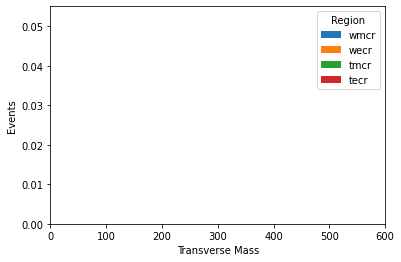

In [5]:
hist.plot1d(output['mT'].integrate('dataset'),overlay='region', stack=True)

In [1]:
from coffea.nanoaod import NanoEvents

fname = "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_128.root"
events = NanoEvents.from_file(fname)


In [2]:
Met = events.MET

In [9]:
Met.size

23306

In [8]:
(Met.pt>100).sum()

3422

In [9]:
Met['T']  = TVector2Array.from_polar(Met.pt, Met.phi)


In [12]:
Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)

In [13]:
Met.p4.pt

<VirtualArray [7.4979124 26.386288 46.416073 ... 81.968796 65.66127 106.205696] at 0x7fd362402a90>

In [20]:
events.columns

['GenVisTau',
 'Photon',
 'SoftActivityJetNjets5',
 'SoftActivityJetHT',
 'FatJet',
 'genWeight',
 'SoftActivityJetHT2',
 'HLTriggerFirstPath',
 'Generator',
 'GenJet',
 'fixedGridRhoFastjetCentralCalo',
 'luminosityBlock',
 'SoftActivityJetNjets10',
 'GenMET',
 'SoftActivityJet',
 'LHEReweightingWeight',
 'LHEScaleWeight',
 'Jet',
 'SoftActivityJetHT5',
 'TrigObj',
 'PSWeight',
 'FsrPhoton',
 'HTXS',
 'MET',
 'LHEPdfWeight',
 'SubGenJetAK8',
 'L1',
 'GenJetAK15',
 'PuppiMET',
 'Pileup',
 'GenSubJetAK15',
 'LHE',
 'fixedGridRhoFastjetCentralChargedPileUp',
 'SubJet',
 'SV',
 'Tau',
 'AK15PuppiSubJet',
 'L1simulation',
 'ChsMET',
 'fixedGridRhoFastjetCentralNeutral',
 'btagWeight',
 'HLT',
 'fixedGridRhoFastjetCentral',
 'fixedGridRhoFastjetAll',
 'HLTriggerFinalPath',
 'SoftActivityJetHT10',
 'run',
 'CorrT1METJet',
 'genTtbarId',
 'CaloMET',
 'event',
 'LHEPart',
 'IsoTrack',
 'OtherPV',
 'GenDressedLepton',
 'Flag',
 'L1Reco',
 'GenPart',
 'TkMET',
 'LHEWeight',
 'Muon',
 'GenJetAK8'

In [94]:
len(events)

23306

In [66]:
(abs(events.GenPart.pdgId) == 24)[0]

array([False, False,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [65]:
events.GenPart.hasFlags(['fromHardProcess'])[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True, False,  True,  True,  True,
        True,  True,  True, False,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False, False])

In [67]:
events.GenPart.hasFlags(['fromHardProcess'])[0] & (abs(events.GenPart.pdgId) == 24)[0]

array([False, False,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True, False,  True, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [113]:
a = (events.GenPart[events.GenPart.hasFlags(['fromHardProcess', 'isFirstCopy', 'isPrompt']) & ((abs(events.GenPart.pdgId) == 24))].pt > 100).all()

In [115]:
events = events[a]

In [117]:
met = events.MET

In [118]:
events

ValueError: new columns can only be attached to the original Table, not a view (try table.base['col'] = array)

In [108]:
(events.GenPart[events.GenPart.hasFlags(['fromHardProcess', 'isFirstCopy', 'isPrompt']) & ((abs(events.GenPart.pdgId) == 24))].pt > 100)

<JaggedArray [[True] [False] [True] ... [True] [False] [False]] at 0x7fbeac419ef0>

In [13]:
Jet['btagDeepB'] >  0

<JaggedArray [[False True True False] [False True True ... True False True] [True False True True False True] ... [True False] [True True True ... False False False] [False False True False False]] at 0x7fbeb2ea2668>

In [14]:
Jet['btagDeepB']

<JaggedArray [[-2.0 0.053710938 0.021331787 -2.0] [-2.0 0.034698486 0.0184021 ... 0.032104492 -2.0 0.013824463] [0.025375366 -2.0 0.027648926 0.051635742 -2.0 0.03250122] ... [0.051361084 -2.0] [0.26635742 0.032714844 0.022781372 ... -2.0 -2.0 -2.0] [-2.0 -2.0 0.24133301 -2.0 -2.0]] at 0x7fbeadd02b70>

In [20]:
TVector2Array.from_polar(met.phi, met.pt)

<TVector2Array [TVector2(1.7682, -0.77088) TVector2(-2.0066, -0.17418) TVector2(-2.6734, -1.3592) ... TVector2(1.897, -0.12509) TVector2(-0.0019087, 0.0010175) TVector2(-1.8175, 0.52236)] at 0x7f85f23ff0f0>

In [24]:
TVector2Array.from_polar(electron.phi, electron.pt).sum()

<TVector2Array [TVector2(-0.40969, 1.9192) TVector2(0, 0) TVector2(-0.1066, 0.093396) ... TVector2(0, 0) TVector2(0, 0) TVector2(0, 0)] at 0x7f85f23ddc88>

In [ ]:
for i in ['Ele32_WPTight_Gsf',
                'Ele115_CaloIdVT_GsfTrkIdT',
                'Photon200']:
    if i in events.HLT.columns:
        print(i, 'yeas')
    else:continue

In [ ]:
any([ True for i in ['Ele32_WPTight_Gsf',
                'Ele115_CaloIdVT_GsfTrkIdT',
                'Photon200'] if i in events.HLT.columns])

In [1]:
a = [[(1,2),(5,5)]]

In [4]:
import awkward

In [6]:
a = awkward.fromiter([[(1, 2), (3,3)]])

In [7]:
a.sum()

<JaggedArray [[3 6]] at 0x7f8632677518>

In [13]:
jets = events.Jet

In [22]:
events.metadata

{}

In [18]:
for i, j in zip(jets.btagCSVV2, jets.pt):
    print (i, '--\n', j,'\n\n')

[0.13330078 0.34204102 0.40112305 0.52734375 0.5107422 ] --
 [153.        39.6875    23.15625   16.859375  16.28125 ] 


[  0.14172363 -10.         -10.         -10.           0.1439209 ] --
 [65.5625   58.75     30.203125 24.296875 19.109375] 


[  0.34350586 -10.           0.13146973   0.5449219  -10.
 -10.         -10.        ] --
 [108.625     33.40625   33.1875    20.8125    18.0625    15.765625
  15.65625 ] 


[  0.35742188   0.18078613   0.16113281   0.54541016 -10.        ] --
 [76.875    56.53125  28.75     19.765625 17.421875] 


[  0.07904053   0.08178711 -10.         -10.           0.15124512
   0.16101074 -10.           0.5449219 ] --
 [75.25     69.8125   36.09375  25.375    23.265625 18.078125 15.984375
 15.15625 ] 


[  0.66796875   0.09124756   0.36401367   0.21069336 -10.
 -10.         -10.        ] --
 [191.625      69.875      32.59375    25.453125   17.78125    16.5625
  15.7421875] 


[0.12902832 0.07196045 0.17980957 0.36035156 0.13391113] --
 [127.8125   123.562

 [84.4375   28.359375 26.078125 23.828125 19.125   ] 


[  0.85791016 -10.         -10.           0.47875977   0.5761719
 -10.        ] --
 [65.375    48.       44.40625  21.03125  17.015625 16.25    ] 


[0.9941406  0.83203125 0.52685547] --
 [64.5      37.625    16.453125] 


[  0.37036133   0.30419922   0.16760254 -10.        ] --
 [59.71875 41.5625  41.21875 24.28125] 


[  0.25268555   0.11114502   0.52978516 -10.         -10.
 -10.           0.3112793 ] --
 [117.625     42.5       26.234375  25.515625  19.703125  18.59375
  17.515625] 


[  0.2746582    0.16467285   0.22058105   0.2536621  -10.
 -10.         -10.        ] --
 [56.0625    44.03125   29.46875   20.28125   19.65625   15.7734375
 15.0703125] 


[  0.09179688   0.35595703 -10.           0.37841797 -10.        ] --
 [46.9375   27.6875   21.       18.515625 17.421875] 


[  0.20227051   0.07373047   0.14331055 -10.           0.3022461
 -10.           0.46655273 -10.        ] --
 [93.375     88.4375    30.265625  25.5312

[  0.10943604   0.23986816   0.17675781   0.5551758  -10.        ] --
 [66.1875    59.71875   45.75      16.296875  15.8359375] 


[  0.12194824   0.30078125 -10.           0.5488281    0.16955566
   0.52734375 -10.         -10.        ] --
 [90.9375   76.25     51.625    23.21875  21.515625 19.671875 17.078125
 16.171875] 


[  0.4428711  -10.           0.15942383   0.2993164 ] --
 [49.15625 43.59375 43.25    15.09375] 


[0.6386719  0.20141602 0.19677734 0.19421387 0.21496582 0.35864258
 0.5263672 ] --
 [58.875     50.59375   34.375     34.28125   21.484375  18.703125
 15.2265625] 


[0.58496094 0.18273926 0.21008301 0.5292969  0.14160156] --
 [81.5625   24.0625   21.703125 20.390625 16.265625] 


[  0.16552734   0.21899414   0.1274414    0.5415039    0.53125
 -10.         -10.         -10.        ] --
 [121.0625    68.5625    46.125     27.03125   17.03125   16.59375
  16.546875  15.5625  ] 


[  0.9477539  -10.           0.26635742 -10.           0.54541016
   0.23718262] --
 [87.4

 [57.03125  54.       52.34375  24.828125 17.203125] 


[-10.           0.14697266 -10.           0.3630371 ] --
 [83.8125   44.0625   25.984375 18.515625] 


[  0.12127686   0.10632324   0.21166992 -10.           0.55322266
 -10.           0.3232422 ] --
 [55.25      52.71875   38.375     28.34375   17.953125  17.53125
 15.4453125] 


[  0.07214355 -10.           0.2055664    0.5263672    0.2133789
   0.16723633] --
 [57.5625   45.       40.625    20.3125   19.328125 17.484375] 


[-10.         -10.           0.36547852   0.63720703   0.13024902] --
 [89.9375   87.25     27.71875  26.265625 23.171875] 


[  0.065979    0.0982666 -10.        -10.       ] --
 [78.9375   31.453125 28.5625   18.125   ] 


[  0.15698242   0.9633789    0.13232422 -10.        ] --
 [104.3125    94.5       22.0625    15.328125] 


[  0.14746094 -10.           0.14978027 -10.         -10.
   0.2548828 ] --
 [123.3125    21.71875   20.59375   17.671875  17.375     16.53125 ] 


[0.5449219  0.86621094] --
 [146.

   0.5317383 ] --
 [50.03125  34.34375  25.203125 24.8125   16.296875 15.828125] 


[  0.16174316   0.1616211    0.11810303 -10.           0.6791992
   0.5473633  -10.        ] --
 [62.6875   57.375    47.5      30.625    19.515625 17.8125   16.46875 ] 


[  0.41674805   0.77783203   0.46435547   0.5522461    0.20019531
 -10.        ] --
 [49.1875  44.21875 42.4375  36.3125  21.8125  15.40625] 


[  0.29736328   0.2553711    0.16540527 -10.           0.1953125 ] --
 [50.625    44.125    37.       29.546875 15.203125] 


[  0.30200195 -10.           0.2932129  -10.           0.32861328
 -10.        ] --
 [76.3125   42.53125  30.640625 25.828125 21.25     18.578125] 


[  0.40185547   0.21069336   0.46289062   0.14111328   0.1517334
   0.24609375 -10.        ] --
 [50.09375  37.53125  22.421875 22.328125 21.171875 21.09375  16.421875] 


[0.10925293 0.0645752  0.11291504 0.5727539  0.5258789  0.38964844] --
 [94.25    63.25    59.53125 20.625   16.6875  15.9375 ] 


[0.2368164  0.1313476

 [63.25     62.1875   50.34375  23.90625  19.875    19.796875] 


[  0.5341797    0.34179688   0.39086914 -10.        ] --
 [181.25     20.21875  20.03125  17.375  ] 


[  0.07391357   0.7011719    0.15881348 -10.         -10.        ] --
 [68.125    43.       31.5625   17.828125 16.828125] 


[  0.09979248   0.23413086   0.17565918 -10.           0.7011719
 -10.        ] --
 [68.25    52.5625  26.15625 23.28125 16.09375 15.09375] 


[  0.09814453   0.5996094    0.21801758   0.49487305 -10.
   0.6328125    0.52978516] --
 [101.75      64.375     24.90625   23.578125  22.375     19.953125
  17.296875] 


[  0.06222534   0.22949219 -10.         -10.           0.38623047
 -10.           0.52978516] --
 [70.0625   64.5625   19.453125 18.890625 16.5      16.484375 16.21875 ] 


[  0.55322266   0.09594727   0.13439941   0.15197754 -10.
 -10.        ] --
 [67.9375    58.5625    30.359375  29.0625    16.109375  15.6015625] 


[0.31030273 0.6845703  0.32714844 0.72558594] --
 [43.75     35.25  

 15.125    ] 


[  0.38305664   0.62841797   0.20153809 -10.        ] --
 [52.15625  35.34375  19.546875 17.8125  ] 


[  0.16357422   0.43676758   0.10223389   0.83154297 -10.
 -10.           0.5517578  -10.           0.5488281    0.15942383
   0.53027344   0.5263672 ] --
 [110.4375    64.4375    56.4375    56.21875   30.03125   25.078125
  21.109375  21.03125   18.171875  16.078125  16.03125   15.625   ] 


[0.50683594 0.17211914 0.21923828] --
 [122.25    65.5625  33.0625] 


[  0.06433105   0.4560547    0.4555664    0.21228027 -10.
   0.22436523 -10.        ] --
 [81.4375   43.875    42.84375  21.46875  18.75     17.0625   17.015625] 


[-10.           0.12304688   0.91015625 -10.           0.21765137] --
 [53.03125  45.46875  26.8125   17.640625 15.671875] 


[0.42041016 0.1829834  0.19824219 0.17626953] --
 [74.0625   32.5      26.96875  24.453125] 


[0.27563477 0.10119629 0.5390625  0.5463867  0.5292969  0.5463867 ] --
 [108.375     57.53125   47.75      26.828125  19.03125   1

 [78.      53.09375 28.53125 20.65625] 


[0.80322266 0.08581543 0.55029297 0.34594727] --
 [141.5     130.875    25.9375   18.40625] 


[  0.32885742   0.07507324   0.38500977 -10.           0.42211914
   0.19799805   0.5239258  -10.           0.4416504 ] --
 [84.375    61.78125  23.28125  21.1875   21.109375 20.5625   20.25
 17.09375  16.      ] 


[  0.17272949   0.07861328   0.09564209   0.6308594    0.17480469
   0.8183594  -10.           0.52734375   0.5263672 ] --
 [79.125     70.375     45.5       31.578125  24.84375   18.703125
 15.4140625 15.4140625 15.1015625] 


[  0.48632812   0.5131836    0.30249023 -10.         -10.
 -10.           0.6479492 ] --
 [59.8125    59.59375   39.9375    19.703125  15.5234375 15.3671875
 15.3515625] 


[-10.           0.15795898   0.4650879    0.14025879   0.17993164
   0.22009277   0.53222656   0.5283203    0.53027344 -10.        ] --
 [53.03125   50.28125   35.09375   30.21875   24.        22.40625
 16.96875   16.0625    15.875     15.7421875

 [86.125    68.5625   54.21875  32.65625  23.46875  20.296875 19.1875
 18.9375   16.453125 15.890625] 


[0.0569458  0.8666992  0.52734375 0.3149414 ] --
 [62.3125   58.25     21.609375 19.53125 ] 


[0.0670166  0.16320801 0.15698242 0.53125    0.52978516 0.7626953 ] --
 [75.6875    53.34375   51.625     32.78125   22.171875  15.9609375] 


[  0.08709717   0.33520508   0.55078125 -10.         -10.        ] --
 [69.4375   24.53125  20.296875 18.0625   15.703125] 


[  0.52685547   0.12335205   0.9033203  -10.           0.3696289
   0.40356445 -10.        ] --
 [93.125    46.09375  26.71875  22.484375 17.578125 16.0625   15.3125  ] 


[  0.2861328  -10.           0.26586914 -10.           0.34765625
 -10.        ] --
 [56.25     36.4375   26.171875 19.375    18.859375 16.203125] 


[-10.           0.15612793 -10.        ] --
 [74.1875   57.25     26.109375] 


[  0.10498047   0.11376953   0.20361328   0.40063477 -10.
   0.52783203   0.55371094] --
 [84.9375    75.75      33.4375    24.18

 [72.125    52.625    50.9375   25.90625  20.8125   19.453125 18.390625
 16.390625] 


[  0.09179688 -10.           0.31274414 -10.        ] --
 [63.84375 40.4375  24.03125 19.28125] 


[0.4716797  0.13830566 0.25048828 0.3371582 ] --
 [33.65625  28.8125   21.609375 16.4375  ] 


[  0.11053467 -10.         -10.         -10.           0.45898438
   0.46166992] --
 [69.       32.21875  32.0625   21.203125 18.953125 15.515625] 


[-10.           0.1529541  -10.           0.40307617] --
 [104.1875     22.015625   19.515625   15.2421875] 


[-10.           0.26171875   0.6430664    0.1586914 ] --
 [53.5625    26.96875   18.953125  15.6953125] 


[0.09381104 0.21252441 0.33203125 0.86328125 0.9477539 ] --
 [95.8125   87.8125   22.4375   20.1875   15.328125] 


[  0.39257812   0.11657715   0.66796875 -10.         -10.
   0.5336914    0.3581543    0.55371094   0.5498047    0.5317383
   0.46289062] --
 [77.5       60.71875   29.875     25.984375  21.796875  21.21875
 21.15625   20.546875  19.87

 [89.625   40.6875  34.28125 18.3125 ] 


[  0.6435547    0.06585693   0.09356689 -10.           0.41137695
 -10.        ] --
 [65.5       53.125     47.90625   34.65625   19.9375    15.5546875] 


[  0.14233398   0.13989258   0.14086914 -10.         -10.
   0.9482422    0.6123047    0.18395996] --
 [35.28125  33.75     31.375    31.203125 30.75     22.984375 20.5625
 19.390625] 


[  0.1907959  -10.           0.18481445   0.22192383 -10.
   0.34887695   0.5263672  -10.        ] --
 [87.0625    59.09375   42.03125   33.34375   20.09375   19.34375
 16.546875  15.6328125] 


[-10.         -10.           0.2614746    0.5463867    0.67626953
 -10.        ] --
 [62.21875  52.125    29.109375 23.90625  21.515625 18.359375] 


[  0.11303711 -10.         -10.           0.52734375] --
 [111.25      92.625     50.78125   17.234375] 


[-10.           0.76708984 -10.         -10.        ] --
 [65.0625  61.15625 33.03125 22.8125 ] 


[-10.           0.08435059] --
 [48.59375 40.40625] 


[-10.    


[  0.17785645   0.23571777   0.7661133    0.25512695   0.21032715
 -10.        ] --
 [88.5      49.71875  28.21875  27.15625  15.234375 15.140625] 


[  0.17407227   0.07775879   0.6850586    0.5517578  -10.
   0.5283203    0.2685547    0.5463867 ] --
 [109.6875     85.9375     44.1875     27.796875   19.21875    15.8984375
  15.2734375  15.0390625] 


[  0.3022461    0.06896973 -10.           0.54589844 -10.        ] --
 [105.3125     82.5625     48.96875    19.03125    15.7421875] 


[0.61035156 0.08868408 0.13244629 0.5336914  0.64941406] --
 [92.5625   41.96875  29.859375 20.03125  16.203125] 


[  0.15515137 -10.         -10.           0.5498047  -10.
 -10.        ] --
 [153.875    40.875    23.15625  22.78125  19.625    18.21875] 


[-10.           0.45654297   0.07543945   0.3984375    0.25097656
   0.1361084  -10.           0.20251465   0.31445312   0.5307617
   0.22875977   0.48510742 -10.           0.53027344   0.5292969 ] --
 [62.84375   58.84375   37.90625   36.71875   28.

 [56.03125  51.21875  29.390625 25.828125 24.328125 18.28125 ] 


[  0.1171875    0.8852539    0.35302734   0.24523926 -10.
   0.5883789    0.20812988   0.30786133 -10.         -10.
 -10.        ] --
 [58.3125    41.6875    27.28125   18.484375  17.953125  16.96875
 16.734375  16.578125  16.421875  16.109375  15.3671875] 


[  0.19372559 -10.           0.5522461 ] --
 [192.625     62.53125   20.546875] 


[  0.46142578   0.10876465   0.55810547   0.5332031    0.5541992
 -10.           0.5493164    0.5493164    0.53027344   0.5473633 ] --
 [81.        49.03125   37.        31.890625  22.015625  20.265625
 18.78125   18.28125   17.84375   15.1171875] 


[-10.           0.4699707    0.3178711    0.5288086    0.4399414
   0.24304199 -10.        ] --
 [110.875     37.46875   28.109375  22.4375    20.5       19.46875
  16.453125] 


[0.1192627  0.1262207  0.5263672  0.5449219  0.13256836] --
 [116.9375   103.25      19.921875  18.3125    17.296875] 


[-10. -10. -10.] --
 [106.1875   92.8125

 22.53125   19.59375   18.90625   15.1484375] 


[0.22180176 0.3737793  0.11383057 0.5473633  0.33422852] --
 [121.375     48.96875   43.625     18.515625  15.703125] 


[  0.05883789 -10.           0.20947266 -10.        ] --
 [79.625    37.9375   25.203125 15.21875 ] 


[0.08776855 0.43896484 0.19812012 0.38623047] --
 [44.       34.25     28.203125 23.421875] 


[0.06030273] --
 [88.375] 


[  0.1048584    0.09960938   0.4116211  -10.        ] --
 [57.34375  56.28125  55.90625  16.484375] 


[  0.27124023   0.26220703   0.16674805 -10.         -10.        ] --
 [109.625      49.96875    34.46875    15.75       15.2109375] 


[  0.40429688   0.1459961  -10.           0.53125      0.5341797
 -10.        ] --
 [118.4375    27.84375   24.        17.203125  16.5       15.078125] 


[  0.2614746    0.36279297   0.25976562   0.11737061 -10.
   0.13977051   0.5332031    0.7324219 ] --
 [60.84375  37.875    26.1875   23.65625  23.       22.09375  16.859375
 16.203125] 


[0.31323242 0.099060

 [132.125      34.3125     22.078125   19.71875    19.5        19.5
  19.484375   17.6875     17.625      15.53125    15.2578125  15.0625   ] 


[  0.1381836  -10.           0.7236328  -10.           0.53271484] --
 [41.90625  33.75     31.75     29.5625   18.953125] 


[-10.           0.17333984   0.14575195   0.85839844 -10.        ] --
 [66.0625   40.75     34.       22.640625 20.109375] 


[-10.           0.53027344 -10.           0.16516113] --
 [70.6875   29.9375   28.5      17.640625] 


[0.09155273 0.15808105 0.16052246 0.14111328] --
 [49.34375  33.65625  32.6875   16.015625] 


[  0.26879883   0.14587402 -10.           0.2006836 ] --
 [81.75     31.21875  21.359375 15.71875 ] 


[0.10900879 0.10754395 0.14709473 0.28735352 0.25830078] --
 [80.625    75.1875   50.15625  22.140625 20.9375  ] 


[-10.           0.1628418    0.13061523   0.15905762   0.5258789
 -10.        ] --
 [83.625    26.078125 23.265625 18.734375 18.53125  17.515625] 


[  0.12548828   0.8598633    0.122924

 [77.8125   72.3125   19.625    18.625    15.828125 15.3125  ] 


[0.0847168  0.21362305 0.12536621 0.15283203 0.55078125 0.17382812
 0.15307617] --
 [68.5      60.375    37.25     27.953125 23.15625  19.53125  18.421875] 


[  0.44848633   0.09906006   0.12927246   0.4790039  -10.        ] --
 [70.6875   65.3125   33.       31.09375  15.359375] 


[  0.0690918  -10.           0.22387695 -10.         -10.
   0.36547852   0.52978516] --
 [83.625     54.625     43.15625   36.59375   17.984375  15.9765625
 15.1640625] 


[0.07110596 0.07971191 0.23510742] --
 [67.8125   50.09375  21.828125] 


[  0.5541992  -10.           0.7480469    0.33789062   0.8623047
 -10.           0.14135742   0.77246094   0.53027344   0.5283203
 -10.        ] --
 [61.03125   60.625     39.46875   24.34375   23.59375   18.5625
 18.421875  18.34375   17.8125    16.59375   15.9765625] 


[  0.07025146   0.07995605   0.35253906   0.10699463   0.34204102
 -10.         -10.           0.35107422   0.5288086  -10.      

[0.13012695 0.10449219 0.23046875 0.22973633 0.7753906 ] --
 [49.15625  48.59375  35.34375  31.109375 28.734375] 


[0.35424805 0.09289551 0.6533203 ] --
 [99.5625   27.953125 21.921875] 


[0.12176514 0.12060547 0.2397461  0.5625     0.14550781 0.15734863] --
 [67.875     42.96875   29.375     21.03125   18.921875  15.0859375] 


[  0.6044922    0.87060547   0.3334961    0.70996094   0.36206055
 -10.         -10.           0.51123047   0.36108398   0.55078125
   0.16308594] --
 [54.1875    33.3125    27.34375   24.21875   22.265625  22.
 20.6875    20.40625   16.734375  15.6796875 15.3359375] 


[  0.10668945 -10.         -10.           0.13891602 -10.        ] --
 [99.75    69.125   62.25    51.09375 23.3125 ] 


[-10.           0.41992188] --
 [80.125   52.21875] 


[  0.07348633 -10.           0.13696289] --
 [95.125   91.25    34.53125] 


[0.15039062 0.3359375 ] --
 [148.25       15.3671875] 


[  0.10687256   0.4296875    0.21179199 -10.        ] --
 [110.75    71.9375  23.625  

 -10.        ] --
 [38.03125  30.09375  27.234375 24.15625  23.90625  21.609375 20.96875
 19.25     16.59375  16.3125   15.78125 ] 


[  0.7973633  -10.           0.20117188   0.8984375 ] --
 [37.375    33.75     32.1875   31.515625] 


[0.16577148 0.13671875 0.5332031  0.14404297 0.61035156 0.49902344] --
 [102.125     65.9375    30.234375  25.0625    18.859375  16.21875 ] 


[  0.2211914  -10.           0.18859863   0.17822266   0.6479492
   0.8413086 ] --
 [49.       48.46875  37.1875   27.671875 25.765625 19.078125] 


[  0.71728516   0.06170654 -10.           0.10559082] --
 [57.78125  50.09375  21.5625   19.328125] 


[0.07202148 0.8046875  0.12597656 0.1352539 ] --
 [63.375   55.21875 35.03125 28.53125] 


[  0.8359375    0.54785156   0.21899414 -10.        ] --
 [83.25     53.1875   18.078125 16.359375] 


[0.4489746  0.5878906  0.25512695 0.26586914 0.18005371 0.4309082 ] --
 [115.5625    89.1875    22.875     18.453125  18.28125   16.53125 ] 


[  0.14001465   0.09887695   0.

[0.29760742 0.3161621  0.29614258 0.24609375] --
 [102.9375   30.40625  24.03125  21.34375] 


[  0.09259033   0.43310547 -10.           0.40600586] --
 [112.4375    33.03125   20.390625  16.703125] 


[-10.           0.1784668    0.20935059   0.69921875   0.13378906
   0.19482422   0.14587402   0.78222656 -10.           0.14099121
   0.54589844   0.5527344 ] --
 [50.4375   34.9375   34.78125  33.34375  28.203125 25.       24.515625
 21.859375 16.953125 16.078125 15.859375 15.8125  ] 


[  0.13293457   0.11364746   0.17675781   0.5546875    0.53027344
 -10.        ] --
 [85.1875  55.84375 32.8125  31.3125  30.75    18.3125 ] 


[  0.16589355   0.2442627  -10.           0.11407471   0.5463867
 -10.           0.5444336 ] --
 [109.5625    71.125     42.84375   42.28125   21.71875   21.609375
  16.796875] 


[  0.09698486   0.17553711 -10.           0.5283203    0.41137695
   0.50439453 -10.           0.20825195   0.5263672  -10.
 -10.        ] --
 [69.625    40.3125   28.59375  23.515625 

 [157.625    139.125     28.875     20.890625] 


[-10.           0.5996094  -10.           0.22363281 -10.        ] --
 [81.0625   34.9375   26.078125 25.453125 18.078125] 


[0.46240234 0.5473633  0.52978516] --
 [119.625    110.6875    17.484375] 


[  0.08892822   0.1496582    0.17407227 -10.           0.7319336
 -10.           0.38500977 -10.        ] --
 [74.5625   74.125    38.90625  24.640625 21.046875 20.890625 16.953125
 16.296875] 


[  0.06854248   0.14782715 -10.         -10.        ] --
 [109.3125    70.375     17.359375  17.34375 ] 


[  0.17285156   0.10473633 -10.           0.42089844   0.34521484
 -10.         -10.        ] --
 [86.75     65.875    22.046875 20.296875 18.015625 16.0625   15.453125] 


[-10.           0.3293457    0.55322266   0.54785156 -10.        ] --
 [86.1875    75.8125    25.875     20.765625  15.5859375] 


[  0.08740234 -10.         -10.           0.19140625   0.37597656
   0.35668945   0.29614258 -10.           0.5263672 ] --
 [52.28125   50.4

[  0.08917236   0.19226074   0.54052734   0.53466797   0.5332031
   0.7348633  -10.           0.5566406    0.39868164] --
 [61.84375   55.3125    27.125     24.59375   22.921875  20.71875
 19.796875  15.546875  15.1328125] 


[  0.28076172   0.30908203 -10.         -10.        ] --
 [119.4375     18.421875   15.7421875  15.7109375] 


[0.11773682 0.14831543 0.14196777 0.19458008 0.48291016] --
 [56.5       45.375     33.65625   20.640625  15.0859375] 


[  0.14147949 -10.           0.11962891   0.19543457   0.578125  ] --
 [34.5      29.       27.703125 25.6875   16.578125] 


[  0.1418457    0.07904053 -10.        ] --
 [117.0625    37.125     27.765625] 


[  0.08093262   0.25585938 -10.         -10.         -10.        ] --
 [153.375     137.75       16.234375   15.890625   15.0703125] 


[  0.6010742    0.08227539 -10.           0.8745117  -10.
   0.52685547] --
 [139.75     113.0625    70.5625    29.59375   23.171875  16.828125] 


[  0.16674805   0.16577148   0.13366699 -10.     

 [156.125     63.40625   43.4375    26.390625  24.78125   18.296875
  16.828125  16.65625 ] 


[  0.11315918   0.7416992    0.42871094 -10.           0.36083984
   0.5292969 ] --
 [110.375     51.4375    30.5       23.921875  21.484375  16.15625 ] 


[  0.05224609   0.3635254    0.82666016   0.6455078  -10.        ] --
 [63.9375    38.9375    26.28125   20.53125   15.0546875] 


[0.765625   0.12286377 0.32470703 0.73876953 0.43896484] --
 [82.75      55.5625    21.015625  16.921875  15.8984375] 


[  0.09259033   0.48364258   0.53466797   0.53027344   0.55371094
   0.5366211  -10.           0.55615234   0.52734375] --
 [84.1875    78.625     20.609375  17.328125  16.65625   16.3125
 15.890625  15.1328125 15.0234375] 


[  0.1394043    0.17492676 -10.           0.28564453   0.25952148
 -10.        ] --
 [78.75     35.21875  23.296875 22.8125   21.40625  15.796875] 


[  0.36254883   0.4230957    0.5263672  -10.         -10.
   0.5288086  -10.        ] --
 [129.5        63.75       16.75

[-10.           0.07080078   0.20129395] --
 [59.       58.9375   29.828125] 


[  0.87158203   0.6376953  -10.           0.34301758 -10.
   0.20397949   0.44360352   0.23278809] --
 [54.90625  39.65625  33.65625  28.6875   25.484375 24.28125  19.046875
 15.390625] 


[  0.08282471   0.39697266 -10.           0.546875     0.5449219 ] --
 [116.1875     98.875      26.4375     22.203125   15.7421875] 


[0.21044922 0.09619141 0.52246094 0.44458008 0.17504883 0.546875
 0.54589844] --
 [108.75       98.8125     28.15625    21.359375   17.421875   15.90625
  15.3046875] 


[0.29736328 0.15820312] --
 [83.3125  40.28125] 


[-10.         -10.           0.20581055   0.24560547] --
 [81.625    79.       34.71875  23.296875] 


[-10.           0.25268555   0.68066406   0.40966797   0.2401123
   0.67333984   0.5541992    0.5288086    0.27514648 -10.
   0.52685547 -10.        ] --
 [62.5       48.9375    44.9375    40.375     30.921875  25.03125
 23.109375  22.140625  21.3125    19.625     17.031

 [79.625     71.1875    19.984375  18.203125  17.4375    16.078125
 15.5859375] 


[  0.85009766 -10.         -10.         -10.         -10.        ] --
 [63.46875  43.03125  29.546875 23.53125  21.4375  ] 


[0.2919922  0.46826172 0.52783203 0.4189453  0.40649414 0.34326172] --
 [74.6875   25.203125 22.6875   22.671875 22.234375 21.265625] 


[0.08660889 0.14672852 0.43725586] --
 [96.4375   48.78125  15.859375] 


[  0.14160156   0.45288086   0.6142578  -10.        ] --
 [65.       28.0625   27.015625 17.0625  ] 


[  0.3540039    0.35961914   0.2998047    0.13513184   0.22998047
   0.53515625 -10.        ] --
 [68.        42.40625   18.96875   17.96875   17.765625  15.546875
 15.5234375] 


[-10.           0.09539795   0.13928223   0.5444336 ] --
 [69.5625  66.3125  33.46875 16.3125 ] 


[  0.08050537   0.06921387   0.45825195   0.1472168    0.2553711
   0.54541016 -10.         -10.        ] --
 [66.875    48.1875   22.5      18.890625 18.609375 18.078125 17.609375
 15.      ] 


[0


[  0.13012695 -10.        ] --
 [134.375  111.0625] 


[  0.1038208    0.05984497   0.13330078   0.5498047  -10.
 -10.           0.6738281    0.5263672  -10.        ] --
 [126.625      61.5625     54.375      22.0625     21.046875   20.25
  19.703125   18.046875   15.8203125] 


[  0.2286377    0.5761719  -10.           0.14855957   0.52685547
 -10.         -10.        ] --
 [45.9375    33.21875   27.390625  21.703125  18.734375  15.78125
 15.2265625] 


[  0.34570312   0.1303711    0.2265625  -10.         -10.
   0.16564941   0.14807129   0.5263672    0.52734375] --
 [47.5       41.09375   31.421875  26.59375   19.8125    18.828125
 18.546875  15.96875   15.3359375] 


[0.06549072 0.07818604] --
 [219.875 111.625] 


[  0.10803223   0.18273926 -10.           0.46826172   0.2668457
 -10.        ] --
 [80.        31.984375  19.609375  19.3125    16.3125    15.1328125] 


[0.06756592 0.06494141] --
 [146.875   48.6875] 


[0.32617188 0.09069824 0.2163086  0.24572754] --
 [135.625     77

[  0.16296387   0.06738281   0.53466797 -10.        ] --
 [73.375   66.25    23.5625  17.21875] 


[-10.         -10.           0.54052734   0.5307617  -10.
   0.11712646 -10.           0.5473633  -10.        ] --
 [81.8125   49.78125  42.4375   22.5625   22.       20.71875  17.203125
 16.65625  16.515625] 


[-10.           0.12243652] --
 [119.5  66.5] 


[0.05560303 0.32543945 0.22717285] --
 [157.25      44.15625   18.484375] 


[  0.10070801 -10.           0.5410156    0.30541992 -10.
   0.5864258    0.25219727   0.5292969 ] --
 [64.375    30.765625 26.328125 24.84375  24.578125 20.078125 17.375
 16.      ] 


[  0.67626953   0.69140625   0.34545898   0.52783203   0.3334961
   0.2010498    0.5263672  -10.        ] --
 [122.8125    30.75      25.546875  23.765625  18.671875  18.640625
  15.84375   15.109375] 


[  0.65283203 -10.           0.13720703   0.2866211  -10.
   0.5263672    0.30371094 -10.        ] --
 [61.78125  38.59375  30.9375   28.21875  18.390625 17.140625 16.828125

[0.13989258 0.14318848 0.2553711  0.29956055 0.52685547] --
 [58.8125   40.5      33.125    24.78125  18.109375] 


[  0.5522461    0.40429688   0.13745117   0.11773682   0.22668457
 -10.           0.21203613 -10.         -10.         -10.
 -10.         -10.        ] --
 [34.46875  31.046875 30.375    25.4375   24.921875 24.328125 24.3125
 20.46875  19.734375 19.296875 18.8125   16.203125] 


[  0.41796875   0.04992676   0.13244629 -10.           0.52685547] --
 [69.25      66.6875    23.203125  21.84375   15.4296875] 


[  0.13195801   0.11407471   0.24963379   0.14538574   0.5527344
 -10.           0.55322266 -10.         -10.        ] --
 [86.8125   55.25     53.875    37.0625   19.265625 17.78125  17.59375
 17.328125 16.078125] 


[0.0925293  0.1182251  0.19848633] --
 [96.6875   49.03125  23.046875] 


[  0.32226562   0.3581543    0.69091797 -10.         -10.        ] --
 [94.125    30.53125  29.640625 26.265625 19.078125] 


[0.07983398 0.18395996 0.5317383  0.14428711] --
 [118.

 [48.34375  41.53125  35.59375  35.40625  33.375    29.859375 15.71875 ] 


[0.13513184 0.08074951 0.23620605 0.2644043 ] --
 [82.1875   79.5625   36.4375   18.953125] 


[  0.09301758   0.25341797   0.5498047    0.26879883 -10.
 -10.         -10.         -10.           0.55029297 -10.
   0.3232422  -10.        ] --
 [67.1875    63.875     42.71875   35.25      31.9375    26.390625
 22.390625  20.140625  18.375     15.7421875 15.2109375 15.0390625] 


[-10.           0.08685303   0.24108887 -10.        ] --
 [124.25    110.75     26.71875  21.78125] 


[0.07879639 0.1315918  0.12915039] --
 [101.3125    30.734375  23.5625  ] 


[  0.14538574   0.24145508   0.20605469   0.16589355   0.5390625
   0.25927734   0.5488281  -10.           0.45654297   0.15039062
 -10.        ] --
 [57.65625   46.875     40.9375    29.59375   25.171875  23.359375
 21.03125   18.140625  16.0625    15.3828125 15.3359375] 


[  0.13928223   0.6352539    0.33203125   0.8720703    0.53515625
   0.53466797 -10.    

 [98.5     36.96875 19.375  ] 


[  0.08850098   0.09063721   0.17895508 -10.         -10.
   0.52685547] --
 [48.6875    44.625     35.0625    23.921875  17.9375    15.3359375] 


[  0.06033325   0.10467529 -10.           0.5258789  -10.        ] --
 [163.5      135.625     16.40625   16.171875  15.5625  ] 


[0.18530273 0.3564453 ] --
 [81.1875   26.109375] 


[  0.56103516   0.23547363   0.7988281    0.13391113   0.14746094
   0.34228516   0.5473633    0.52978516   0.5258789  -10.
   0.5371094 ] --
 [63.625    52.15625  28.8125   28.203125 24.203125 24.015625 23.765625
 19.640625 16.5      16.296875 16.      ] 


[-10.         -10.           0.82421875   0.52685547   0.14648438] --
 [57.46875  31.9375   30.46875  27.25     16.328125] 


[0.12054443 0.15917969 0.13793945 0.21716309 0.15197754] --
 [53.9375    36.09375   26.53125   15.6640625 15.5234375] 


[  0.29785156   0.09143066 -10.         -10.        ] --
 [93.625    51.90625  22.296875 17.109375] 


[  0.11022949   0.078125  

 [58.71875  32.625    25.125    23.109375 18.6875   16.3125   16.234375] 


[  0.6323242    0.2602539    0.90527344   0.5546875  -10.
   0.5517578    0.8701172    0.55371094   0.5317383    0.53564453
   0.5307617 ] --
 [83.375    76.6875   32.75     25.359375 23.703125 20.046875 19.359375
 18.421875 17.078125 16.546875 15.640625] 


[0.23156738 0.8300781  0.14367676 0.13220215 0.12219238] --
 [69.625    62.71875  24.34375  23.5      19.703125] 


[  0.14892578   0.1574707  -10.           0.54541016] --
 [85.0625    67.        16.90625   15.3359375] 


[  0.11230469   0.07458496   0.4868164  -10.           0.47875977] --
 [168.125    111.875     23.328125  15.390625  15.046875] 


[  0.09680176   0.11706543 -10.         -10.           0.15856934
   0.52734375 -10.           0.5263672 ] --
 [78.6875   49.34375  33.       30.5625   30.515625 20.3125   19.84375
 19.453125] 


[-10.           0.08441162   0.07781982 -10.           0.48046875
   0.49291992] --
 [89.0625    71.1875    48.8437

 [83.9375   73.75     28.34375  27.375    17.359375] 


[  0.90722656 -10.           0.20239258   0.15258789   0.55371094] --
 [82.4375    24.125     19.703125  17.875     15.6484375] 


[  0.34887695 -10.         -10.           0.24963379] --
 [40.90625   40.75      24.359375  15.7265625] 


[  0.09234619   0.24829102   0.3635254  -10.         -10.        ] --
 [115.75      107.9375    105.125      18.6875     15.9140625] 


[0.31323242 0.1829834  0.07629395 0.45629883] --
 [129.75     65.       44.4375   16.21875] 


[  0.18383789   0.43115234 -10.         -10.           0.5463867
 -10.         -10.           0.5283203 ] --
 [54.875    44.625    25.65625  21.296875 20.90625  19.484375 17.59375
 15.796875] 


[0.08178711 0.17810059 0.20910645 0.40063477 0.52685547] --
 [100.875     33.34375   25.71875   22.484375  19.875   ] 


[  0.17138672   0.11328125   0.55078125   0.15283203 -10.
   0.53564453 -10.         -10.           0.5341797    0.53027344] --
 [55.       48.40625  36.84375 

   0.6166992  -10.         -10.        ] --
 [83.1875   58.8125   34.59375  28.65625  21.125    19.59375  19.359375
 15.796875] 


[0.16088867 0.19689941 0.22827148 0.6899414  0.2631836  0.17883301] --
 [66.75     30.859375 29.515625 24.453125 19.78125  18.234375] 


[  0.10595703   0.81347656   0.87939453 -10.           0.18432617
 -10.         -10.           0.5263672 ] --
 [42.9375   33.625    26.671875 19.796875 18.15625  17.28125  16.
 15.328125] 


[-10.         -10.           0.55566406 -10.         -10.
   0.54541016] --
 [38.71875  37.8125   19.421875 17.59375  15.875    15.65625 ] 


[  0.10089111 -10.           0.13061523   0.53125      0.52783203
 -10.           0.14819336   0.54785156 -10.           0.17346191
 -10.        ] --
 [48.5      45.34375  28.65625  25.109375 21.09375  20.15625  19.828125
 19.       17.9375   17.40625  15.046875] 


[  0.8183594   0.4724121 -10.          0.5415039] --
 [54.1875  50.125   37.46875 17.4375 ] 


[  0.24291992   0.46264648   0.178222


[-10.         -10.           0.32373047 -10.           0.22180176
   0.5444336    0.17919922   0.25341797] --
 [70.875     34.5       25.890625  20.375     18.4375    16.03125
 16.015625  15.7734375] 


[  0.5683594    0.54345703 -10.           0.12011719   0.35205078
   0.1940918    0.5292969    0.5307617    0.52734375   0.52685547
   0.5522461 ] --
 [47.84375  32.71875  29.828125 27.96875  25.671875 25.03125  20.328125
 18.640625 17.09375  17.       16.5625  ] 


[0.11743164 0.13085938 0.13867188 0.52783203 0.16601562] --
 [47.78125 33.25    31.9375  19.65625 15.75   ] 


[  0.30810547   0.19042969   0.1184082    0.2590332  -10.        ] --
 [63.15625   51.21875   24.328125  21.40625   15.1171875] 


[  0.14501953   0.21520996   0.22338867   0.5527344    0.15722656
   0.52783203 -10.         -10.           0.5288086 ] --
 [56.5625    30.296875  26.859375  26.203125  21.921875  19.53125
 15.9296875 15.625     15.1015625] 


[-10.           0.8520508  -10.           0.14001465   0.950

[  0.31176758 -10.           0.14257812   0.14379883] --
 [94.6875   63.6875   26.5625   23.953125] 


[-10.           0.53125      0.09155273   0.17675781   0.55615234] --
 [59.28125  27.34375  25.75     17.75     16.453125] 


[0.06988525 0.83691406 0.20935059 0.12792969 0.53027344 0.4909668 ] --
 [124.375     40.1875    34.0625    17.828125  16.703125  16.375   ] 


[-10.           0.15881348] --
 [113.375 112.875] 


[  0.29345703   0.55078125   0.10412598 -10.        ] --
 [120.5625  98.      68.4375  15.125 ] 


[0.08544922 0.14855957 0.12988281 0.5449219 ] --
 [92.6875   40.09375  21.109375 16.390625] 


[  0.11419678   0.1315918    0.5263672  -10.         -10.
   0.1459961 ] --
 [43.15625  31.40625  22.390625 21.4375   18.3125   15.890625] 


[0.12109375 0.07592773 0.33032227 0.61621094 0.15075684 0.24572754] --
 [128.25      64.75      33.8125    28.921875  18.1875    15.9375  ] 


[  0.15771484   0.1895752    0.34814453 -10.           0.31323242
   0.55322266] --
 [87.4375   

[  0.42749023   0.53564453   0.20788574 -10.         -10.
   0.5283203  -10.           0.52783203] --
 [94.0625    37.28125   34.65625   19.859375  18.234375  15.7890625
 15.7109375 15.3984375] 


[  0.25170898 -10.         -10.        ] --
 [69.1875   33.53125  26.765625] 


[  0.8930664    0.13122559 -10.         -10.         -10.        ] --
 [131.5       85.3125    33.375     24.5625    18.453125] 


[-10.         -10.         -10.         -10.           0.22705078] --
 [39.9375    38.78125   29.75      23.46875   15.2890625] 


[0.06512451 0.08166504 0.17919922 0.18164062] --
 [105.875     73.5625    26.953125  16.46875 ] 


[0.08428955] --
 [95.375] 


[  0.06762695   0.13830566 -10.         -10.           0.39233398
   0.6538086    0.24633789   0.5263672 ] --
 [74.       52.21875  48.96875  28.671875 23.890625 21.984375 21.65625
 17.015625] 


[  0.06439209 -10.           0.33520508] --
 [71.0625    18.46875   15.0859375] 


[0.6464844  0.27539062 0.06945801 0.25219727 0.5273437


[0.26708984 0.53027344 0.5317383  0.86865234 0.22180176] --
 [49.       36.78125  28.78125  21.140625 20.6875  ] 


[  0.12646484   0.25878906 -10.           0.16430664 -10.
   0.5444336  -10.        ] --
 [60.46875  38.       26.796875 21.6875   20.734375 17.171875 15.015625] 


[  0.12030029   0.30566406   0.22949219 -10.         -10.
 -10.           0.5332031 ] --
 [105.875     72.625     24.671875  15.875     15.765625  15.65625
  15.34375 ] 


[  0.0970459  -10.         -10.           0.35253906   0.17419434
   0.20800781   0.3996582    0.22937012 -10.         -10.
 -10.        ] --
 [56.84375   24.65625   23.203125  21.265625  19.875     19.53125
 18.09375   17.609375  16.8125    16.671875  15.6171875] 


[  0.11676025   0.55126953 -10.         -10.           0.23876953
 -10.        ] --
 [44.4375   24.203125 23.859375 21.9375   20.78125  20.15625 ] 


[  0.22619629   0.06732178 -10.         -10.           0.7758789
 -10.        ] --
 [96.5625  72.5625  38.09375 31.65625 18.75  

[  0.06652832 -10.         -10.           0.8461914 ] --
 [72.6875 51.3125 27.     24.625 ] 


[  0.06988525 -10.           0.11846924   0.19750977] --
 [66.125   64.625   51.96875 26.625  ] 


[  0.1171875  -10.           0.2758789    0.5283203    0.5307617
   0.54833984 -10.         -10.        ] --
 [56.71875   53.65625   27.09375   26.25      24.9375    21.265625
 20.015625  15.2578125] 


[0.06451416 0.06335449 0.12030029] --
 [65.875   41.40625 30.875  ] 


[0.12408447 0.11859131 0.28076172 0.6152344  0.19958496 0.54003906
 0.79052734 0.5288086 ] --
 [99.75     42.25     27.375    25.4375   25.34375  19.921875 18.625
 15.546875] 


[0.25439453 0.1439209  0.1739502  0.8076172  0.19372559 0.45922852
 0.22070312 0.29882812] --
 [54.0625   46.53125  32.15625  23.234375 19.28125  16.921875 15.671875
 15.328125] 


[  0.6455078    0.4658203  -10.         -10.           0.49609375
 -10.        ] --
 [140.625    119.8125    24.890625  19.234375  17.484375  15.71875 ] 


[  0.51953125 -10

 [74.125    40.46875  28.96875  26.03125  22.578125 18.125    17.53125
 17.265625 15.34375 ] 


[  0.20654297   0.06616211 -10.        ] --
 [78.6875  66.5     19.28125] 


[  0.07513428   0.6010742  -10.        ] --
 [117.1875    86.        21.515625] 


[  0.10272217 -10.           0.13293457   0.16015625   0.14208984] --
 [87.9375   55.65625  43.03125  20.765625 18.5625  ] 


[-10.           0.13891602   0.36401367 -10.        ] --
 [68.625    37.875    24.59375  19.640625] 


[  0.18103027   0.21691895 -10.           0.36083984   0.77441406
   0.5292969    0.76464844] --
 [48.28125  36.875    34.0625   18.375    18.125    17.203125 16.828125] 


[  0.6533203  -10.           0.10430908   0.79785156 -10.        ] --
 [87.9375   78.9375   21.296875 17.0625   15.734375] 


[  0.16967773 -10.         -10.           0.52734375   0.53027344] --
 [69.3125   59.09375  42.46875  17.21875  16.984375] 


[0.16479492 0.11315918 0.19604492 0.21972656 0.5307617  0.44311523
 0.375      0.23547363]

 [65.5625  60.78125 32.03125] 


[0.10040283 0.53222656 0.20007324] --
 [141.875     83.5625    23.140625] 


[0.07617188 0.07855225 0.52685547] --
 [94.875    83.4375   23.859375] 


[  0.09124756 -10.           0.48828125 -10.           0.24243164] --
 [46.375    30.546875 21.96875  18.5      18.375   ] 


[  0.11297607   0.20361328   0.1026001    0.53466797   0.6118164
   0.5317383  -10.           0.42773438   0.32348633   0.53466797
 -10.           0.3708496 ] --
 [61.15625   49.125     45.09375   35.4375    31.8125    24.15625
 20.859375  18.109375  17.75      16.078125  15.5703125 15.328125 ] 


[  0.703125     0.16052246   0.28588867 -10.           0.53125
   0.52734375 -10.        ] --
 [95.375     39.25      23.140625  16.84375   15.6484375 15.484375
 15.1875   ] 


[  0.09954834 -10.           0.5292969    0.16345215   0.52783203] --
 [129.        63.        19.484375  18.203125  17.09375 ] 


[0.7998047  0.26953125 0.3930664  0.17700195] --
 [63.53125  44.53125  25.828125 18

   0.52685547] --
 [87.25      38.        25.6875    23.6875    22.984375  15.7265625] 


[  0.2055664    0.46166992   0.58984375   0.6352539    0.5263672
 -10.         -10.        ] --
 [57.71875  53.21875  25.859375 25.59375  20.171875 17.15625  16.609375] 


[  0.28125      0.18908691   0.40942383   0.3232422    0.53027344
   0.17883301 -10.           0.55322266 -10.         -10.
 -10.           0.3305664 ] --
 [115.8125     86.5625     51.5625     24.734375   18.65625    18.4375
  16.421875   16.390625   15.859375   15.8515625  15.7578125  15.296875 ] 


[  0.16845703   0.1159668    0.13000488 -10.           0.5419922
 -10.         -10.        ] --
 [102.875     52.625     28.546875  20.921875  20.796875  17.25
  16.015625] 


[  0.3083496    0.17321777 -10.         -10.           0.18725586
   0.33691406] --
 [112.125     84.25      18.015625  17.21875   15.515625  15.28125 ] 


[0.1628418  0.08532715 0.72558594 0.7919922  0.53271484] --
 [76.375    50.1875   49.21875  24.984375 1

 [115.875    63.21875] 


[  0.3203125    0.07318115   0.15905762 -10.        ] --
 [76.8125   42.65625  19.703125 19.015625] 


[  0.4338379    0.3696289  -10.           0.15966797 -10.
 -10.           0.52783203 -10.        ] --
 [50.78125   38.28125   25.484375  21.46875   21.203125  15.984375
 15.7734375 15.0234375] 


[  0.15222168   0.105896   -10.           0.83691406   0.5488281
   0.5463867    0.54833984] --
 [160.875     129.25       32.03125    26.953125   15.5078125  15.4921875
  15.390625 ] 


[  0.73828125 -10.           0.24731445] --
 [149.25     127.375     17.015625] 


[  0.2854004  -10.         -10.           0.5332031    0.5317383
 -10.           0.16662598] --
 [62.125     33.625     28.21875   19.578125  18.578125  15.640625
 15.4140625] 


[0.1673584  0.3708496  0.13415527 0.33374023 0.68066406 0.5       ] --
 [103.3125    63.40625   31.078125  29.875     24.5625    20.46875 ] 


[  0.08496094   0.19335938   0.14685059   0.5410156  -10.
   0.1303711    0.1701660


[  0.13708496   0.10620117 -10.           0.5205078  -10.
 -10.           0.24401855   0.5395508  -10.           0.5449219
   0.9033203    0.5444336 ] --
 [55.78125  47.28125  39.8125   27.640625 27.203125 24.984375 23.96875
 22.796875 21.       20.640625 20.640625 15.765625] 


[0.08117676 0.5288086  0.5292969 ] --
 [84.8125 22.6875 21.75  ] 


[-10.           0.22290039   0.32128906 -10.           0.19592285] --
 [124.75       86.4375     25.65625    15.375      15.2734375] 


[0.12207031 0.56103516 0.24938965 0.56591797 0.5292969  0.52685547
 0.4345703  0.5473633 ] --
 [84.       68.8125   32.15625  30.890625 21.75     18.484375 18.046875
 15.296875] 


[0.11639404 0.85791016 0.5883789  0.53466797 0.15246582 0.6044922 ] --
 [53.90625  52.40625  26.359375 23.109375 21.890625 19.203125] 


[  0.0947876    0.12475586   0.58984375 -10.         -10.
   0.53027344 -10.         -10.           0.29052734] --
 [80.5       58.4375    47.75      26.578125  25.65625   21.296875
 19.515625  15.

[  0.07269287   0.19311523   0.3647461    0.54541016   0.3564453
 -10.        ] --
 [57.0625    50.09375   36.75      18.3125    17.21875   15.7265625] 


[  0.15771484 -10.           0.36450195   0.7861328  -10.
   0.2142334  -10.           0.53222656   0.578125   -10.
   0.52246094] --
 [52.90625  52.65625  32.375    26.828125 24.5625   19.328125 18.4375
 16.984375 16.625    15.53125  15.265625] 


[  0.06921387   0.53515625   0.39379883   0.5307617    0.21105957
 -10.        ] --
 [143.5       30.90625   28.078125  26.859375  25.9375    20.3125  ] 


[-10.          0.5498047 -10.          0.6069336] --
 [68.0625   40.90625  31.34375  16.609375] 


[  0.5878906  -10.           0.43603516 -10.           0.22106934
   0.52783203 -10.           0.53125   ] --
 [94.125     24.84375   21.515625  18.03125   17.8125    15.578125
 15.3984375 15.0625   ] 


[  0.8066406    0.44873047   0.55810547   0.20800781   0.53125
   0.5288086  -10.         -10.         -10.         -10.        ] --
 [12

 [96.8125   79.25     37.4375   18.21875  16.5      16.203125 15.90625 ] 


[  0.40600586   0.25756836 -10.           0.52783203   0.19189453] --
 [68.25     61.3125   30.125    21.921875 21.828125] 


[-10.           0.12200928   0.32788086   0.55908203 -10.
   0.7583008    0.14575195 -10.         -10.         -10.
   0.83740234] --
 [56.34375  46.65625  32.5625   32.       29.6875   28.140625 24.171875
 23.546875 20.484375 17.375    16.390625] 


[  0.3564453    0.44555664   0.12915039 -10.        ] --
 [104.625      69.1875     34.1875     15.0234375] 


[  0.10412598 -10.           0.13293457   0.29101562] --
 [66.8125   57.0625   46.5625   31.265625] 


[  0.19921875 -10.           0.27685547   0.7192383 ] --
 [66.3125  53.1875  34.875   23.21875] 


[  0.13659668   0.09802246   0.20263672   0.5336914    0.5336914
 -10.           0.52734375   0.52685547   0.2602539 ] --
 [59.71875   57.71875   47.90625   27.296875  20.0625    20.046875
 16.46875   15.6484375 15.125    ] 


[0.0687

 [88.625    70.0625   35.90625  27.59375  19.       18.5      18.109375] 


[  0.76171875   0.14990234 -10.           0.55566406] --
 [50.6875   36.90625  28.671875 19.75    ] 


[  0.10302734   0.08734131   0.14868164 -10.        ] --
 [64.8125   54.40625  40.53125  18.046875] 


[0.08654785 0.08251953 0.13122559] --
 [157.375   115.625    16.59375] 


[0.27441406 0.5209961 ] --
 [120.5     53.5625] 


[  0.17578125 -10.           0.13232422 -10.        ] --
 [81.8125    31.078125  28.796875  15.4296875] 


[  0.22717285 -10.           0.5317383    0.16149902   0.09967041
   0.39501953 -10.        ] --
 [40.34375   40.28125   21.21875   20.71875   17.3125    16.359375
 15.2265625] 


[0.19238281 0.66064453 0.16333008 0.5292969  0.5317383  0.66552734
 0.52197266] --
 [64.8125  54.15625 37.34375 24.90625 24.78125 17.46875 17.21875] 


[-10.           0.25268555   0.20874023   0.4802246    0.16271973
 -10.           0.5463867    0.45776367 -10.        ] --
 [104.0625    37.53125   36.843

[-10.           0.390625     0.1282959  -10.           0.92578125
 -10.           0.3552246    0.3581543 ] --
 [42.875    41.3125   35.53125  27.390625 22.265625 16.3125   16.1875
 15.296875] 


[-10.         -10.         -10.         -10.           0.5317383
 -10.           0.52490234] --
 [105.75      31.421875  24.0625    23.609375  23.140625  17.671875
  16.921875] 


[0.09777832 0.16442871 0.13635254 0.15222168] --
 [67.8125   39.21875  27.59375  19.265625] 


[  0.35961914   0.20043945   0.5292969  -10.         -10.
   0.52734375   0.36279297 -10.        ] --
 [68.3125   63.       38.25     26.453125 19.       17.03125  16.3125
 15.328125] 


[  0.55566406   0.06896973   0.07507324 -10.         -10.
   0.18029785 -10.           0.47460938 -10.           0.20141602
   0.5283203 ] --
 [96.125     74.4375    52.28125   31.625     22.046875  20.953125
 18.109375  17.484375  16.359375  15.6015625 15.4140625] 


[  0.16748047 -10.         -10.         -10.        ] --
 [121.6875    42.

 [57.6875   51.03125  32.53125  31.578125 17.484375 16.25     16.046875
 15.25    ] 


[  0.07318115   0.13012695 -10.         -10.         -10.
   0.21044922 -10.        ] --
 [67.3125   48.875    25.703125 24.15625  23.828125 23.75     15.65625 ] 


[  0.09552002   0.3786621    0.74560547   0.90283203   0.5288086
   0.16552734 -10.           0.7055664    0.51171875 -10.        ] --
 [65.625    43.78125  26.75     26.015625 18.640625 17.390625 16.59375
 16.453125 16.109375 15.125   ] 


[  0.40722656   0.09295654   0.0980835    0.54833984   0.52783203
 -10.           0.5307617 ] --
 [134.625    117.0625    40.90625   17.109375  16.        15.78125
  15.671875] 


[  0.6386719    0.13623047   0.21057129   0.52734375   0.21801758
   0.13195801   0.53466797 -10.         -10.           0.25683594] --
 [93.1875   53.46875  36.46875  27.78125  23.625    22.265625 20.890625
 18.96875  16.703125 16.296875] 


[  0.23168945   0.15893555   0.52685547 -10.        ] --
 [67.25     32.75     30.10

 [76.        50.40625   25.609375  20.9375    18.84375   16.109375
 15.0234375] 


[  0.15332031   0.11950684   0.52783203 -10.           0.27514648
 -10.        ] --
 [108.625     74.4375    19.359375  18.828125  16.1875    15.90625 ] 


[  0.4885254    0.33520508   0.2644043    0.20336914 -10.
   0.49438477   0.5          0.5449219 ] --
 [156.75       91.8125     64.75       37.46875    22.59375    21.1875
  18.4375     15.6484375] 


[  0.11541748   0.13745117   0.15026855 -10.           0.5473633
   0.44750977] --
 [108.25      88.25      21.96875   17.59375   15.890625  15.09375 ] 


[  0.0562439    0.13793945   0.13085938 -10.           0.71777344
 -10.         -10.         -10.         -10.        ] --
 [84.75      47.15625   21.453125  16.703125  16.4375    15.8984375
 15.6796875 15.625     15.109375 ] 


[  0.36791992   0.13098145   0.6308594  -10.           0.53759766
   0.53125   ] --
 [95.375    26.796875 18.6875   17.125    15.828125 15.734375] 


[0.12463379 0.32739258] -

 [39.       38.4375   35.65625  24.96875  17.65625  17.453125 17.203125
 17.046875 16.265625] 


[  0.65527344   0.13842773 -10.           0.4338379  -10.
   0.5307617  -10.        ] --
 [123.75     88.       40.375    39.46875  20.09375  16.375    15.625  ] 


[  0.12432861   0.48242188 -10.         -10.           0.54589844
   0.8051758  -10.        ] --
 [35.125    30.671875 24.296875 22.546875 20.       18.59375  18.265625] 


[  0.13537598   0.12609863 -10.           0.63964844   0.5263672
   0.5336914  -10.           0.52441406] --
 [99.6875    34.3125    28.109375  24.671875  16.296875  16.265625
 15.6953125 15.234375 ] 


[  0.14453125 -10.           0.08306885 -10.           0.5288086
 -10.        ] --
 [75.1875   44.40625  29.953125 23.046875 19.875    16.546875] 


[  0.10406494   0.22680664   0.23034668 -10.           0.5263672
   0.90527344 -10.           0.5307617 ] --
 [45.21875  35.75     33.90625  21.515625 19.515625 18.109375 17.703125
 16.34375 ] 


[0.08361816 0.151

 [90.1875   75.0625   44.71875  41.4375   27.921875 18.21875  17.390625
 16.25     15.125   ] 


[  0.08721924   0.07910156   0.5361328  -10.         -10.
 -10.        ] --
 [106.875    105.9375    18.953125  18.90625   17.1875    17.09375 ] 


[  0.17285156   0.15612793   0.34423828 -10.           0.3347168
   0.28271484 -10.           0.33496094   0.5463867 ] --
 [97.6875    35.375     30.5625    25.953125  25.390625  17.34375
 16.390625  16.        15.9609375] 


[-10.           0.25610352   0.52783203   0.2097168    0.5522461
   0.5292969  -10.         -10.        ] --
 [73.875     45.28125   32.96875   27.625     18.859375  17.953125
 16.015625  15.4609375] 


[  0.08361816   0.10516357 -10.           0.22045898 -10.        ] --
 [57.46875   26.5625    25.328125  16.609375  15.1953125] 


[  0.71484375 -10.           0.3479004    0.5449219  -10.        ] --
 [81.0625   37.53125  21.328125 20.421875 17.9375  ] 


[-10.           0.42529297   0.24645996   0.52197266   0.49902344
 -1

[0.08660889 0.6035156  0.55126953 0.2006836  0.57177734] --
 [94.3125   89.6875   27.       21.453125 19.40625 ] 


[  0.7729492    0.41479492   0.11114502 -10.           0.82666016
   0.6171875    0.37329102] --
 [115.5625     26.84375    21.6875     16.046875   16.         15.921875
  15.1953125] 


[  0.6352539    0.7558594    0.14208984 -10.           0.24365234
 -10.         -10.        ] --
 [64.375    30.078125 27.609375 19.828125 18.921875 16.4375   15.8125  ] 


[  0.21960449 -10.         -10.           0.20471191] --
 [56.9375   37.09375  25.484375 20.671875] 


[0.32250977 0.14624023 0.54785156 0.1373291  0.5317383  0.24865723] --
 [52.65625   35.40625   21.984375  17.625     15.2421875 15.1953125] 


[  0.7578125    0.18518066   0.33569336   0.62353516   0.64746094
 -10.         -10.           0.2166748    0.17297363   0.8330078
   0.35717773   0.5307617 ] --
 [59.28125  49.90625  38.       24.5      21.828125 19.171875 18.15625
 17.859375 17.46875  17.1875   16.34375  15.8

[0.15637207 0.10766602 0.95703125 0.13793945 0.17443848 0.5366211
 0.5546875  0.45922852 0.25927734] --
 [154.75       83.3125     39.96875    32.375      29.03125    18.703125
  18.03125    16.953125   15.6015625] 


[  0.65185547   0.5283203    0.14282227 -10.           0.5292969
 -10.         -10.           0.52978516] --
 [107.125      38.34375    35.4375     22.25       21.0625     19.4375
  19.171875   15.4453125] 


[  0.09613037 -10.           0.16601562] --
 [65.375    27.953125 16.265625] 


[  0.39941406 -10.         -10.           0.23730469] --
 [109.5       19.515625  19.421875  15.234375] 


[  0.08612061 -10.           0.12188721] --
 [98.3125   25.5      25.203125] 


[0.06124878 0.45092773 0.15234375 0.5463867 ] --
 [80.4375   45.25     33.15625  17.203125] 


[  0.10876465 -10.         -10.        ] --
 [43.875   41.5625  15.46875] 


[  0.19812012   0.14855957 -10.           0.7006836    0.15783691
   0.18041992   0.5258789  -10.           0.14428711] --
 [50.375   

[  0.64746094   0.3305664    0.18444824 -10.        ] --
 [105.6875     35.3125     26.453125   15.1171875] 


[  0.62402344   0.33813477   0.54541016 -10.        ] --
 [57.25      53.75      17.5       15.4765625] 


[  0.17321777   0.140625   -10.           0.13183594   0.20202637
   0.23803711   0.13439941] --
 [121.375     60.96875   52.59375   30.265625  25.78125   16.75
  16.484375] 


[  0.33642578   0.6328125    0.8979492    0.2536621  -10.
   0.20373535   0.52783203   0.15734863] --
 [88.1875   51.8125   36.40625  29.234375 23.8125   20.109375 18.359375
 16.765625] 


[  0.31518555   0.1048584  -10.           0.38305664 -10.        ] --
 [96.875     42.21875   21.28125   16.        15.4453125] 


[  0.06021118   0.07244873   0.49047852   0.36645508 -10.        ] --
 [125.5       66.8125    39.40625   19.546875  17.75    ] 


[-10.           0.14770508 -10.           0.5317383    0.53027344] --
 [115.5625    88.25      33.96875   31.546875  24.8125  ] 


[  0.18481445   0.09490

 [100.25      83.        74.625     23.5       22.421875  20.046875
  16.953125  16.59375   15.71875 ] 


[-10.           0.70410156   0.13476562   0.265625   -10.
 -10.           0.5307617    0.7211914  -10.         -10.
   0.24157715] --
 [48.03125   35.09375   34.9375    33.1875    27.3125    19.3125
 18.515625  16.328125  16.125     15.3125    15.2578125] 


[  0.18713379   0.12817383   0.13439941   0.5288086    0.5288086
 -10.         -10.        ] --
 [98.75      72.6875    33.375     19.53125   18.625     15.5390625
 15.5      ] 


[  0.08349609   0.18774414   0.19213867   0.7885742  -10.
 -10.        ] --
 [66.6875    61.875     52.75      27.09375   20.65625   15.9765625] 


[0.05545044 0.07055664] --
 [86.     85.8125] 


[0.11053467 0.5854492 ] --
 [111.875  80.125] 


[0.121521   0.08599854 0.19934082] --
 [72.25   51.6875 41.1875] 


[  0.9355469    0.2783203    0.8652344  -10.           0.54785156
   0.16271973   0.26489258 -10.           0.5341797    0.5263672
 -10.     

 [68.8125    57.90625   32.40625   19.59375   16.90625   16.8125
 16.671875  15.1171875] 


[0.0574646  0.1050415  0.19006348 0.81884766] --
 [68.8125  60.4375  43.59375 16.0625 ] 


[  0.08178711 -10.         -10.           0.5263672    0.5307617 ] --
 [103.5        41.21875    36.03125    15.6328125  15.171875 ] 


[0.23840332 0.06506348 0.10137939 0.13244629 0.34301758 0.5810547 ] --
 [81.       70.3125   46.125    24.109375 23.5      17.078125] 


[-10.        -10.        -10.          0.5283203   0.1418457   0.5449219
 -10.        -10.       ] --
 [46.8125   45.21875  21.4375   18.96875  18.359375 16.703125 16.671875
 15.703125] 


[  0.09643555 -10.         -10.           0.1307373  -10.
   0.15625    -10.           0.5336914    0.5371094 ] --
 [161.75      68.75      59.9375    23.640625  23.03125   21.46875
  16.25      16.03125   15.46875 ] 


[  0.13391113   0.06585693   0.13745117   0.5283203  -10.        ] --
 [69.5625   46.1875   38.21875  18.65625  18.046875] 


[0.167846

   0.30151367   0.5283203 ] --
 [95.5     89.8125  27.1875  22.625   20.75    17.9375  16.40625] 


[-10.           0.27905273   0.23242188   0.1809082  -10.
 -10.        ] --
 [91.625     56.40625   33.90625   25.875     25.59375   15.8515625] 


[  0.2298584  -10.           0.5419922    0.55322266   0.6582031
   0.79248047   0.3371582 ] --
 [103.8125     39.53125    37.9375     24.078125   22.953125   22.15625
  15.0390625] 


[  0.0947876    0.06439209   0.5571289  -10.           0.4099121
   0.2854004  -10.           0.17126465] --
 [132.75      85.        32.46875   25.671875  23.453125  18.828125
  16.125     15.671875] 


[0.54345703 0.43164062 0.13671875 0.18103027] --
 [52.53125 51.375   50.5     35.     ] 


[-10.           0.06677246   0.13476562   0.32177734   0.25927734
 -10.           0.1772461 ] --
 [98.375     77.625     29.921875  21.09375   20.859375  15.1796875
 15.15625  ] 


[-10.           0.5595703    0.95166016 -10.        ] --
 [63.6875   44.21875  21.125    17

   0.5957031    0.54541016   0.5263672 ] --
 [74.       28.296875 24.40625  20.9375   17.34375  16.       15.796875
 15.546875] 


[  0.27978516   0.13293457   0.53222656   0.4892578    0.52978516
 -10.           0.5263672  -10.        ] --
 [37.90625  31.859375 28.171875 21.40625  19.90625  17.96875  16.859375
 16.453125] 


[  0.57421875   0.17456055 -10.           0.13183594   0.14929199
   0.54541016] --
 [75.4375    45.625     24.515625  19.96875   16.921875  15.6171875] 


[  0.29052734   0.14453125   0.5751953  -10.         -10.
   0.4885254    0.3383789    0.19567871   0.16894531   0.52783203
   0.52685547   0.34594727] --
 [56.25      39.5       22.234375  21.796875  20.171875  19.34375
 17.921875  17.8125    16.59375   16.4375    15.28125   15.0703125] 


[  0.09509277   0.13964844   0.1459961  -10.           0.54589844
   0.12109375] --
 [62.03125  55.5      27.75     17.5      17.421875 16.171875] 


[  0.07800293 -10.           0.12805176 -10.        ] --
 [79.6875    37.7

 [50.8125    48.8125    40.09375   39.96875   19.90625   17.21875
 17.046875  16.859375  15.5703125] 


[-10.           0.19177246 -10.         -10.           0.22912598
   0.52783203   0.5283203 ] --
 [46.4375   43.96875  41.875    38.8125   37.21875  22.78125  20.171875] 


[  0.17407227   0.12176514   0.1373291  -10.         -10.
   0.64501953   0.73535156] --
 [46.5      35.4375   34.96875  21.078125 21.015625 16.09375  15.875   ] 


[  0.12805176   0.10339355 -10.         -10.           0.52783203
   0.24511719] --
 [48.34375   30.875     29.921875  19.203125  18.9375    15.0703125] 


[  0.23742676   0.5185547    0.25097656   0.32861328   0.96240234
   0.5307617  -10.           0.30004883] --
 [50.75     31.703125 28.296875 20.03125  20.       19.609375 18.625
 17.484375] 


[  0.08166504   0.17443848 -10.           0.52734375   0.52685547] --
 [95.25      31.203125  30.890625  16.734375  15.3046875] 


[  0.12646484   0.33276367 -10.           0.1381836 ] --
 [40.6875   38.53125

[-10.           0.6015625  -10.           0.38427734 -10.
 -10.        ] --
 [82.        51.96875   41.84375   34.34375   28.453125  15.7578125] 


[  0.08422852 -10.           0.41088867   0.21447754   0.2064209 ] --
 [48.78125  27.78125  26.34375  17.609375 16.640625] 


[-10.           0.21838379   0.42285156] --
 [147.125  73.375  39.   ] 


[  0.46606445 -10.           0.14123535   0.50439453 -10.
 -10.           0.52978516 -10.         -10.           0.5332031 ] --
 [86.625    29.234375 22.       21.453125 17.4375   17.421875 17.140625
 16.4375   16.296875 16.078125] 


[-10.           0.19384766   0.21435547   0.18017578   0.79589844
 -10.        ] --
 [110.5625    78.3125    29.171875  29.        26.1875    18.609375] 


[  0.08905029   0.09533691 -10.         -10.           0.4765625
   0.52490234] --
 [146.375    105.25      21.078125  20.4375    17.609375  16.796875] 


[  0.6352539    0.07641602   0.0904541    0.5336914    0.53466797
 -10.         -10.        ] --
 [66.8125

[  0.09655762 -10.         -10.         -10.        ] --
 [147.25     39.03125  37.75     16.     ] 


[  0.33642578   0.5522461  -10.         -10.         -10.
   0.20397949   0.52978516 -10.         -10.           0.54589844
 -10.        ] --
 [121.0625     29.21875    26.265625   24.859375   23.046875   19.453125
  18.90625    17.640625   15.7734375  15.34375    15.2890625] 


[  0.16564941   0.17993164   0.53564453   0.20129395   0.5292969
 -10.           0.59277344 -10.           0.5522461 ] --
 [74.25     34.46875  27.234375 27.1875   20.953125 19.78125  19.765625
 16.59375  16.5625  ] 


[  0.06976318 -10.         -10.         -10.         -10.
   0.14733887   0.13916016] --
 [73.3125   34.28125  30.78125  28.96875  18.46875  16.765625 15.609375] 


[  0.10803223   0.7397461  -10.           0.41601562   0.14685059
   0.21069336   0.1282959 ] --
 [52.90625  43.4375   25.3125   24.671875 23.28125  17.8125   15.390625] 


[  0.7988281    0.16308594 -10.           0.52685547 -10.
  

[0.15039062 0.14758301 0.36499023 0.3449707  0.32641602 0.6308594 ] --
 [60.        51.75      29.984375  16.46875   16.09375   15.6953125] 


[  0.08618164 -10.        ] --
 [128.25     49.34375] 


[  0.07873535   0.05728149 -10.        ] --
 [110.375    101.1875    22.296875] 


[  0.08587646 -10.           0.15454102] --
 [156.       46.28125  44.40625] 


[  0.08782959   0.19238281   0.13024902 -10.         -10.        ] --
 [103.9375    38.8125    28.953125  15.21875   15.171875] 


[  0.11273193 -10.           0.11865234   0.52978516   0.5390625
 -10.         -10.           0.5419922 ] --
 [86.       44.75     40.5      21.8125   19.703125 17.765625 17.390625
 16.640625] 


[  0.8540039    0.19189453   0.13623047   0.12481689   0.5292969
 -10.           0.5288086 ] --
 [51.21875  29.859375 26.265625 23.265625 20.796875 19.09375  16.65625 ] 


[-10.         -10.         -10.           0.78271484 -10.
   0.66748047 -10.         -10.         -10.           0.5336914
 -10.         -

   0.3708496 ] --
 [65.375    63.8125   36.40625  32.71875  24.9375   22.9375   22.640625
 17.828125 17.203125 16.078125 16.      ] 


[-10.        -10.          0.2475586 -10.        -10.       ] --
 [105.4375    71.9375    21.640625  20.125     16.171875] 


[-10.           0.10137939 -10.           0.15209961 -10.
 -10.        ] --
 [146.625   110.6875   25.9375   24.78125  21.375    20.28125] 


[  0.11407471   0.1472168    0.17114258 -10.           0.33129883
   0.48486328   0.19799805   0.9770508  -10.        ] --
 [59.125    27.3125   25.109375 24.515625 23.875    19.5      18.515625
 16.375    16.015625] 


[  0.1895752    0.10870361   0.55371094   0.52783203 -10.
   0.5395508  -10.        ] --
 [88.125    48.6875   26.5625   19.234375 18.390625 16.1875   15.453125] 


[  0.13171387   0.17407227 -10.         -10.           0.32666016
   0.52734375   0.5463867    0.52734375] --
 [60.53125  54.46875  45.875    44.375    35.21875  18.90625  15.859375
 15.484375] 


[  0.22814941  

 [197.375    140.625     29.8125    16.328125  15.109375] 


[  0.39453125 -10.           0.2836914    0.6689453    0.24951172] --
 [82.9375   72.6875   23.078125 18.4375   16.390625] 


[0.88623047 0.72265625 0.79589844 0.5395508  0.4958496  0.5288086
 0.5317383  0.52783203] --
 [62.625    33.28125  25.890625 21.703125 19.765625 17.15625  17.078125
 16.671875] 


[0.67626953 0.13586426 0.67626953 0.16796875] --
 [78.375    26.0625   18.953125 15.234375] 


[  0.5600586  -10.           0.13232422   0.53222656   0.12286377
 -10.         -10.        ] --
 [91.       54.4375   34.375    29.234375 28.65625  19.390625 19.234375] 


[0.05957031 0.18029785 0.41918945 0.5571289  0.5444336  0.53125
 0.52734375] --
 [153.25       51.9375     26.015625   17.0625     16.078125   15.1796875
  15.046875 ] 


[-10.           0.21960449   0.13427734   0.51464844 -10.        ] --
 [145.875   101.5625   63.46875  37.25     18.5    ] 


[  0.09228516 -10.         -10.           0.53759766   0.515625
   0

[-10.         -10.         -10.           0.5463867    0.13842773
   0.16271973 -10.        ] --
 [50.5625    42.625     38.4375    23.015625  23.015625  16.265625
 15.9609375] 


[  0.10351562   0.0982666    0.27148438   0.13439941 -10.
   0.21862793   0.52734375] --
 [62.5625   41.6875   40.15625  27.390625 25.515625 20.546875 18.875   ] 


[  0.3857422    0.07641602   0.8334961  -10.           0.1619873
   0.15917969   0.15197754] --
 [107.6875    56.15625   29.96875   27.0625    21.625     16.8125
  15.828125] 


[-10. -10. -10.] --
 [101.9375     86.         15.7734375] 


[0.07373047 0.06469727 0.07623291] --
 [101.0625  96.875   61.625 ] 


[  0.18554688   0.46875    -10.           0.5473633    0.21838379
 -10.         -10.           0.55322266   0.13745117   0.5336914
   0.5522461    0.5288086 ] --
 [67.25      40.03125   38.34375   37.28125   31.34375   31.125
 29.03125   24.96875   24.578125  18.765625  15.84375   15.0859375] 


[  0.09686279   0.7265625  -10.           0.548

 [85.1875   58.03125  28.734375] 


[-10.           0.11401367 -10.           0.27514648   0.52685547
   0.4963379    0.5263672  -10.        ] --
 [70.125    54.0625   21.875    17.59375  17.484375 16.71875  16.375
 15.515625] 


[0.14050293 0.14355469 0.34301758] --
 [99.5625  97.1875  57.96875] 


[-10.           0.28442383   0.17993164   0.20751953   0.85498047
   0.28759766   0.48461914   0.5288086  -10.           0.546875  ] --
 [56.84375  49.53125  31.359375 25.3125   23.21875  22.109375 21.3125
 19.140625 18.453125 18.03125 ] 


[  0.07946777   0.2130127    0.4765625  -10.        ] --
 [89.6875   18.03125  16.734375 16.265625] 


[  0.06164551 -10.           0.1595459    0.3161621 ] --
 [115.875     46.1875    28.078125  19.71875 ] 


[  0.09344482   0.11132812   0.12634277 -10.         -10.        ] --
 [92.375    60.09375  56.6875   19.640625 18.53125 ] 


[  0.1116333  -10.           0.12145996] --
 [104.1875    65.3125    27.921875] 


[  0.26098633   0.1595459  -10.        

 [55.      49.125   35.46875 16.46875] 


[  0.47973633   0.40795898   0.22521973 -10.           0.5444336
   0.55371094] --
 [133.875     93.625     41.25      22.9375    19.328125  16.03125 ] 


[-10.           0.10076904   0.13195801   0.5488281    0.53466797
   0.20178223   0.5292969    0.54785156   0.15808105 -10.
   0.31079102   0.7416992    0.52685547] --
 [96.4375    82.125     74.0625    29.84375   28.734375  21.171875
 20.6875    19.375     18.734375  17.640625  17.296875  15.53125
 15.0078125] 


[  0.05895996   0.37963867   0.12585449   0.5283203  -10.
   0.5292969    0.5444336 ] --
 [135.25      67.25      32.1875    25.546875  20.390625  16.84375
  15.171875] 


[  0.25341797   0.1574707    0.43115234 -10.           0.54589844
   0.21838379 -10.           0.50878906] --
 [84.125    46.       35.       32.6875   21.328125 18.125    17.953125
 17.5     ] 


[  0.4375       0.07977295   0.55566406 -10.        ] --
 [82.125    72.875    38.125    18.421875] 


[-10.          

 [60.5625    39.5       29.515625  19.625     15.9921875] 


[  0.44970703   0.14831543 -10.         -10.         -10.
   0.52783203] --
 [70.6875   29.984375 23.       18.03125  17.6875   17.203125] 


[  0.14282227 -10.           0.47973633   0.2175293    0.27172852
 -10.           0.58251953   0.88183594] --
 [81.375    41.21875  28.359375 23.6875   21.890625 19.203125 16.84375
 16.65625 ] 


[  0.08795166   0.13366699   0.11279297   0.76660156   0.55078125
   0.54785156   0.3046875  -10.        ] --
 [59.5625   56.90625  47.03125  25.828125 19.859375 17.609375 15.703125
 15.40625 ] 


[  0.14050293   0.1137085  -10.         -10.           0.33789062] --
 [53.78125  47.75     21.03125  16.8125   16.265625] 


[  0.24414062   0.15698242 -10.         -10.           0.38989258
   0.5263672  -10.         -10.        ] --
 [79.125     41.3125    27.        20.640625  17.0625    16.5625
 16.4375    15.3984375] 


[  0.18762207   0.1998291    0.5317383    0.55615234   0.14233398
 -10.     

 [71.0625   68.0625   34.03125  18.671875] 


[  0.0859375    0.8647461  -10.           0.22375488   0.8178711
   0.41186523   0.13537598] --
 [45.90625   37.25      17.46875   16.5       15.7890625 15.5703125
 15.390625 ] 


[0.24511719 0.17565918] --
 [43.46875 21.4375 ] 


[  0.08734131 -10.           0.14794922 -10.           0.5527344
 -10.           0.32910156 -10.        ] --
 [104.875     66.25      35.21875   23.96875   23.234375  22.5
  19.109375  17.828125] 


[  0.47607422   0.06616211 -10.         -10.        ] --
 [70.       62.21875  26.484375 24.40625 ] 


[  0.22753906   0.6542969    0.52783203   0.5385742    0.54589844
 -10.        ] --
 [96.9375   24.796875 18.6875   17.75     15.875    15.75    ] 


[  0.38256836 -10.           0.140625     0.24890137   0.14416504
   0.29541016] --
 [36.1875    28.953125  27.875     23.9375    19.3125    15.0390625] 


[0.08947754 0.17443848 0.17041016] --
 [52.53125 40.15625 27.     ] 


[0.1899414  0.20275879 0.13696289 0.17822266

[  0.65722656   0.17419434 -10.         -10.           0.5551758
 -10.           0.52734375 -10.           0.5307617    0.5419922 ] --
 [42.1875   41.375    24.78125  23.375    19.359375 19.34375  18.0625
 17.921875 17.203125 15.578125] 


[  0.2607422  -10.           0.13134766   0.17333984 -10.
   0.3383789 ] --
 [57.15625  30.6875   27.765625 19.65625  17.609375 17.546875] 


[  0.19030762   0.08312988 -10.         -10.         -10.
   0.5449219 ] --
 [78.875   48.09375 29.53125 17.28125 16.6875  16.59375] 


[0.2956543  0.08068848 0.14794922 0.4165039  0.73291016 0.5107422 ] --
 [58.75    55.3125  45.375   34.5     22.03125 18.25   ] 


[  0.20983887   0.15930176   0.5522461  -10.         -10.
   0.5229492 ] --
 [85.       67.6875   28.453125 19.5625   18.828125 18.296875] 


[0.44335938 0.17321777 0.1451416  0.53222656] --
 [54.34375  24.65625  21.90625  16.921875] 


[  0.08477783   0.25048828 -10.         -10.        ] --
 [94.1875   94.       37.5625   16.546875] 


[  0.184204

 [115.1875     61.84375    31.78125    20.296875   15.6796875] 


[  0.21777344 -10.           0.3330078  -10.         -10.
   0.15808105 -10.        ] --
 [98.3125   28.359375 21.984375 20.765625 20.375    18.875    15.765625] 


[-10.           0.5522461    0.17016602   0.24084473] --
 [132.25      54.71875   27.890625  15.46875 ] 


[  0.80126953   0.09466553   0.15478516   0.1583252  -10.
 -10.           0.29003906 -10.        ] --
 [50.90625  49.03125  36.375    34.5      19.03125  18.515625 17.46875
 17.46875 ] 


[0.15161133 0.9741211  0.63427734 0.34301758] --
 [76.1875   70.5625   28.515625 17.65625 ] 


[  0.08746338 -10.           0.5307617    0.28808594   0.1697998
   0.88623047] --
 [103.875     84.0625    28.296875  24.        16.390625  15.78125 ] 


[  0.7402344    0.25048828   0.15698242   0.6870117  -10.
 -10.        ] --
 [73.75     66.375    26.859375 19.65625  17.96875  15.0625  ] 


[-10.           0.16003418   0.77685547   0.5439453    0.53271484
   0.546875     

 [127.0625    94.6875    24.046875  18.34375   18.078125  17.9375
  16.75    ] 


[0.08441162 0.70751953 0.11444092 0.22753906 0.33935547] --
 [65.9375   53.40625  47.96875  23.03125  17.453125] 


[  0.06329346   0.49291992   0.1541748  -10.        ] --
 [98.75   86.8125 22.     20.4375] 


[  0.31567383   0.15771484   0.47143555 -10.           0.18652344
 -10.           0.13916016   0.53027344 -10.           0.15466309
 -10.           0.98876953 -10.         -10.        ] --
 [83.8125    39.5625    28.515625  21.25      19.359375  17.09375
 16.609375  16.46875   16.21875   15.9140625 15.71875   15.53125
 15.21875   15.078125 ] 


[  0.45874023   0.63427734   0.73535156   0.99365234 -10.
   0.55078125   0.3305664    0.5283203    0.53125      0.6796875
   0.54785156 -10.           0.5263672    0.48510742   0.53271484] --
 [55.59375   53.9375    40.25      27.984375  26.71875   23.3125
 21.        19.96875   19.015625  18.703125  18.390625  18.1875
 16.046875  15.7734375 15.6015625] 





[  0.08905029 -10.         -10.           0.22680664 -10.        ] --
 [115.8125    74.3125    23.6875    20.171875  17.9375  ] 


[0.07226562 0.11663818 0.51708984 0.13342285 0.7290039  0.1776123
 0.29736328] --
 [137.125     45.03125   40.25      27.71875   21.015625  17.90625
  17.609375] 


[  0.13745117   0.15820312   0.5288086    0.5283203    0.21740723
 -10.         -10.           0.5332031    0.3334961 ] --
 [102.8125     45.15625    22.1875     21.203125   19.875      19.484375
  19.28125    17.4375     15.4921875] 


[  0.1953125 -10.       ] --
 [62.53125 55.65625] 


[0.78808594 0.37182617 0.17150879 0.47045898] --
 [74.9375   37.28125  25.953125 15.9375  ] 


[  0.10791016 -10.         -10.           0.55322266 -10.
   0.52783203] --
 [110.6875    75.9375    35.375     30.546875  21.421875  19.375   ] 


[  0.06988525   0.10498047 -10.           0.5341797  -10.
 -10.           0.55078125   0.5292969  -10.        ] --
 [147.375    133.        27.25      27.140625  21.85937

[  0.06427002   0.24304199 -10.           0.3137207 ] --
 [113.4375     23.265625   22.8125     15.1640625] 


[  0.18798828 -10.         -10.         -10.         -10.
   0.53125   ] --
 [50.25      45.71875   33.53125   24.390625  21.40625   15.4765625] 


[  0.38134766   0.71484375   0.26489258 -10.         -10.
 -10.         -10.           0.23608398 -10.           0.5332031
   0.5283203 ] --
 [108.8125   101.6875    59.        18.1875    17.4375    16.96875
  16.828125  16.25      16.015625  15.828125  15.15625 ] 


[  0.12963867 -10.         -10.           0.20544434   0.16821289
   0.5449219  -10.           0.3166504 ] --
 [41.5625    37.5       34.5625    32.84375   21.484375  16.984375
 15.8984375 15.6796875] 


[  0.12286377   0.11975098 -10.        ] --
 [96.75      72.6875    15.3515625] 


[  0.13793945   0.25756836   0.5283203  -10.         -10.
   0.30200195] --
 [88.875    61.375    28.484375 26.078125 19.21875  15.65625 ] 


[  0.10656738   0.13879395   0.2084961  -10.


[0.10412598 0.17480469 0.16601562 0.21032715 0.24951172 0.2824707 ] --
 [53.96875   37.8125    25.09375   24.        17.734375  15.3828125] 


[0.6489258  0.12091064 0.13391113] --
 [86.375   18.90625 18.59375] 


[-10.           0.08898926 -10.           0.23303223 -10.
 -10.           0.36254883] --
 [71.4375  71.375   31.78125 19.15625 16.53125 16.15625 15.375  ] 


[0.39868164 0.1607666  0.39575195 0.21142578] --
 [112.125     50.34375   37.3125    20.734375] 


[  0.12841797   0.18115234   0.31225586 -10.         -10.
   0.1751709    0.53564453   0.2854004  -10.        ] --
 [100.875     59.15625   57.59375   28.15625   23.265625  22.015625
  21.140625  18.71875   16.78125 ] 


[  0.11157227   0.3071289    0.16955566   0.5292969  -10.
 -10.        ] --
 [72.8125   60.09375  34.40625  19.890625 18.21875  15.59375 ] 


[  0.19506836   0.08007812   0.53271484 -10.           0.5444336
 -10.         -10.        ] --
 [115.4375     44.03125    23.796875   23.078125   15.8984375  15.781

[  0.36621094   0.14135742   0.2109375    0.6816406    0.17102051
   0.8095703    0.5263672    0.52685547 -10.        ] --
 [62.5625   38.75     31.875    25.171875 24.390625 22.453125 17.25
 16.375    16.359375] 


[  0.26904297   0.85009766 -10.           0.54589844] --
 [88.0625   49.5      16.90625  16.484375] 


[0.08502197 0.35351562 0.22668457 0.33422852] --
 [108.4375   79.125    33.46875  26.     ] 


[  0.0958252    0.14282227   0.19995117 -10.         -10.
   0.54833984   0.52685547] --
 [131.75      86.75      32.3125    22.4375    21.328125  18.828125
  17.390625] 


[  0.19006348   0.23608398 -10.           0.5498047  -10.
 -10.         -10.         -10.        ] --
 [87.25      72.25      21.125     20.78125   17.34375   17.078125
 16.25      15.9296875] 


[  0.09350586   0.26757812   0.22924805 -10.           0.7841797
 -10.           0.5288086    0.25024414] --
 [73.375    40.1875   28.25     20.640625 16.5      16.359375 16.15625
 15.078125] 


[0.296875   0.10668945

 [56.78125   28.234375  26.234375  15.8125    15.3359375] 


[  0.08453369   0.16992188 -10.           0.29663086 -10.
   0.5263672  -10.        ] --
 [60.09375   53.5625    24.78125   17.5       15.6640625 15.3828125
 15.03125  ] 


[  0.19250488 -10.           0.5288086    0.34887695   0.79052734
 -10.           0.23266602] --
 [148.25     50.46875  23.5      20.90625  20.5625   16.4375   15.96875] 


[  0.18945312   0.15344238   0.0892334    0.53027344   0.5527344
   0.5493164  -10.           0.55322266 -10.        ] --
 [137.        74.9375    60.875     21.75      21.15625   19.203125
  16.921875  16.234375  16.140625] 


[  0.10748291   0.14135742   0.328125   -10.         -10.
 -10.         -10.        ] --
 [103.375     31.046875  26.484375  22.859375  16.703125  15.34375
  15.171875] 


[  0.16784668 -10.           0.1239624  -10.           0.52734375
   0.52734375] --
 [60.125     49.15625   43.28125   29.5       19.625     15.9296875] 


[  0.15136719   0.31445312 -10.      

 [81.6875   36.84375  29.5625   23.6875   21.0625   20.359375 20.3125
 16.640625 15.265625] 


[0.30297852 0.36328125 0.2878418  0.63916016 0.5263672 ] --
 [92.5625   32.625    27.921875 20.8125   15.1875  ] 


[  0.07800293   0.17028809   0.14624023   0.18457031   0.7783203
   0.44677734 -10.         -10.        ] --
 [148.875     125.25       28.53125    23.140625   20.5        18.53125
  15.5546875  15.2421875] 


[  0.05426025   0.10736084   0.33618164 -10.           0.54541016
   0.30371094] --
 [113.1875    105.8125     32.5625     23.234375   17.640625   15.1796875] 


[  0.14611816   0.4609375  -10.         -10.        ] --
 [108.75      93.6875    19.265625  15.46875 ] 


[  0.0748291    0.34057617   0.5307617  -10.           0.40014648
   0.45092773   0.4621582    0.43359375 -10.         -10.        ] --
 [73.875    51.25     49.3125   27.78125  20.265625 19.625    19.40625
 16.84375  16.78125  16.46875 ] 


[  0.22766113 -10.           0.99365234 -10.         -10.
   0.52636

[  0.76464844 -10.           0.33496094   0.30859375] --
 [143.875   103.375    19.78125  16.1875 ] 


[  0.08172607   0.53808594   0.41015625 -10.           0.87353516
   0.16003418 -10.        ] --
 [146.5       121.875      32.96875    18.1875     16.671875   16.15625
  15.3515625] 


[  0.09338379 -10.           0.16821289   0.16955566   0.5258789
 -10.        ] --
 [64.6875   58.8125   29.296875 28.8125   16.515625 16.484375] 


[  0.12036133   0.17565918   0.16186523   0.4230957  -10.
 -10.        ] --
 [62.09375  37.125    31.15625  20.78125  20.578125 19.34375 ] 


[  0.15039062   0.1072998    0.13964844 -10.           0.5263672 ] --
 [66.625    40.9375   34.375    19.359375 18.734375] 


[0.23828125 0.5761719  0.12036133 0.4970703  0.15893555] --
 [85.375 57.    48.125 17.375 16.5  ] 


[  0.12408447   0.2467041  -10.           0.20275879   0.24719238
 -10.           0.5239258 ] --
 [42.34375  36.09375  34.15625  28.203125 26.65625  20.75     15.5625  ] 


[-10.           0.31

 16.125   ] 


[-10.         -10.           0.17260742 -10.           0.5527344 ] --
 [60.      59.625   36.65625 21.59375 18.875  ] 


[0.72021484 0.34448242 0.1373291  0.43432617 0.23388672] --
 [59.1875   29.0625   22.078125 19.953125 16.453125] 


[  0.06518555 -10.           0.5341797    0.20703125   0.14746094
   0.13452148 -10.        ] --
 [46.03125  23.84375  18.640625 18.40625  18.109375 16.28125  15.984375] 


[  0.14941406   0.1138916  -10.           0.17578125] --
 [80.1875  64.3125  27.84375 23.96875] 


[  0.07427979 -10.         -10.         -10.           0.5527344
   0.52978516   0.4580078    0.7885742  -10.         -10.
 -10.           0.5390625 ] --
 [95.5625    29.328125  28.        23.375     22.625     21.171875
 20.609375  19.265625  17.515625  16.734375  15.921875  15.2421875] 


[  0.1496582  -10.           0.55126953   0.13085938   0.5151367
   0.4025879    0.28930664   0.7241211    0.43164062 -10.        ] --
 [35.59375   35.34375   32.21875   25.28125   21.

 [94.4375    83.        50.59375   49.59375   25.4375    20.78125
 15.5859375 15.375    ] 


[  0.14733887 -10.           0.78808594   0.6557617    0.20263672
   0.5292969    0.75390625 -10.        ] --
 [56.71875   35.8125    32.34375   26.109375  18.140625  18.0625
 15.6328125 15.3671875] 


[  0.06561279   0.41601562   0.17687988   0.26782227   0.19213867
 -10.        ] --
 [55.90625  45.75     24.140625 23.171875 21.359375 15.078125] 


[0.15930176 0.2244873  0.33129883 0.26513672 0.13903809 0.24414062] --
 [68.3125   47.0625   35.1875   27.5625   26.109375 16.359375] 


[  0.26538086   0.59277344   0.3774414  -10.        ] --
 [139.625   135.25     19.53125  17.5    ] 


[  0.07128906   0.38061523   0.16918945   0.09210205 -10.
 -10.           0.5522461 ] --
 [83.3125   57.3125   44.1875   29.59375  19.953125 16.453125 16.15625 ] 


[-10.           0.0880127    0.80029297 -10.           0.421875
 -10.           0.17712402   0.52783203 -10.         -10.        ] --
 [68.0625   48.9

 [67.5625   36.25     25.015625 22.96875  19.984375 18.859375 17.484375
 17.40625  16.546875] 


[0.98095703 0.33422852 0.39648438 0.47045898 0.30151367 0.3371582 ] --
 [130.375     83.125     22.890625  18.09375   16.8125    16.578125] 


[  0.09204102 -10.           0.15795898   0.1451416  -10.
   0.15942383 -10.        ] --
 [71.75     50.375    45.65625  30.1875   16.53125  16.203125 15.390625] 


[  0.18933105 -10.           0.5527344    0.52783203   0.5551758
 -10.         -10.         -10.           0.47583008   0.52734375
   0.35888672 -10.         -10.        ] --
 [84.75      31.859375  22.578125  22.53125   21.3125    20.0625
 17.453125  17.34375   16.40625   16.265625  15.9375    15.5859375
 15.109375 ] 


[  0.12469482   0.22497559   0.15161133   0.12426758 -10.        ] --
 [66.4375   36.25     30.890625 28.421875 18.390625] 


[-10.           0.21276855   0.38671875   0.421875     0.7475586 ] --
 [67.5      32.96875  29.421875 18.03125  17.546875] 


[0.21350098 0.324707

 [63.      55.09375 21.84375 19.8125 ] 


[  0.07275391   0.08856201   0.13342285   0.17663574 -10.
   0.38549805 -10.           0.52441406] --
 [75.0625    50.625     26.359375  24.125     22.203125  20.703125
 17.0625    15.2109375] 


[0.11358643 0.07049561 0.07098389 0.16271973] --
 [80.875   65.125   57.625   20.78125] 


[  0.59765625   0.07092285 -10.           0.5341797    0.7167969
   0.53222656   0.5341797    0.53564453 -10.        ] --
 [88.25      59.28125   37.4375    31.875     28.28125   27.21875
 25.71875   19.140625  15.4609375] 


[  0.09191895   0.09729004   0.14160156   0.20239258   0.09375
   0.3659668  -10.         -10.           0.5283203    0.52734375] --
 [47.5625    43.875     32.21875   31.03125   27.046875  18.59375
 17.734375  16.21875   16.109375  15.7265625] 


[-10.         -10.         -10.           0.13110352   0.3173828
 -10.        ] --
 [41.8125    35.875     28.71875   21.171875  16.        15.5078125] 


[  0.3059082 -10.        -10.        -10. 

 [127.625     83.125     66.5625    24.6875    22.421875  19.234375
  17.09375   15.265625] 


[0.08514404 0.5371094  0.15563965 0.52734375 0.1394043 ] --
 [69.5625    40.03125   19.03125   17.140625  15.8984375] 


[  0.9033203  -10.           0.21618652   0.19689941] --
 [131.125     46.15625   15.640625  15.125   ] 


[-10.        -10.          0.5258789] --
 [94.875     21.03125   15.3984375] 


[  0.40063477   0.2006836  -10.           0.52978516   0.54541016
   0.5566406    0.53027344 -10.        ] --
 [65.       38.4375   32.4375   23.03125  20.1875   20.15625  20.078125
 19.609375] 


[  0.45214844 -10.           0.14318848   0.15039062] --
 [64.5     35.71875 22.      18.78125] 


[  0.21948242   0.41430664   0.5463867    0.13232422 -10.
 -10.           0.5258789  -10.           0.5263672    0.24243164] --
 [118.875     40.90625   21.203125  21.125     18.921875  17.609375
  17.171875  16.65625   15.875     15.40625 ] 


[  0.07147217   0.1048584    0.28076172 -10.         -10

[  0.06427002 -10.         -10.           0.2454834 ] --
 [102.9375     34.03125    21.640625   15.9453125] 


[  0.19433594 -10.           0.7919922    0.36108398   0.5527344
 -10.           0.5498047  -10.           0.5292969  -10.
   0.5522461 ] --
 [66.75      28.015625  27.875     22.859375  22.796875  21.3125
 20.078125  17.0625    16.875     15.6640625 15.296875 ] 


[0.2980957  0.48217773 0.7729492  0.13964844] --
 [70.25     37.71875  23.96875  22.421875] 


[0.13305664 0.8100586  0.11932373 0.21484375 0.32861328] --
 [72.3125    32.75      21.953125  17.078125  15.4296875] 


[-10.           0.05944824   0.22131348] --
 [118.125     99.9375    27.984375] 


[  0.34887695 -10.           0.15576172   0.18347168   0.21411133
 -10.         -10.         -10.        ] --
 [32.96875  26.21875  19.453125 18.59375  18.       17.546875 17.40625
 15.5625  ] 


[  0.16479492 -10.           0.45092773   0.18554688] --
 [30.796875 26.640625 21.890625 20.625   ] 


[  0.86572266   0.8271484

 [68.0625   62.4375   27.3125   19.734375 19.71875  19.140625 15.375   ] 


[-10.           0.25708008   0.14489746   0.20935059] --
 [132.875   66.875   29.6875  26.5   ] 


[  0.15270996 -10.           0.31958008 -10.           0.28149414
   0.41186523 -10.           0.5444336 ] --
 [38.5      35.3125   28.28125  24.71875  22.09375  18.109375 16.71875
 16.171875] 


[  0.08477783   0.21459961 -10.         -10.        ] --
 [76.375    48.09375  26.28125  17.765625] 


[  0.14941406   0.16784668   0.5527344    0.546875   -10.
 -10.        ] --
 [80.1875   60.8125   26.71875  17.71875  17.546875 15.6875  ] 


[0.07519531 0.28027344 0.5444336 ] --
 [62.46875  54.21875  16.453125] 


[-10.         -10.         -10.         -10.           0.45947266
   0.30444336] --
 [83.875     52.75      21.359375  15.9453125 15.3984375 15.25     ] 


[  0.59228516   0.31396484 -10.           0.19726562   0.47094727
   0.24572754] --
 [55.875    39.3125   35.75     24.71875  19.140625 15.515625] 


[  0

[0.3310547  0.80859375 0.24853516 0.23242188] --
 [68.125   33.5     24.3125  19.90625] 


[  0.16516113   0.15673828   0.27416992 -10.        ] --
 [150.125      21.171875   19.84375    15.9609375] 


[  0.28076172 -10.           0.39770508 -10.           0.5258789
   0.53125   ] --
 [47.125    36.8125   28.765625 18.       17.921875 16.4375  ] 


[  0.07824707 -10.         -10.           0.5463867    0.52783203
   0.23754883   0.27978516 -10.        ] --
 [116.75       39.25       37.1875     22.78125    21.640625   16.34375
  16.015625   15.4140625] 


[  0.0847168    0.15124512 -10.           0.30932617 -10.        ] --
 [123.375     109.25       18.8125     16.203125   15.5234375] 


[-10.          0.9038086] --
 [91.5625 29.3125] 


[0.12939453 0.5595703  0.7832031  0.86621094 0.8691406 ] --
 [99.625   92.1875  46.75    36.46875 29.9375 ] 


[0.09960938 0.12841797 0.13391113] --
 [37.65625  30.015625 27.46875 ] 


[-10. -10.] --
 [52.28125  17.296875] 


[  0.2800293    0.1865234


[  0.11187744   0.19433594   0.16577148 -10.           0.38745117
 -10.           0.22827148 -10.           0.6694336    0.3581543
 -10.           0.5288086 ] --
 [71.9375   59.3125   29.65625  22.703125 22.21875  22.125    20.609375
 20.546875 19.0625   17.03125  16.765625 15.734375] 


[  0.8203125    0.11578369   0.99609375   0.33032227   0.15222168
   0.70947266 -10.        ] --
 [87.0625   81.125    56.34375  20.203125 18.78125  17.515625 15.953125] 


[-10.           0.30297852 -10.         -10.        ] --
 [171.625     19.203125  18.125     15.546875] 


[  0.05157471   0.22167969   0.5395508    0.5390625  -10.        ] --
 [77.       44.15625  38.84375  21.03125  18.515625] 


[0.27197266 0.21533203 0.6411133 ] --
 [106.75     72.1875   20.78125] 


[-10.           0.18713379   0.11981201   0.14831543   0.40722656
 -10.        ] --
 [76.75     46.4375   29.34375  21.703125 17.96875  16.046875] 


[  0.46264648   0.3581543    0.39746094 -10.         -10.
   0.5527344    0.5522

[  0.1274414   0.1459961   0.9272461   0.828125  -10.          0.8354492] --
 [84.5625   34.25     27.59375  25.046875 21.953125 19.078125] 


[  0.7680664    0.16052246   0.44335938   0.5488281    0.84375
   0.54248047   0.23937988 -10.         -10.        ] --
 [53.34375   24.40625   20.921875  18.53125   17.09375   17.0625
 16.359375  15.984375  15.8359375] 


[0.12597656 0.20166016 0.5546875  0.17626953 0.12854004] --
 [96.6875   59.8125   21.8125   21.609375 18.28125 ] 


[  0.08990479 -10.         -10.         -10.        ] --
 [133.75       81.0625     36.90625    15.3359375] 


[  0.09564209   0.18725586   0.06896973   0.6435547    0.52783203
   0.546875     0.52978516 -10.        ] --
 [74.3125   43.625    42.90625  23.03125  20.390625 17.59375  16.75
 15.875   ] 


[  0.11505127   0.10809326   0.4892578    0.78515625 -10.
 -10.           0.18273926 -10.           0.22668457] --
 [137.5        65.5        25.546875   22.78125    21.09375    18.90625
  18.234375   17.1875     1

[  0.15100098   0.10766602 -10.           0.6699219    0.5493164
 -10.         -10.         -10.         -10.           0.5522461 ] --
 [98.75     48.21875  47.8125   25.453125 22.703125 18.828125 18.4375
 18.03125  16.578125 15.53125 ] 


[-10.           0.73339844   0.5102539  -10.        ] --
 [126.5      62.75     37.65625  18.5    ] 


[-10.           0.12866211 -10.           0.21289062 -10.
 -10.           0.15563965   0.12536621] --
 [38.53125 36.      33.125   27.625   21.6875  20.84375 19.3125  18.3125 ] 


[0.10687256 0.16137695 0.20947266 0.16540527] --
 [59.28125  29.390625 24.421875 16.234375] 


[  0.8930664    0.6953125  -10.           0.5576172    0.55322266
   0.52734375 -10.        ] --
 [70.875     56.65625   18.53125   16.1875    15.9375    15.828125
 15.2265625] 


[0.84228516 0.36694336 0.36328125 0.15490723 0.9536133  0.12927246
 0.6425781  0.1973877 ] --
 [71.5625   59.71875  38.9375   26.484375 26.15625  19.84375  18.1875
 15.84375 ] 


[  0.13171387 -10.     

 [66.75     35.5625   18.109375 17.71875  16.125   ] 


[  0.27197266   0.1541748    0.16027832   0.21252441   0.17602539
   0.15002441   0.16564941 -10.         -10.        ] --
 [106.        43.90625   37.53125   28.65625   26.25      21.90625
  21.671875  17.90625   15.953125] 


[0.11126709 0.14685059 0.17773438] --
 [70.375    51.0625   31.921875] 


[  0.63671875   0.09771729   0.26586914   0.54785156   0.11541748
   0.5449219  -10.        ] --
 [110.1875   107.375     29.53125   23.265625  20.65625   15.71875
  15.015625] 


[  0.34936523 -10.           0.13183594   0.13000488] --
 [54.40625 48.5     23.625   18.6875 ] 


[  0.39575195   0.21765137   0.13378906 -10.           0.28686523] --
 [118.75       73.9375     56.         21.171875   15.2734375] 


[0.12200928 0.10656738 0.40478516 0.35424805 0.52783203] --
 [67.3125   46.4375   26.265625 23.859375 18.671875] 


[  0.07519531 -10.           0.328125     0.94384766] --
 [61.875   52.21875 38.09375 16.5    ] 


[-10.       

[  0.28027344   0.1706543  -10.           0.15429688   0.5522461
 -10.           0.2211914  -10.         -10.           0.12451172
 -10.           0.5444336  -10.         -10.         -10.
   0.38452148 -10.        ] --
 [55.90625   49.78125   45.75      36.96875   21.53125   21.265625
 21.15625   19.25      19.0625    18.21875   17.109375  16.25
 16.1875    15.9453125 15.6796875 15.4609375 15.4609375] 


[  0.74658203 -10.           0.5288086    0.14172363 -10.        ] --
 [128.125     26.671875  25.234375  16.71875   16.625   ] 


[  0.55859375 -10.         -10.           0.53222656] --
 [37.78125  23.25     16.078125 15.4375  ] 


[  0.08398438   0.13635254   0.16748047 -10.           0.5522461 ] --
 [48.78125 38.59375 35.5     29.125   28.15625] 


[  0.06439209   0.13085938   0.16357422 -10.         -10.
 -10.           0.52783203] --
 [134.625     119.375      29.9375     22.671875   18.328125   15.9765625
  15.1796875] 


[  0.13830566   0.87402344 -10.           0.11730957 -10

 [88.9375   50.46875  42.96875  26.453125 23.296875 18.984375 16.640625
 15.140625] 


[  0.12646484 -10.         -10.         -10.        ] --
 [73.25    44.78125 36.8125  17.4375 ] 


[-10.           0.06951904   0.08538818 -10.           0.52783203
   0.7006836    0.54589844 -10.        ] --
 [73.875     48.5625    39.1875    22.609375  20.5625    19.484375
 16.875     15.8359375] 


[  0.11645508   0.09057617   0.875        0.13452148   0.52685547
   0.28979492 -10.         -10.           0.24035645   0.20581055] --
 [67.375    55.625    37.46875  30.90625  23.453125 16.96875  15.890625
 15.4375   15.421875 15.265625] 


[  0.34228516   0.14587402 -10.         -10.         -10.        ] --
 [61.21875   54.9375    19.9375    18.3125    15.7578125] 


[  0.09570312   0.10272217   0.99316406 -10.        ] --
 [122.4375   60.875    27.59375  21.15625] 


[-10.           0.9404297    0.55126953   0.3400879  -10.
   0.21899414] --
 [59.       56.       44.875    33.4375   27.1875   20.76


[  0.39233398   0.14416504 -10.           0.33251953   0.17480469] --
 [63.65625  59.65625  20.375    16.890625 15.421875] 


[-10.           0.13977051   0.4020996    0.50439453   0.7949219
   0.20275879   0.52734375   0.52685547 -10.        ] --
 [51.03125  50.5625   41.96875  33.71875  21.515625 20.078125 17.109375
 16.5625   15.015625] 


[  0.5341797    0.24963379   0.15356445 -10.        ] --
 [29.734375 28.3125   24.9375   17.640625] 


[  0.22351074   0.59814453   0.10070801   0.24328613 -10.
 -10.           0.13061523] --
 [89.0625    69.4375    41.90625   23.609375  17.171875  15.9140625
 15.2421875] 


[  0.08026123   0.16333008 -10.        ] --
 [106.125     26.765625  15.40625 ] 


[0.09899902 0.69628906 0.35546875] --
 [65.6875   51.15625  31.140625] 


[  0.08099365   0.1932373    0.11962891   0.52734375 -10.
   0.5449219    0.55810547   0.5317383    0.2253418    0.55322266
 -10.           0.5498047 ] --
 [79.3125   39.15625  34.40625  30.375    28.015625 27.953125 21.4

 [106.4375    43.46875   25.375     23.625     21.09375   19.59375
  16.640625] 


[  0.32470703   0.32958984   0.15771484 -10.        ] --
 [65.8125  42.21875 34.125   34.0625 ] 


[  0.8354492    0.18579102   0.5336914  -10.           0.5488281
 -10.        ] --
 [75.5625   45.5      25.546875 19.078125 17.03125  16.5     ] 


[  0.2467041   0.2565918 -10.        -10.       ] --
 [56.1875   43.28125  16.796875 15.8125  ] 


[  0.7788086    0.19543457   0.6816406    0.53759766 -10.
   0.5288086    0.22619629] --
 [48.46875  40.59375  36.21875  24.375    21.625    19.34375  15.953125] 


[  0.10449219 -10.         -10.           0.55615234   0.15014648
   0.58447266   0.54541016 -10.         -10.        ] --
 [44.78125   31.515625  30.640625  24.625     20.4375    20.0625
 18.0625    16.15625   15.7734375] 


[0.13696289 0.19348145 0.27661133 0.78271484 0.55078125 0.5288086
 0.54003906 0.6870117 ] --
 [75.4375   56.8125   25.875    24.6875   24.203125 23.890625 18.984375
 17.203125] 



  19.859375   16.90625    15.6640625] 


[  0.08880615   0.12414551 -10.           0.22668457] --
 [115.9375   104.9375    35.4375    15.140625] 


[  0.09533691   0.12756348   0.19604492   0.2364502  -10.
   0.2800293  -10.        ] --
 [68.75      30.09375   28.328125  25.34375   22.78125   20.125
 15.3203125] 


[0.2849121  0.23596191 0.6767578  0.52685547 0.55615234] --
 [79.        29.671875  20.59375   17.40625   15.1640625] 


[  0.61083984   0.56591797   0.13000488   0.52685547 -10.        ] --
 [86.0625    50.21875   36.25      15.9921875 15.9140625] 


[  0.12854004   0.17749023   0.30932617 -10.        ] --
 [101.0625    45.40625   32.15625   19.015625] 


[  0.19897461   0.53222656   0.29345703 -10.        ] --
 [94.5       18.40625   16.546875  15.3515625] 


[  0.08557129   0.17993164   0.18066406 -10.           0.5463867
   0.54541016   0.5107422 ] --
 [100.25      88.5       32.03125   26.25      21.078125  17.90625
  17.0625  ] 


[  0.2614746    0.07287598   0.2364502

 [62.40625  22.234375 22.203125 20.109375 19.65625  17.28125  16.53125
 15.0625  ] 


[  0.08117676   0.54345703   0.17749023   0.85302734   0.13439941
   0.54785156 -10.        ] --
 [47.0625   37.9375   31.953125 21.609375 19.296875 18.109375 16.578125] 


[  0.28076172   0.42260742   0.5385742  -10.         -10.        ] --
 [84.625     35.75      21.234375  16.046875  15.0078125] 


[  0.0619812    0.6645508  -10.         -10.         -10.
   0.15014648   0.7939453    0.79345703] --
 [80.4375    25.03125   22.21875   21.609375  21.421875  19.34375
 19.171875  15.4296875] 


[  0.6435547 -10.        -10.          0.5341797] --
 [84.       57.90625  28.515625 21.4375  ] 


[  0.07696533   0.08093262   0.55029297 -10.        ] --
 [111.875    74.0625   26.71875  20.15625] 


[  0.1206665    0.06933594 -10.        ] --
 [104.3125    85.5625    16.734375] 


[  0.67578125   0.67822266   0.8745117    0.2944336    0.5522461
 -10.         -10.           0.24816895   0.50439453   0.53515625


[  0.08502197   0.22790527   0.16772461   0.44506836   0.77685547
   0.14453125 -10.           0.19519043] --
 [47.09375  35.71875  30.59375  30.265625 27.78125  22.515625 20.109375
 18.65625 ] 


[  0.17028809   0.41210938   0.87060547 -10.        ] --
 [95.75    54.03125 23.46875 19.5625 ] 


[  0.6308594  -10.           0.13989258   0.55029297   0.54589844
 -10.         -10.        ] --
 [86.3125   57.625    24.171875 22.984375 22.8125   17.09375  16.875   ] 


[  0.35742188   0.40429688   0.13867188   0.21179199   0.546875
   0.5263672    0.20996094 -10.        ] --
 [89.5      51.3125   40.96875  22.703125 18.1875   17.96875  16.84375
 16.671875] 


[  0.1920166    0.0748291    0.12805176 -10.        ] --
 [141.       124.125     21.015625  19.953125] 


[  0.1381836    0.22729492 -10.           0.19677734] --
 [40.28125  31.1875   21.328125 18.46875 ] 


[  0.09558105 -10.         -10.         -10.         -10.
   0.5463867    0.5463867    0.19250488   0.5449219 ] --
 [97.3125  

[  0.40942383   0.9003906    0.9506836    0.10681152   0.83496094
   0.4975586  -10.           0.90625      0.53125      0.52685547
   0.52685547   0.48461914] --
 [70.8125   62.53125  54.3125   54.03125  36.75     25.234375 21.90625
 20.796875 19.5      18.765625 18.140625 17.453125] 


[-10.           0.67578125   0.54833984   0.27294922 -10.        ] --
 [116.375     106.4375     21.328125   15.7890625  15.28125  ] 


[  0.60546875   0.14147949   0.57714844 -10.           0.3798828
 -10.        ] --
 [63.28125  60.28125  47.46875  21.09375  21.046875 20.953125] 


[  0.2548828    0.41748047 -10.           0.1237793    0.7441406 ] --
 [54.84375  53.1875   21.75     20.859375 15.546875] 


[  0.1083374  -10.         -10.           0.33740234   0.5263672 ] --
 [70.5625   40.15625  25.484375 21.375    19.5     ] 


[0.15100098 0.16418457 0.34277344] --
 [124.1875   25.4375   20.84375] 


[  0.52734375   0.52685547 -10.           0.5283203    0.2709961
   0.45288086] --
 [28.359375 23.07

 [30.25     30.109375 26.828125 21.09375  16.078125] 


[  0.15527344 -10.        ] --
 [93.6875 21.8125] 


[  0.56591797   0.13586426   0.21704102 -10.         -10.
   0.52685547] --
 [60.125    40.40625  29.671875 25.078125 22.921875 16.34375 ] 


[  0.42578125 -10.           0.27783203   0.22583008 -10.
   0.3095703  -10.        ] --
 [172.75      96.6875    93.25      74.0625    69.1875    40.5
  17.171875] 


[  0.2055664    0.19799805   0.23876953 -10.         -10.        ] --
 [111.5625    26.953125  22.234375  20.421875  19.21875 ] 


[0.08105469 0.06872559 0.12030029] --
 [100.5625   78.375    33.59375] 


[  0.30810547   0.3959961    0.55322266 -10.           0.54248047
   0.19848633] --
 [52.5625   30.609375 26.53125  20.34375  16.921875 16.59375 ] 


[  0.65625      0.31201172   0.5522461    0.13708496 -10.
 -10.         -10.           0.30029297   0.55029297   0.53125
   0.5488281  -10.         -10.         -10.         -10.        ] --
 [30.34375  28.96875  26.       25.

 [110.5        71.3125     22.03125    20.25       17.5        16.5
  15.8984375] 


[0.12756348 0.0645752  0.17260742 0.29003906 0.7026367 ] --
 [73.125   59.625   31.40625 25.625   17.0625 ] 


[  0.13964844   0.21057129 -10.           0.43969727   0.2626953 ] --
 [85.5       60.1875    18.46875   15.9921875 15.859375 ] 


[  0.20336914 -10.        ] --
 [85.8125  41.96875] 


[0.07580566 0.07678223 0.20349121 0.14428711] --
 [106.5       71.875     31.046875  16.328125] 


[-10.           0.55615234   0.16125488   0.19689941   0.72216797
   0.68652344   0.5859375    0.5288086 ] --
 [83.25     32.53125  26.046875 20.984375 20.5625   20.109375 18.421875
 16.015625] 


[  0.13366699 -10.           0.10974121   0.16479492   0.21289062
 -10.           0.20788574] --
 [40.        37.59375   35.96875   18.140625  18.        17.
 15.7265625] 


[  0.09448242   0.13806152   0.63378906   0.14550781   0.32641602
   0.5541992    0.16564941   0.83496094   0.5317383    0.52734375
 -10.           


[-10.         -10.         -10.         -10.         -10.
 -10.           0.18615723] --
 [105.8125    102.         44.65625    41.21875    35.96875    16.359375
  15.9921875] 


[  0.09020996 -10.           0.4729004    0.61279297 -10.
   0.39038086 -10.        ] --
 [52.59375  43.03125  42.46875  38.6875   31.03125  22.171875 15.234375] 


[  0.07128906   0.10809326   0.13635254 -10.           0.19311523
 -10.           0.52783203] --
 [76.4375    39.78125   21.09375   17.328125  17.109375  16.3125
 15.9921875] 


[  0.15454102   0.57177734 -10.         -10.         -10.
 -10.           0.25097656] --
 [71.5      55.6875   20.359375 18.609375 18.203125 17.984375 17.203125] 


[  0.08728027 -10.         -10.         -10.           0.24987793] --
 [80.875     50.28125   18.125     17.046875  15.7109375] 


[  0.3503418    0.14855957   0.73339844   0.40185547 -10.        ] --
 [54.6875   30.765625 22.65625  22.15625  19.484375] 


[  0.11749268 -10.           0.1953125    0.5307617 ] -

 [89.25     31.765625 25.1875   22.765625 19.59375  18.8125   18.046875
 16.34375  15.4375  ] 


[-10. -10. -10. -10.] --
 [58.15625 45.125   40.40625 22.6875 ] 


[  0.10784912   0.07537842   0.15759277 -10.           0.33935547] --
 [84.9375  61.78125 40.4375  16.96875 16.0625 ] 


[  0.20837402   0.69677734   0.18811035   0.18188477 -10.
   0.34887695 -10.         -10.        ] --
 [123.75      47.875     27.671875  27.296875  23.9375    21.21875
  17.03125   16.171875] 


[  0.8754883  -10.           0.32763672] --
 [89.125   57.9375  27.96875] 


[  0.13452148 -10.           0.5449219    0.20166016] --
 [65.0625   42.625    17.6875   15.265625] 


[  0.18237305 -10.           0.28344727] --
 [84.0625   34.21875  21.796875] 


[-10.           0.16503906   0.4387207  -10.         -10.
   0.52685547] --
 [69.9375   48.09375  38.4375   17.28125  16.953125 16.125   ] 


[-10.           0.1348877    0.2956543    0.26489258 -10.
   0.47851562   0.52978516 -10.           0.2607422    0.55

 [78.5      54.9375   42.       32.15625  17.703125 16.796875 16.1875
 15.953125 15.765625] 


[  0.20703125   0.3161621  -10.         -10.           0.3359375
 -10.        ] --
 [61.375     29.609375  17.0625    16.09375   15.9453125 15.203125 ] 


[0.3840332  0.52978516 0.13061523 0.96240234] --
 [103.3125    20.84375   19.90625   17.265625] 


[  0.13134766   0.30859375   0.41015625   0.26513672   0.5498047
   0.55029297   0.5292969    0.54785156   0.53027344 -10.
 -10.           0.26123047] --
 [70.       46.       43.21875  41.15625  23.953125 23.890625 23.59375
 20.015625 18.984375 18.921875 18.75     17.03125 ] 


[  0.08947754   0.44018555 -10.        ] --
 [87.1875   86.875    20.515625] 


[  0.34399414   0.16296387 -10.           0.67822266] --
 [62.125     48.875     16.265625  15.4609375] 


[0.5859375  0.7368164  0.1472168  0.12548828] --
 [80.6875   64.8125   23.671875 22.546875] 


[  0.49072266   0.14038086   0.7939453    0.8076172    0.5292969
   0.5366211  -10.      

 [60.28125  53.40625  29.15625  25.640625 23.484375 18.75     16.625
 16.328125] 


[-10.         -10.           0.82910156 -10.           0.52734375
 -10.           0.2980957    0.5258789 ] --
 [70.125    38.5625   24.203125 22.578125 18.4375   17.546875 16.53125
 15.296875] 


[0.29907227 0.15917969 0.10821533] --
 [81.1875 45.25   27.8125] 


[0.19226074 0.38354492 0.16345215 0.35107422] --
 [81.6875   53.9375   32.71875  16.609375] 


[  0.2055664    0.09533691   0.53027344   0.16992188   0.47460938
   0.5283203    0.19799805   0.29418945 -10.        ] --
 [63.375    27.765625 25.421875 22.4375   20.609375 19.703125 19.046875
 16.296875 15.484375] 


[0.08532715 0.16015625 0.52783203 0.54589844 0.5283203  0.52783203] --
 [97.75     23.171875 17.625    16.609375 16.515625 16.125   ] 


[  0.30126953   0.5263672  -10.           0.20788574] --
 [59.375     24.140625  16.0625    15.8671875] 


[  0.08618164 -10.           0.25219727   0.1307373    0.20581055
   0.15185547 -10.        ]


[  0.44604492 -10.         -10.           0.5288086 ] --
 [74.4375    56.15625   20.890625  15.0546875] 


[  0.11407471   0.15112305   0.46313477 -10.        ] --
 [71.625     64.625     23.796875  15.6015625] 


[  0.14526367   0.2644043    0.24450684   0.14892578 -10.
 -10.        ] --
 [52.84375  38.15625  35.78125  31.921875 20.109375 16.578125] 


[0.09741211 0.10620117 0.36669922 0.13134766] --
 [57.96875 57.90625 28.5     15.28125] 


[  0.3623047    0.40429688   0.81103516   0.18432617 -10.        ] --
 [56.125     44.53125   42.1875    19.9375    15.3359375] 


[  0.7246094    0.20788574 -10.        ] --
 [94.25      21.296875  15.2890625] 


[  0.09814453   0.0848999    0.5439453    0.53125      0.5498047
 -10.           0.5307617  -10.         -10.         -10.
   0.55322266] --
 [107.5        64.1875     26.703125   23.578125   19.640625   18.515625
  17.5        17.234375   16.96875    15.7109375  15.0703125] 


[  0.6455078    0.44360352   0.38012695 -10.         -10.
 

 [126.       106.6875    20.640625  17.078125  16.09375   15.15625 ] 


[  0.27734375   0.6738281    0.43896484   0.54833984   0.33447266
 -10.        ] --
 [32.       21.6875   18.546875 16.4375   16.28125  16.078125] 


[  0.21350098   0.10943604   0.30126953   0.53125    -10.
 -10.         -10.           0.18286133] --
 [48.25      35.09375   25.28125   24.1875    19.5       15.4375
 15.1640625 15.015625 ] 


[  0.08062744 -10.           0.30737305   0.6455078    0.20935059
 -10.           0.15966797] --
 [107.875     50.40625   47.96875   26.578125  24.28125   19.203125
  15.296875] 


[-10.           0.14685059   0.12030029 -10.         -10.        ] --
 [61.34375  52.53125  45.       26.875    16.390625] 


[  0.58496094 -10.        ] --
 [101.75   29.125] 


[  0.6015625  -10.           0.53466797   0.22839355] --
 [57.        19.421875  17.109375  15.7421875] 


[-10.           0.24572754   0.14379883] --
 [185.125 142.     28.875] 


[  0.45629883   0.08276367   0.17712402 -10

[  0.8339844    0.1315918    0.7705078    0.79785156   0.5371094
   0.16369629 -10.         -10.        ] --
 [84.5      35.3125   34.15625  26.21875  17.78125  16.265625 15.953125
 15.453125] 


[0.10229492 0.89697266 0.17285156 0.30151367 0.5292969 ] --
 [61.96875  42.59375  34.03125  22.5      20.703125] 


[  0.23010254   0.08709717   0.13708496   0.59521484 -10.
   0.5263672    0.5263672    0.40014648   0.22814941] --
 [105.9375     96.1875     27.515625   22.734375   18.3125     17.875
  15.7109375  15.703125   15.2890625] 


[  0.0802002    0.1315918  -10.           0.74658203] --
 [145.5       29.90625   23.109375  16.      ] 


[  0.14013672   0.10681152 -10.           0.27612305   0.52978516
 -10.         -10.        ] --
 [43.21875  43.       33.25     29.28125  18.3125   17.578125 15.53125 ] 


[  0.09570312   0.55810547   0.13867188 -10.           0.30908203] --
 [123.25      84.125     57.96875   19.703125  15.46875 ] 


[  0.12670898   0.2241211    0.55029297   0.4970703

[  0.08166504   0.9243164    0.13354492   0.6411133  -10.        ] --
 [110.375      73.5        32.84375    17.8125     15.4140625] 


[  0.10595703   0.11340332 -10.           0.14990234 -10.        ] --
 [118.8125  97.8125  42.375   33.5625  16.4375] 


[  0.19189453 -10.           0.19445801   0.12658691 -10.        ] --
 [70.1875   65.875    53.6875   26.390625 19.859375] 


[  0.13330078 -10.           0.14453125 -10.        ] --
 [72.0625   50.59375  28.421875 16.65625 ] 


[  0.05172729   0.7397461    0.53222656   0.21777344   0.5288086
   0.5253906  -10.        ] --
 [70.0625   24.828125 19.921875 17.328125 17.21875  16.375    16.203125] 


[  0.4716797    0.9111328    0.91552734   0.5332031    0.2590332
   0.5283203  -10.           0.25317383] --
 [59.84375   52.71875   36.84375   32.3125    19.875     19.0625
 17.109375  15.4296875] 


[0.56396484 0.11505127 0.30200195 0.5522461  0.5488281  0.52978516
 0.34448242] --
 [40.65625   38.78125   23.265625  19.3125    17.390625  1

 [57.75    34.71875 18.25   ] 


[  0.11193848 -10.           0.15258789   0.5498047    0.15393066] --
 [79.9375   75.625    40.5      25.171875 16.96875 ] 


[0.2019043  0.76416016 0.1595459  0.5498047  0.53271484] --
 [88.5625   74.375    74.0625   23.515625 16.90625 ] 


[-10. -10. -10.] --
 [55.75      23.421875  15.2109375] 


[  0.0723877    0.16394043   0.18530273   0.14916992   0.42773438
 -10.           0.14892578   0.30273438] --
 [109.5        82.25       34.625      26.71875    24.953125   22.203125
  15.6328125  15.53125  ] 


[  0.11541748   0.16918945 -10.           0.26245117   0.8227539 ] --
 [66.625    36.96875  22.59375  21.4375   16.578125] 


[  0.1038208 -10.          0.5288086 -10.        -10.       ] --
 [46.84375  36.03125  24.28125  19.734375 17.84375 ] 


[  0.07440186 -10.           0.23791504   0.4716797  -10.
   0.5263672    0.54589844 -10.        ] --
 [105.875     40.21875   33.09375   21.703125  20.5625    16.4375
  16.1875    15.53125 ] 


[  0.1594238

 [114.4375    66.8125    29.90625   21.671875  18.671875  18.03125
  17.390625  15.984375  15.578125] 


[  0.2298584 -10.        -10.       ] --
 [131.         19.484375   15.6328125] 


[-10.           0.08496094   0.48486328   0.5463867  -10.
   0.5473633    0.08947754   0.30615234] --
 [89.3125    57.3125    23.234375  22.171875  20.75      18.078125
 17.640625  15.2109375] 


[  0.06719971   0.53027344 -10.           0.5083008  -10.        ] --
 [57.21875  30.03125  28.296875 23.53125  21.71875 ] 


[0.10028076 0.77490234] --
 [106.      18.0625] 


[  0.28588867   0.5649414    0.2841797    0.23742676   0.15979004
   0.5336914  -10.           0.5336914  -10.           0.15710449] --
 [44.125    37.5625   36.375    30.78125  26.296875 25.859375 25.34375
 24.015625 21.953125 20.90625 ] 


[  0.06945801 -10.         -10.           0.53466797 -10.
   0.5449219 ] --
 [125.        48.1875    26.625     18.515625  17.921875  16.140625] 


[  0.1005249   0.8310547   0.4506836   0.5307617 

 [52.71875  34.1875   30.015625 28.5      20.6875   18.6875   16.671875] 


[0.12634277 0.07275391 0.20898438 0.51220703 0.3972168  0.23510742] --
 [120.5625    64.4375    43.5625    26.984375  26.015625  19.5625  ] 


[  0.35913086   0.15966797 -10.           0.5317383    0.55322266
   0.21704102 -10.           0.2578125    0.5283203 ] --
 [76.25     29.21875  27.671875 23.96875  23.484375 23.421875 20.8125
 17.21875  16.109375] 


[  0.05734253   0.06439209   0.11505127 -10.        ] --
 [81.25     81.1875   60.6875   21.046875] 


[0.33447266 0.24328613 0.5395508 ] --
 [91.4375   72.125    18.390625] 


[0.63427734 0.19873047 0.3034668  0.18164062 0.21557617 0.5288086
 0.47045898] --
 [50.8125   42.46875  24.109375 23.734375 20.640625 19.015625 16.5     ] 


[  0.18066406 -10.           0.12609863   0.72998047 -10.        ] --
 [42.46875  42.       37.8125   27.921875 15.828125] 


[0.11706543 0.1517334  0.15515137 0.35986328] --
 [131.375     31.203125  22.171875  17.765625] 


[  

[  0.11633301   0.1776123    0.55126953   0.5449219  -10.        ] --
 [95.375     27.78125   26.84375   16.5       15.7578125] 


[  0.11590576   0.06390381 -10.           0.5019531    0.5493164
 -10.         -10.        ] --
 [94.9375    39.9375    31.75      20.28125   19.140625  15.6875
 15.4140625] 


[  0.19311523   0.62939453   0.10461426 -10.         -10.        ] --
 [127.9375     60.40625    48.75       22.28125    15.9609375] 


[  0.05633545   0.23046875   0.53222656   0.52783203   0.25976562
   0.52734375 -10.           0.73779297   0.5522461    0.22253418] --
 [109.5       87.5       27.890625  27.296875  21.84375   18.171875
  17.125     16.875     16.5625    16.328125] 


[  0.06561279   0.20263672 -10.           0.5473633  -10.
   0.52685547 -10.        ] --
 [81.125     30.890625  26.046875  18.859375  16.46875   15.34375
 15.1171875] 


[0.0534668  0.11962891 0.1472168  0.7783203  0.16345215 0.30126953] --
 [64.5625   54.4375   30.21875  28.703125 21.25     17.03125 

[0.06143188 0.20715332 0.7626953 ] --
 [126.3125    24.640625  16.9375  ] 


[  0.16052246   0.42529297 -10.         -10.         -10.
 -10.           0.5263672  -10.        ] --
 [62.03125  58.28125  45.125    24.140625 23.171875 16.03125  15.125
 15.      ] 


[  0.31201172   0.12719727 -10.           0.5307617    0.16430664] --
 [72.375    38.28125  19.125    18.734375 17.5     ] 


[-10.           0.06884766   0.25048828 -10.         -10.        ] --
 [107.625     104.4375     71.6875     16.         15.3984375] 


[  0.29101562   0.08618164 -10.           0.546875     0.16235352] --
 [97.3125  56.1875  17.78125 17.53125 16.59375] 


[  0.1628418    0.11535645   0.5620117  -10.           0.5541992
   0.5332031    0.39233398   0.3232422  -10.           0.27319336
 -10.        ] --
 [64.6875    54.6875    37.6875    21.921875  20.109375  19.734375
 19.46875   17.390625  16.453125  16.265625  15.7578125] 


[  0.39013672   0.6220703    0.5307617  -10.           0.22729492
 -10.       

 [77.       52.5625   28.6875   25.53125  25.234375 20.890625 19.9375
 18.765625 16.765625 16.375    16.03125 ] 


[  0.09967041   0.22229004   0.24255371 -10.           0.5517578
   0.5498047  -10.           0.25097656   0.5263672    0.59277344
   0.18286133   0.54589844] --
 [155.625     57.40625   51.9375    30.34375   28.359375  26.484375
  25.75      21.75      20.953125  18.203125  16.90625   16.5     ] 


[  0.06317139   0.17932129 -10.        ] --
 [81.4375 54.875  38.5   ] 


[0.15759277] --
 [99.25] 


[  0.32958984   0.15063477   0.1862793    0.14550781 -10.
   0.28588867 -10.           0.22155762] --
 [72.1875    56.59375   23.484375  21.546875  20.015625  19.359375
 18.609375  15.5859375] 


[-10.         -10.           0.5292969    0.2133789    0.5332031
   0.95703125] --
 [101.375      22.125      19.84375    16.53125    16.         15.2109375] 


[  0.10552979 -10.           0.16662598   0.2541504  -10.        ] --
 [74.       49.15625  35.59375  26.46875  19.015625] 




[0.06634521 0.10137939 0.6508789 ] --
 [84.125    72.4375   20.765625] 


[  0.14709473   0.15979004   0.09747314 -10.         -10.
   0.43188477] --
 [113.5       81.5625    52.625     21.5625    20.453125  19.1875  ] 


[  0.13793945   0.2841797    0.91064453 -10.           0.49169922
   0.5527344  -10.         -10.           0.15454102] --
 [80.875     33.125     19.375     18.78125   18.703125  16.859375
 15.9609375 15.2265625 15.015625 ] 


[0.14990234 0.62060547 0.07513428] --
 [74.8125  55.46875 49.90625] 


[  0.08898926   0.91064453 -10.        ] --
 [119.625   79.5625  67.25  ] 


[  0.1743164    0.22314453 -10.        ] --
 [60.59375 43.28125 34.28125] 


[-10.         -10.         -10.         -10.           0.15649414
 -10.        ] --
 [71.5625   55.28125  49.78125  48.0625   22.8125   18.515625] 


[0.54785156 0.46826172 0.13378906 0.12866211 0.5600586 ] --
 [131.75      46.15625   38.65625   36.8125    16.421875] 


[  0.23034668 -10.           0.18237305   0.5498047  

 -10.        ] --
 [103.375     50.15625   32.5       18.984375  18.53125   16.90625 ] 


[  0.07305908   0.05487061 -10.           0.14782715] --
 [78.5625   75.3125   17.3125   16.578125] 


[  0.578125     0.17297363 -10.           0.5288086    0.52685547] --
 [125.8125    66.3125    26.109375  17.21875   15.875   ] 


[  0.09436035 -10.         -10.           0.44555664] --
 [88.75     28.25     27.421875 21.84375 ] 


[0.07897949 0.10308838 0.5986328  0.15783691] --
 [89.875    31.328125 26.140625 16.796875] 


[  0.42456055   0.1776123    0.57128906 -10.         -10.        ] --
 [74.6875   49.59375  23.25     19.234375 17.609375] 


[  0.09118652 -10.           0.62402344   0.53564453   0.5566406
   0.5258789    0.35253906   0.4699707 ] --
 [127.6875    78.3125    31.703125  26.875     22.734375  16.53125
  16.34375   15.25    ] 


[  0.13842773   0.08795166   0.12719727 -10.           0.55566406] --
 [97.875    70.75     45.46875  17.390625 17.03125 ] 


[-10.         -10.     

[  0.9790039 -10.          0.9863281 -10.        -10.          0.5263672] --
 [50.03125  42.125    23.96875  18.375    17.546875 16.140625] 


[0.05691528 0.4777832 ] --
 [84.75     20.203125] 


[-10.           0.13659668   0.39086914 -10.        ] --
 [50.        45.90625   26.734375  15.9140625] 


[  0.15258789   0.34765625 -10.           0.5410156    0.14331055
 -10.        ] --
 [55.25     40.5625   29.171875 27.890625 25.25     19.890625] 


[  0.07891846   0.16015625   0.6738281  -10.         -10.
 -10.        ] --
 [93.75     44.875    23.0625   18.328125 17.859375 17.09375 ] 


[  0.09985352   0.21118164 -10.         -10.           0.5551758
 -10.        ] --
 [41.5625   27.6875   25.796875 22.34375  19.375    16.671875] 


[  0.1315918    0.16296387 -10.        ] --
 [93.5     30.25    16.59375] 


[  0.0958252    0.15563965   0.46850586   0.5390625  -10.
   0.32788086   0.3720703    0.20910645] --
 [61.1875    42.75      22.1875    22.015625  17.65625   17.171875
 16.765625

[0.15893555 0.49194336 0.7709961  0.53027344 0.21972656] --
 [77.5      22.015625 19.15625  16.984375 16.84375 ] 


[-10.         -10.           0.10327148   0.52783203   0.6411133 ] --
 [53.375   49.1875  38.40625 17.15625 16.625  ] 


[  0.6357422  -10.           0.54589844   0.17565918] --
 [71.6875   29.796875 22.265625 19.875   ] 


[  0.20983887   0.38183594   0.10339355   0.5307617    0.6723633
   0.4428711    0.6870117  -10.           0.5463867    0.45410156] --
 [113.125      79.         48.59375    25.515625   19.34375    18.40625
  18.234375   16.8125     15.1171875  15.109375 ] 


[0.18151855 0.05499268] --
 [86.0625 84.8125] 


[  0.06524658 -10.           0.5527344  -10.           0.5517578
   0.3395996    0.13098145 -10.         -10.         -10.
   0.53466797 -10.        ] --
 [127.25      39.46875   32.375     20.90625   19.703125  19.09375
  18.328125  17.625     17.3125    16.171875  15.234375  15.203125] 


[-10.           0.09417725   0.53027344   0.5522461    0.54

 -10.        ] --
 [77.3125  76.8125  64.      25.78125 19.96875 17.15625] 


[  0.09997559 -10.           0.5263672  -10.         -10.        ] --
 [163.75       17.4375     16.4375     15.6171875  15.0234375] 


[  0.07714844   0.11590576   0.37158203 -10.         -10.
   0.52734375] --
 [113.        86.25      30.875     29.15625   19.53125   19.015625] 


[  0.56347656   0.10919189   0.25732422   0.48950195   0.52734375
   0.52490234   0.2536621  -10.        ] --
 [50.53125  49.9375   48.09375  28.015625 20.765625 17.1875   17.125
 16.90625 ] 


[-10.           0.12097168   0.68359375 -10.         -10.
 -10.         -10.        ] --
 [85.1875   74.3125   31.21875  26.59375  26.34375  25.578125 15.328125] 


[  0.14367676 -10.         -10.         -10.         -10.        ] --
 [84.1875    38.84375   20.40625   17.921875  15.4140625] 


[  0.16796875 -10.         -10.         -10.           0.35131836
 -10.         -10.           0.8598633    0.86865234] --
 [47.34375  34.9375   27.

 [104.125      32.6875     19.421875   16.359375   15.0703125] 


[  0.8183594    0.19848633 -10.           0.37158203 -10.
   0.5234375 ] --
 [117.6875     34.5625     17.6875     16.46875    16.0625     15.1015625] 


[  0.3947754    0.11773682   0.17785645 -10.        ] --
 [107.125     80.125     23.765625  22.484375] 


[  0.24743652   0.0869751    0.2775879    0.22229004   0.5307617
 -10.        ] --
 [92.5      56.5      28.9375   20.265625 20.25     18.328125] 


[  0.45141602   0.9506836    0.09680176 -10.           0.5449219 ] --
 [81.875    71.375    31.4375   19.265625 18.90625 ] 


[0.13830566 0.12670898 0.15612793 0.34716797 0.5551758 ] --
 [35.71875   30.53125   23.578125  16.078125  15.4765625] 


[-10.           0.11682129   0.89501953] --
 [132.875     26.9375    16.765625] 


[  0.32177734   0.1307373    0.5283203    0.14294434   0.53125
   0.55029297   0.35839844 -10.         -10.           0.52685547
   0.54833984] --
 [96.9375    94.6875    32.71875   24.90625   2

 [56.0625   54.875    20.796875 16.125   ] 


[0.85058594 0.7998047  0.14611816 0.14697266] --
 [54.125  37.375  26.0625 17.5   ] 


[  0.09417725   0.07818604   0.10064697   0.55126953 -10.
   0.5317383  -10.         -10.        ] --
 [155.375    134.25      69.625     21.421875  19.265625  16.
  15.921875  15.234375] 


[0.2109375  0.46264648 0.07745361 0.29614258 0.23400879] --
 [174.875      53.4375     51.5625     16.15625    15.1796875] 


[0.10614014 0.1730957  0.47436523] --
 [83.875    41.25     26.171875] 


[  0.47509766 -10.           0.7709961 ] --
 [114.0625  68.625   16.0625] 


[  0.34960938   0.1315918    0.14929199   0.11486816 -10.        ] --
 [119.3125    82.3125    21.5625    19.5625    19.265625] 


[  0.10412598 -10.           0.52978516 -10.           0.5522461
 -10.        ] --
 [114.3125    28.796875  26.65625   20.90625   17.890625  16.59375 ] 


[  0.10302734   0.15856934   0.14147949   0.23535156   0.43920898
   0.44580078 -10.         -10.           0.556

[  0.08544922   0.09277344 -10.           0.5546875 ] --
 [93.4375  89.6875  45.1875  39.78125] 


[  0.2800293    0.28637695   0.43847656   0.12719727 -10.
   0.14318848   0.5576172 ] --
 [113.5        47.1875     40.1875     38.09375    30.609375   28.984375
  15.9296875] 


[0.18518066 0.890625   0.80322266 0.13476562 0.6098633 ] --
 [67.5     58.15625 37.1875  21.84375 15.25   ] 


[  0.26171875   0.10882568 -10.           0.40942383 -10.        ] --
 [72.375    53.875    33.96875  30.453125 18.484375] 


[  0.6308594  -10.           0.5307617  -10.           0.5317383
   0.13696289   0.4753418    0.5048828 ] --
 [71.0625   40.53125  25.109375 21.109375 18.109375 17.953125 17.609375
 16.953125] 


[  0.07763672   0.09838867   0.31445312   0.25708008 -10.        ] --
 [107.        60.59375   22.34375   20.203125  17.53125 ] 


[  0.11895752   0.3232422    0.13720703   0.10113525   0.82470703
   0.10443115   0.52685547   0.52685547 -10.           0.34228516
   0.5288086 ] --
 [55.062

 [78.8125   36.53125  34.03125  20.28125  17.453125 15.203125] 


[  0.22436523   0.08813477 -10.           0.12695312   0.41137695
 -10.           0.43310547   0.5288086  -10.        ] --
 [50.75     43.125    42.3125   33.21875  29.671875 24.46875  24.015625
 19.       17.921875] 


[0.24475098 0.5        0.5258789 ] --
 [135.         26.671875   15.6796875] 


[  0.06567383   0.12213135   0.19482422 -10.        ] --
 [51.15625   31.734375  26.        15.0078125] 


[  0.14916992   0.6171875    0.12011719   0.15930176 -10.
   0.27954102] --
 [91.4375   88.5      66.6875   28.25     21.265625 16.203125] 


[0.12481689 0.12207031 0.5263672 ] --
 [64.0625   55.28125  17.171875] 


[0.10540771 0.53808594 0.18017578 0.52978516 0.34399414] --
 [52.40625  32.03125  21.234375 19.765625 17.796875] 


[  0.08917236   0.63720703 -10.         -10.           0.52734375] --
 [105.375    104.6875    21.484375  17.84375   16.078125] 


[  0.11065674   0.1328125    0.3791504  -10.        ] --
 [92.37

 [82.25     64.6875   30.921875 17.09375 ] 


[0.16015625 0.46728516 0.35009766 0.15637207] --
 [45.03125  24.578125 20.96875  17.8125  ] 


[0.99609375 0.14245605 0.6225586  0.91064453] --
 [64.9375   39.3125   17.40625  15.171875] 


[  0.10522461   0.48217773   0.89404297   0.55371094 -10.
   0.16101074   0.52783203   0.5263672    0.52783203   0.3413086
 -10.         -10.         -10.        ] --
 [150.375      86.75       29.15625    25.5625     22.703125   22.1875
  20.234375   18.21875    17.         16.5625     16.1875     15.9140625
  15.2109375] 


[  0.16210938   0.6044922    0.3876953  -10.         -10.
   0.5263672 ] --
 [120.125    57.6875   36.53125  32.5625   18.21875  15.     ] 


[0.06469727 0.6425781  0.5449219 ] --
 [139.75   124.625   16.4375] 


[  0.09472656 -10.         -10.           0.52685547] --
 [106.875    21.90625  18.03125  16.5625 ] 


[  0.07562256 -10.           0.19921875   0.83447266   0.6308594
 -10.        ] --
 [74.375    45.78125  41.0625   37.90


[  0.24926758   0.11291504 -10.         -10.           0.55078125
 -10.         -10.           0.5332031    0.23828125   0.5546875
   0.4165039  -10.         -10.           0.5415039    0.77441406] --
 [65.4375   48.5625   48.03125  39.65625  33.28125  24.953125 23.71875
 22.828125 20.546875 19.90625  18.765625 18.171875 18.015625 17.421875
 16.265625] 


[  0.13415527   0.8959961    0.82421875 -10.         -10.
   0.71972656   0.35717773] --
 [94.25     31.515625 27.265625 20.328125 19.28125  19.0625   16.296875] 


[0.15515137 0.14404297 0.2175293  0.15112305] --
 [57.8125   42.       22.25     16.515625] 


[  0.15844727   0.15930176 -10.        ] --
 [121.0625   22.71875  20.59375] 


[  0.08032227   0.14208984 -10.         -10.           0.87939453
 -10.         -10.           0.5419922    0.38183594   0.66552734
   0.53271484   0.4404297    0.5263672  -10.        ] --
 [106.375      63.34375    35.75       30.09375    23.8125     22.421875
  20.546875   20.296875   18.59375    1

 [110.5       41.03125   22.703125  20.625     19.703125  18.875
  17.375   ] 


[-10.           0.16784668   0.29077148   0.18408203   0.5439453
   0.36206055 -10.           0.2590332    0.5444336  -10.
   0.32714844 -10.         -10.        ] --
 [62.90625   62.3125    35.75      35.71875   21.328125  18.671875
 17.828125  17.328125  16.984375  16.15625   15.4140625 15.1171875
 15.0546875] 


[  0.31567383 -10.           0.5541992    0.5576172    0.24633789] --
 [60.71875  29.265625 28.796875 26.15625  20.09375 ] 


[  0.11029053   0.15930176   0.59814453   0.13000488   0.13366699
   0.53222656 -10.           0.5488281 ] --
 [74.25      48.25      27.078125  27.03125   21.71875   16.96875
 15.546875  15.4296875] 


[  0.105896     0.1694336    0.99902344   0.3125       0.28125
   0.50878906   0.8413086  -10.           0.21691895   0.52978516
 -10.        ] --
 [45.1875    29.1875    29.171875  19.765625  19.546875  19.515625
 18.453125  17.875     17.5       15.9453125 15.21875  ] 



 [74.9375   55.15625  21.609375 20.203125 19.328125 16.59375 ] 


[  0.6035156    0.11639404   0.56689453 -10.           0.5366211
 -10.           0.43310547   0.5336914  -10.           0.53808594
 -10.         -10.           0.5522461    0.5317383 ] --
 [79.25     46.71875  33.875    32.9375   31.546875 24.890625 22.78125
 21.390625 20.625    19.28125  19.09375  18.71875  17.484375 16.546875] 


[  0.13012695   0.1003418    0.3623047    0.5390625  -10.
   0.5336914    0.5258789  -10.        ] --
 [68.5       40.09375   27.3125    17.96875   17.75      16.359375
 15.671875  15.3984375] 


[  0.07696533 -10.           0.10491943   0.2142334 ] --
 [150.        65.625     42.65625   15.234375] 


[-10.           0.6357422    0.15771484   0.17785645   0.1340332
   0.69189453   0.34277344   0.3244629    0.1595459    0.3239746
 -10.        ] --
 [77.375    63.375    42.75     40.25     36.625    22.84375  22.484375
 21.171875 19.53125  18.203125 16.109375] 


[0.13464355 0.14135742 0.328125 

[  0.34594727   0.36035156 -10.           0.12115479   0.64453125
   0.5527344    0.5283203 ] --
 [104.875     61.40625   28.953125  22.078125  18.828125  17.84375
  16.125   ] 


[  0.10076904 -10.        ] --
 [99.5625 72.    ] 


[  0.26635742   0.54785156 -10.           0.765625  ] --
 [61.59375  38.375    24.40625  15.921875] 


[  0.11889648   0.52783203   0.96484375   0.9980469  -10.
   0.52734375] --
 [56.65625   42.65625   37.84375   27.453125  19.109375  15.1640625] 


[-10.           0.33935547   0.53125      0.3359375    0.25610352
   0.25048828 -10.        ] --
 [62.59375  33.       25.796875 22.546875 22.0625   20.4375   17.046875] 


[  0.83935547 -10.           0.6645508    0.13720703   0.5444336
   0.13366699] --
 [79.3125   61.75     59.0625   23.875    16.609375 15.359375] 


[0.29345703 0.12207031 0.2265625  0.54589844] --
 [106.25    58.875   22.3125  17.625 ] 


[  0.5834961    0.0791626    0.94189453 -10.        ] --
 [81.4375    65.875     38.9375    15.9765625]

 [61.6875   59.875    27.046875 16.46875 ] 


[  0.24401855   0.4790039    0.95654297 -10.           0.19177246
 -10.        ] --
 [103.25       65.125      49.9375     18.296875   17.         15.2109375] 


[-10.           0.07556152   0.45483398 -10.        ] --
 [66.75     64.       42.4375   21.296875] 


[  0.09973145 -10.         -10.        ] --
 [60.4375  59.90625 43.09375] 


[  0.4609375    0.16491699   0.7963867    0.49780273 -10.
 -10.           0.5288086    0.43164062] --
 [75.5625   36.78125  22.828125 21.390625 21.015625 20.359375 19.078125
 16.453125] 


[  0.12731934   0.08435059   0.13903809   0.8198242  -10.
 -10.         -10.        ] --
 [75.4375   48.75     37.9375   24.       19.703125 18.828125 16.125   ] 


[  0.074646     0.5390625    0.13171387 -10.         -10.        ] --
 [74.1875    47.21875   30.890625  22.8125    15.6015625] 


[0.05386353 0.35717773 0.15808105 0.6357422 ] --
 [68.5625   37.46875  24.21875  15.171875] 


[-10.           0.2770996    0.5

 [72.75    59.25    56.53125 53.46875 21.78125] 


[  0.2529297    0.8432617    0.12585449 -10.           0.93359375
 -10.         -10.         -10.        ] --
 [63.46875  51.40625  44.90625  38.125    22.8125   21.3125   16.84375
 16.203125] 


[  0.12115479   0.7290039    0.7553711    0.22839355 -10.
 -10.           0.14807129   0.24511719   0.2668457  -10.
 -10.         -10.           0.15881348] --
 [41.96875  39.46875  29.140625 28.421875 24.46875  22.90625  20.671875
 18.46875  18.3125   17.984375 17.140625 16.25     15.1875  ] 


[-10. -10.] --
 [107.1875   35.71875] 


[  0.0496521    0.7128906  -10.           0.5444336    0.5444336
   0.52685547   0.53222656] --
 [86.1875    29.140625  28.125     26.734375  23.203125  15.40625
 15.2421875] 


[  0.6044922    0.10723877 -10.           0.18017578   0.43579102
   0.52783203   0.5444336 ] --
 [96.125    42.90625  37.46875  19.421875 17.859375 16.5625   16.109375] 


[  0.57421875   0.09527588   0.5341797  -10.         -10.
 -10. 

[  0.15209961 -10.           0.51416016 -10.           0.52783203] --
 [141.75      35.0625    22.96875   19.421875  17.      ] 


[  0.2052002    0.15368652 -10.         -10.         -10.
   0.53271484 -10.           0.5527344 ] --
 [115.0625     93.875      31.375      21.421875   21.328125   18.953125
  17.53125    15.5390625] 


[  0.3005371    0.1920166    0.48876953   0.11230469   0.21020508
 -10.           0.21911621] --
 [64.75     37.40625  33.84375  26.515625 21.40625  18.265625 17.421875] 


[-10.         -10.           0.13427734   0.26733398   0.81347656
   0.5473633    0.52783203   0.14331055] --
 [68.3125   48.9375   40.03125  21.359375 17.515625 16.671875 16.546875
 15.671875] 


[  0.6088867   0.5522461 -10.        -10.        -10.       ] --
 [71.375     37.21875   18.71875   15.6640625 15.5703125] 


[  0.12365723   0.07513428   0.5292969  -10.        ] --
 [58.0625   45.125    31.765625 19.90625 ] 


[0.09570312 0.20495605] --
 [160.25  17.  ] 


[  0.5253906    0.1

 [89.375   75.1875  35.8125  35.46875 19.53125 17.09375] 


[  0.15893555   0.45239258   0.13415527   0.40795898 -10.
   0.37329102 -10.        ] --
 [39.84375  31.515625 28.875    24.53125  17.796875 16.09375  16.046875] 


[-10.           0.28076172 -10.         -10.        ] --
 [64.75      17.921875  17.703125  15.5703125] 


[  0.40405273   0.5517578    0.6933594    0.5439453  -10.        ] --
 [137.25       23.4375     19.296875   16.359375   15.9296875] 


[  0.1595459    0.12902832   0.6386719    0.17480469   0.4572754
 -10.           0.17773438   0.16503906 -10.         -10.
   0.12719727 -10.        ] --
 [53.375     39.65625   38.875     38.28125   32.90625   22.234375
 20.859375  20.109375  18.25      15.984375  15.703125  15.4609375] 


[  0.29956055   0.09887695   0.5566406  -10.           0.43530273
   0.37573242   0.1348877    0.19506836 -10.        ] --
 [59.15625  45.09375  29.109375 27.75     27.21875  26.734375 24.5
 18.15625  16.59375 ] 


[  0.10656738   0.0960693

 [64.375    60.625    24.734375 19.546875 17.9375   16.5625  ] 


[  0.08514404 -10.        ] --
 [165.625     19.359375] 


[  0.2800293  -10.           0.34594727   0.2199707  -10.
   0.5571289 ] --
 [47.       45.53125  27.0625   23.71875  23.515625 15.015625] 


[-10.         -10.         -10.           0.32495117   0.52783203
 -10.        ] --
 [59.96875  51.4375   36.09375  28.328125 20.1875   18.96875 ] 


[  0.07763672   0.22399902   0.23986816 -10.           0.6430664
   0.2097168  -10.           0.21081543] --
 [46.0625    43.46875   42.5625    29.546875  26.21875   22.484375
 21.71875   15.7109375] 


[0.5395508  0.52734375 0.52734375 0.52734375] --
 [27.46875  19.671875 18.03125  16.5625  ] 


[  0.12597656   0.16223145 -10.           0.5449219    0.5444336 ] --
 [108.9375     99.0625     50.         16.609375   15.3046875] 


[  0.12231445 -10.           0.20837402   0.5307617    0.72753906
 -10.           0.5263672  -10.           0.54589844] --
 [113.8125    36.84375   2

 [92.25      43.        21.21875   20.640625  19.109375  16.515625
 15.8125    15.5546875 15.46875  ] 


[  0.08526611 -10.           0.1607666 ] --
 [118.1875   35.59375  35.53125] 


[  0.0993042  -10.         -10.         -10.           0.54833984
   0.48632812   0.44189453] --
 [66.375    48.59375  48.0625   29.859375 20.09375  19.734375 16.140625] 


[  0.18933105   0.20898438   0.53271484   0.1385498  -10.
   0.1784668 ] --
 [69.8125    35.375     32.96875   25.5       15.5546875 15.140625 ] 


[0.07049561 0.16027832 0.58740234 0.26708984] --
 [50.15625  40.625    28.546875 22.5     ] 


[  0.6225586    0.08203125 -10.           0.7573242    0.8125
 -10.           0.8676758  -10.           0.55078125] --
 [183.125    156.375     29.6875    29.484375  24.65625   21.015625
  18.625     17.734375  16.890625] 


[  0.08642578   0.74853516 -10.           0.5385742  -10.
   0.5546875  -10.           0.9033203    0.52978516   0.55126953] --
 [89.625     39.        34.21875   23.90625   


[  0.06762695   0.20874023 -10.           0.54833984 -10.
   0.34570312] --
 [124.625     42.5       25.90625   24.265625  17.953125  16.546875] 


[  0.62841797 -10.           0.6748047  -10.        ] --
 [42.9375   22.890625 17.890625 16.140625] 


[  0.10247803   0.265625     0.20495605   0.17712402   0.36157227
   0.3869629    0.5488281  -10.         -10.           0.3466797 ] --
 [53.21875  36.375    30.40625  26.265625 26.15625  19.859375 19.78125
 19.5      19.4375   15.53125 ] 


[  0.27929688 -10.           0.18164062   0.1394043    0.16711426
   0.9243164  -10.        ] --
 [49.375    38.9375   24.9375   21.25     17.859375 15.484375 15.4375  ] 


[  0.08886719   0.07720947   0.6274414  -10.           0.34765625
   0.52734375] --
 [49.96875 48.625   40.6875  32.46875 31.375   17.4375 ] 


[  0.38793945   0.17675781   0.25048828   0.23461914   0.5288086
 -10.           0.53027344 -10.        ] --
 [46.5      44.03125  32.71875  32.3125   20.46875  19.21875  18.84375
 16.45312

 [97.75    54.34375 17.875  ] 


[  0.11663818   0.11700439   0.8408203  -10.           0.5263672
   0.52685547   0.8754883 ] --
 [107.5       54.90625   32.8125    30.140625  19.203125  16.015625
  15.609375] 


[0.5004883  0.07086182] --
 [133.875 119.875] 


[  0.6152344    0.5263672    0.19445801   0.55810547   0.53222656
   0.4855957  -10.        ] --
 [137.375     75.6875    60.5       30.390625  22.09375   19.671875
  16.6875  ] 


[  0.08850098   0.41064453   0.5654297  -10.           0.5263672
 -10.        ] --
 [78.       70.25     58.15625  34.8125   16.140625 15.578125] 


[  0.14135742   0.15905762 -10.        ] --
 [52.9375   50.40625  30.046875] 


[  0.13012695   0.55126953   0.14367676 -10.         -10.
   0.54833984 -10.           0.7158203 ] --
 [35.59375  23.84375  23.4375   22.0625   20.953125 18.828125 17.515625
 16.828125] 


[0.6303711  0.2409668  0.08447266] --
 [92.3125 66.0625 58.6875] 


[0.28735352 0.63427734 0.54589844 0.5493164  0.52734375] --
 [130.75   

 [61.6875   55.875    31.109375] 


[  0.3569336    0.13952637 -10.           0.17456055   0.14343262
   0.29760742 -10.           0.3955078 ] --
 [39.84375 35.6875  34.59375 33.34375 20.03125 19.5     16.59375 15.4375 ] 


[  0.07904053   0.16296387   0.27368164 -10.           0.29882812] --
 [75.1875    40.5       29.734375  18.828125  15.1953125] 


[  0.08172607   0.13720703   0.13952637   0.15014648 -10.
 -10.         -10.           0.52734375] --
 [96.5      74.5      29.203125 29.0625   20.78125  19.96875  18.09375
 16.15625 ] 


[-10.           0.61328125   0.53027344 -10.         -10.        ] --
 [95.75      42.46875   30.421875  17.5       15.3203125] 


[0.9658203  0.07629395 0.23852539] --
 [62.40625  62.28125  22.140625] 


[  0.08966064 -10.        ] --
 [148.125  110.9375] 


[  0.09216309   0.17077637 -10.           0.15515137] --
 [83.125   60.15625 21.03125 18.40625] 


[0.15563965 0.38891602 0.21789551 0.5546875 ] --
 [73.9375    31.21875   25.578125  15.1015625] 



[  0.12683105   0.16088867 -10.           0.5522461    0.20385742
 -10.           0.5527344 ] --
 [56.       34.21875  32.96875  24.890625 21.109375 18.453125 17.25    ] 


[  0.08392334 -10.           0.23730469   0.19763184] --
 [125.0625   72.375    19.625    16.03125] 


[-10.         -10.           0.2680664    0.4975586    0.45996094
 -10.         -10.        ] --
 [67.8125   20.453125 20.28125  19.0625   18.703125 17.984375 16.703125] 


[  0.76953125   0.57177734 -10.           0.6538086    0.55566406] --
 [82.125    50.59375  28.28125  16.546875 15.171875] 


[  0.2548828  -10.           0.17871094   0.14489746   0.6225586
   0.5332031 ] --
 [57.15625  44.9375   29.953125 24.90625  24.296875 23.46875 ] 


[  0.57373047   0.16503906   0.51123047   0.5571289  -10.
 -10.           0.17053223   0.31176758   0.81884766] --
 [155.25     150.125     32.0625    27.6875    20.625     19.21875
  18.375     17.28125   16.234375] 


[  0.64990234   0.08691406   0.45214844 -10.           0

 [151.25      21.328125  18.515625  15.125   ] 


[-10.           0.16662598 -10.           0.52783203 -10.
   0.5463867  -10.           0.53222656] --
 [67.5625   56.65625  20.65625  18.296875 17.34375  16.734375 16.6875
 16.15625 ] 


[  0.22338867   0.81396484   0.35131836   0.5395508    0.27075195
 -10.         -10.           0.1439209 ] --
 [81.125     36.9375    25.84375   24.140625  21.4375    18.421875
 17.28125   15.7421875] 


[  0.09863281   0.23901367 -10.         -10.        ] --
 [72.3125    32.96875   32.625     15.4609375] 


[  0.08117676   0.34155273 -10.           0.54785156 -10.
   0.53271484 -10.         -10.        ] --
 [96.125    77.       55.125    18.84375  16.65625  16.421875 15.375
 15.125   ] 


[0.07049561 0.06677246] --
 [193.75   75.125] 


[-10.           0.09698486   0.19396973   0.53466797 -10.
   0.5341797 ] --
 [47.1875    39.9375    35.65625   16.765625  16.0625    15.6171875] 


[0.18261719 0.11413574 0.16638184 0.3708496  0.5444336  0.5239258
 0.


[  0.06573486 -10.           0.5332031 ] --
 [97.125    29.984375 15.796875] 


[0.10357666 0.19995117 0.16967773 0.13244629 0.20446777 0.5463867
 0.54541016] --
 [69.0625   52.5625   41.5      26.703125 19.0625   18.828125 16.      ] 


[0.11499023 0.12915039 0.4741211  0.15258789 0.1862793  0.5283203
 0.5444336 ] --
 [42.53125  31.03125  29.96875  28.921875 23.359375 18.0625   16.90625 ] 


[  0.06835938   0.32885742   0.16015625   0.33154297   0.52685547
   0.14550781   0.53271484 -10.           0.39233398] --
 [42.28125   33.4375    32.6875    30.921875  22.203125  17.765625
 16.390625  15.5       15.0234375] 


[  0.52734375 -10.           0.16101074] --
 [82.4375 37.5    36.5625] 


[  0.68603516   0.08154297   0.1373291    0.45458984 -10.
   0.3828125  -10.         -10.        ] --
 [48.15625  45.03125  42.5      41.96875  22.84375  17.890625 16.828125
 16.703125] 


[0.8383789  0.13220215 0.4790039  0.54541016 0.35498047] --
 [40.       37.625    27.84375  20.359375 15.515625]

 [118.375     90.5625    34.        31.609375  19.734375] 


[0.0512085  0.14733887 0.12219238 0.38354492 0.26000977] --
 [82.875    37.5      28.703125 21.109375 16.59375 ] 


[0.10412598 0.79785156] --
 [76.8125 60.375 ] 


[  0.06878662   0.074646   -10.           0.32983398   0.17260742
 -10.         -10.        ] --
 [92.4375    58.25      21.453125  20.28125   17.984375  17.28125
 15.0234375] 


[0.22937012 0.1665039  0.20007324] --
 [43.9375   38.78125  19.421875] 


[  0.4152832    0.13903809   0.45141602   0.30371094 -10.
   0.31103516   0.5854492 ] --
 [80.375     62.        17.0625    16.40625   15.4765625 15.453125
 15.1953125] 


[  0.19226074 -10.           0.2434082    0.14221191   0.52734375
 -10.           0.4099121    0.5522461    0.1418457 ] --
 [44.65625   37.0625    29.640625  21.890625  20.6875    20.46875
 17.421875  16.5       15.4140625] 


[0.08209229 0.87841797 0.13842773 0.31567383 0.5522461  0.5263672 ] --
 [100.3125    77.625     38.3125    26.78125   21.5

   0.1270752    0.36010742] --
 [45.3125   39.6875   29.1875   28.640625 28.484375 19.140625 17.      ] 


[  0.42871094   0.55029297   0.16589355   0.22888184 -10.
 -10.         -10.        ] --
 [38.71875  35.75     30.03125  29.15625  20.359375 17.875    16.328125] 


[0.1038208  0.14123535 0.12213135 0.13195801] --
 [49.625    36.75     24.3125   22.921875] 


[  0.35351562   0.45385742 -10.           0.44750977   0.5908203
 -10.           0.5263672    0.5283203 ] --
 [120.        53.71875   25.90625   19.265625  17.96875   17.875
  15.484375  15.265625] 


[0.5859375  0.52783203 0.53564453 0.76416016 0.5288086 ] --
 [152.25      34.9375    34.8125    21.921875  15.265625] 


[0.35473633 0.32470703 0.5288086  0.5527344 ] --
 [97.375   54.28125 17.59375 16.53125] 


[  0.14050293   0.15454102   0.8691406  -10.           0.67871094] --
 [138.75       23.484375   18.046875   16.765625   15.5390625] 


[0.08325195 0.17578125 0.92285156 0.18286133 0.26879883 0.5263672 ] --
 [64.5625    

 [112.5625     28.640625   26.875      21.78125    15.4140625] 


[  0.16491699   0.45410156   0.5332031    0.52685547 -10.
   0.53125    -10.           0.53515625   0.5449219    0.5317383
   0.35961914 -10.           0.53027344   0.5288086  -10.
   0.52490234 -10.        ] --
 [42.78125   29.75      24.859375  24.5       24.40625   24.28125
 20.25      19.546875  19.15625   17.34375   17.3125    16.96875
 16.1875    16.140625  15.4296875 15.171875  15.1484375] 


[  0.5727539    0.5473633    0.69921875 -10.         -10.
   0.5283203  -10.           0.54541016] --
 [59.15625  47.71875  44.1875   27.625    23.921875 22.625    19.375
 16.8125  ] 


[-10.         -10.           0.546875     0.42944336] --
 [192.        69.625     21.640625  17.9375  ] 


[  0.10571289   0.08905029   0.4375       0.5317383    0.3725586
   0.53271484 -10.        ] --
 [83.625    59.53125  21.734375 20.53125  19.828125 18.875    17.59375 ] 


[  0.9199219    0.14331055 -10.           0.2442627    0.5283203
 

 [48.       46.78125  30.828125 26.890625 24.578125 23.5625   23.3125
 17.90625  16.375   ] 


[0.16088867 0.14990234 0.25952148 0.34765625] --
 [94.3125   32.78125  28.296875 24.203125] 


[  0.15808105   0.7026367  -10.        ] --
 [92.25    43.34375 33.6875 ] 


[  0.28076172   0.19641113   0.5283203  -10.         -10.        ] --
 [114.3125    73.1875    22.234375  17.71875   15.984375] 


[  0.06262207   0.14624023   0.52685547   0.69189453   0.52978516
 -10.        ] --
 [114.125     24.296875  18.15625   16.953125  16.625     16.484375] 


[  0.26953125   0.4025879    0.11608887 -10.        ] --
 [117.5      56.65625  54.8125   22.84375] 


[-10.           0.32714844 -10.           0.16564941 -10.        ] --
 [68.125    43.34375  36.96875  24.828125 16.453125] 


[  0.34887695   0.11322021 -10.           0.14990234 -10.
 -10.        ] --
 [121.         79.375      55.1875     22.359375   17.71875    15.9140625] 


[  0.1381836    0.2541504    0.52978516 -10.        ] --
 [37.5

 [57.65625  34.3125   30.53125  27.6875   21.34375  20.0625   15.640625] 


[  0.1784668    0.28320312   0.34399414   0.546875     0.15356445
   0.53027344 -10.           0.5263672 ] --
 [84.5625    51.6875    19.5       17.8125    17.75      16.03125
 15.6484375 15.2109375] 


[  0.1116333    0.12548828   0.14819336 -10.           0.5288086
 -10.         -10.        ] --
 [83.375     66.6875    36.6875    19.28125   18.046875  15.9296875
 15.4765625] 


[  0.10583496   0.57470703   0.1907959  -10.         -10.
 -10.        ] --
 [80.125    59.40625  30.53125  18.296875 15.34375  15.078125] 


[  0.16430664   0.08331299   0.13964844   0.11309814   0.5493164
 -10.           0.5732422    0.18139648 -10.         -10.
   0.5463867 ] --
 [72.8125    64.5       32.96875   26.359375  22.921875  20.390625
 19.046875  16.484375  16.125     15.71875   15.4765625] 


[  0.07415771 -10.           0.1875       0.52734375] --
 [78.125   62.46875 37.65625 15.3125 ] 


[  0.08087158   0.08575439   0.1

 [88.1875    43.09375   24.296875  20.953125  16.        15.1953125] 


[-10.         -10.         -10.           0.734375     0.5727539
   0.15795898   0.3449707    0.52783203] --
 [123.5        60.59375    33.96875    25.609375   22.65625    18.875
  17.03125    15.9453125] 


[  0.08575439   0.6225586    0.8334961    0.78515625   0.86621094
 -10.           0.5541992    0.5419922    0.5258789    0.24731445
   0.8173828    0.5522461    0.5385742 ] --
 [109.5625    30.5       27.796875  26.046875  25.21875   22.875
  21.359375  20.984375  20.765625  16.8125    16.625     15.984375
  15.96875 ] 


[0.20593262 0.37329102 0.27294922 0.54785156 0.53564453] --
 [67.3125   60.625    33.375    18.671875 17.875   ] 


[  0.24645996   0.18017578   0.52685547 -10.         -10.        ] --
 [75.6875   55.875    18.703125 17.203125 15.40625 ] 


[0.18359375 0.13476562 0.16662598 0.16235352] --
 [47.09375  46.       37.3125   22.609375] 


[  0.34375    -10.           0.51171875   0.4597168    0.53

 [60.46875  38.625    35.53125  18.53125  16.75     16.234375] 


[  0.07159424   0.26367188   0.4189453  -10.           0.3461914
 -10.           0.53222656   0.18286133] --
 [79.25     37.0625   35.21875  20.71875  16.265625 16.25     16.171875
 15.140625] 


[  0.46191406   0.27026367 -10.           0.453125     0.5288086
   0.5292969 ] --
 [51.5625    45.84375   29.671875  24.828125  15.2890625 15.1015625] 


[  0.6748047  -10.           0.22033691 -10.        ] --
 [76.125   25.0625  18.40625 16.8125 ] 


[0.83984375 0.07562256 0.26953125 0.20739746 0.19470215] --
 [124.9375   112.1875    18.015625  16.9375    15.6875  ] 


[  0.11883545   0.08111572   0.6870117    0.28027344 -10.
   0.52685547] --
 [74.5625   70.       28.484375 22.96875  19.8125   16.859375] 


[  0.08148193   0.09136963   0.3486328  -10.           0.21264648] --
 [114.25     106.25      52.96875   18.8125    16.734375] 


[  0.1484375    0.11871338   0.20483398   0.4091797  -10.
 -10.         -10.           0.5

  15.28125 ] 


[0.05267334 0.15795898 0.52685547 0.5449219  0.28222656] --
 [69.0625  50.      15.78125 15.78125 15.1875 ] 


[-10.           0.09631348   0.47802734 -10.        ] --
 [111.25    92.25    19.9375  17.125 ] 


[  0.1352539    0.12133789 -10.           0.52783203] --
 [152.25      51.375     18.25      15.671875] 


[0.08569336 0.15319824 0.16564941] --
 [220.       165.25      15.859375] 


[-10.           0.33813477   0.07720947   0.25048828   0.6269531
   0.53027344 -10.         -10.         -10.        ] --
 [56.71875  47.78125  39.84375  36.6875   27.375    25.484375 23.6875
 19.921875 17.671875] 


[  0.25952148   0.17675781   0.15405273   0.2322998  -10.
 -10.           0.30981445] --
 [85.375    41.125    32.65625  18.390625 17.765625 16.125    16.015625] 


[  0.1932373  -10.           0.13720703 -10.           0.11627197
   0.5463867 ] --
 [76.9375   53.59375  26.046875 21.859375 20.015625 18.359375] 


[  0.60595703   0.4074707    0.3479004    0.76220703 -10.



[  0.10406494   0.06124878   0.09649658   0.52734375   0.54541016
 -10.        ] --
 [54.9375    53.03125   45.5625    16.296875  16.125     15.1640625] 


[  0.5488281    0.08502197 -10.           0.15283203   0.5522461
   0.76416016   0.17321777   0.4350586  -10.        ] --
 [113.75       78.125      50.625      24.5        21.921875   20.9375
  16.671875   16.15625    15.3515625] 


[  0.08148193   0.11413574   0.06298828   0.11340332   0.65722656
 -10.           0.5258789 ] --
 [103.5625    73.75      69.0625    60.5       18.09375   16.8125
  16.546875] 


[  0.13061523   0.11468506   0.7050781    0.54541016 -10.
   0.2409668  -10.         -10.        ] --
 [64.6875   52.9375   41.3125   26.625    25.015625 24.78125  21.65625
 15.515625] 


[  0.11828613   0.07952881 -10.           0.19628906 -10.
   0.27246094 -10.        ] --
 [76.625    75.6875   39.90625  17.46875  15.890625 15.5      15.25    ] 


[0.10675049 0.89160156] --
 [42.125 35.125] 


[  0.0715332    0.06396484   0

 [89.875    55.71875  26.40625  22.484375 19.875    16.859375] 


[  0.6166992    0.12939453 -10.         -10.           0.15234375] --
 [96.625   70.75    26.5625  18.15625 15.53125] 


[  0.46679688   0.16796875   0.49145508   0.48999023   0.14733887
   0.34399414   0.2553711    0.28564453 -10.        ] --
 [54.125     27.328125  25.8125    24.546875  23.875     19.75
 17.1875    15.375     15.2578125] 


[  0.07623291   0.18322754   0.10571289 -10.         -10.
   0.54589844 -10.           0.55322266 -10.           0.54589844] --
 [116.9375     58.5        57.         22.21875    18.75       18.15625
  17.84375    16.328125   16.03125    15.0859375] 


[  0.36572266 -10.           0.11376953 -10.        ] --
 [68.125   52.1875  42.5625  16.46875] 


[  0.11242676 -10.           0.12536621   0.14416504   0.55029297] --
 [88.6875   54.53125  48.4375   33.71875  23.171875] 


[-10.          0.5292969 -10.       ] --
 [118.125     17.703125  17.5     ] 


[0.32226562 0.81103516 0.573242

 [52.90625  28.8125   26.546875 23.34375  22.328125] 


[  0.60058594   0.50341797   0.3190918    0.21557617   0.76708984
   0.3984375  -10.         -10.           0.54785156] --
 [85.0625   65.8125   36.25     29.453125 29.140625 18.453125 16.4375
 16.203125 16.078125] 


[0.07232666 0.11859131 0.12475586 0.5444336 ] --
 [92.5625  68.5     54.15625 17.84375] 


[  0.08721924   0.7578125    0.35131836   0.1496582  -10.
   0.52978516   0.5366211  -10.           0.53466797 -10.
 -10.           0.44311523   0.28100586] --
 [85.9375    54.875     54.21875   30.453125  29.125     24.609375
 22.59375   18.828125  18.4375    17.03125   16.140625  15.8515625
 15.8203125] 


[0.18457031 0.5292969  0.11865234] --
 [100.625    25.625    20.53125] 


[0.24597168 0.16503906 0.2878418  0.15625   ] --
 [113.25       70.         42.34375    15.8203125] 


[  0.29956055   0.19641113   0.4020996    0.7109375    0.52734375
   0.70996094 -10.        ] --
 [70.5      69.4375   65.9375   26.578125 25.6875  

[  0.09216309   0.12384033   0.19848633 -10.        ] --
 [114.625     44.375     35.28125   18.171875] 


[  0.31640625 -10.        ] --
 [77.5625   27.078125] 


[  0.38989258   0.79003906 -10.         -10.           0.22973633
   0.12280273] --
 [92.625    29.84375  26.9375   25.9375   24.8125   20.546875] 


[  0.44360352   0.37182617 -10.           0.44799805 -10.        ] --
 [70.25    36.84375 28.46875 23.4375  16.65625] 


[0.09729004 0.14758301 0.5288086  0.5292969 ] --
 [74.125    46.1875   21.015625 16.625   ] 


[  0.6503906  -10.           0.21447754 -10.         -10.
 -10.        ] --
 [83.6875    36.65625   23.078125  21.65625   15.53125   15.1796875] 


[  0.07623291   0.95703125   0.5449219    0.20544434   0.54589844
 -10.        ] --
 [202.25     172.75      29.328125  16.515625  15.984375  15.015625] 


[  0.97265625   0.51171875 -10.           0.99658203   0.53564453
   0.14587402 -10.        ] --
 [67.9375   50.0625   38.0625   35.15625  29.265625 18.65625  18.5468


[0.0803833  0.07067871 0.33935547 0.77246094] --
 [110.75      89.625     23.59375   22.609375] 


[  0.14733887   0.14404297 -10.        ] --
 [83.4375 74.125  53.25  ] 


[  0.09680176   0.21704102   0.5410156    0.10467529 -10.
   0.546875     0.3388672 ] --
 [62.84375  42.53125  28.390625 20.875    20.203125 19.265625 17.9375  ] 


[  0.90771484   0.6894531    0.53222656 -10.           0.7729492
   0.35766602 -10.           0.2902832    0.36791992   0.6386719
 -10.         -10.        ] --
 [85.125    59.4375   55.6875   45.875    27.625    23.78125  23.15625
 19.6875   18.890625 18.828125 16.375    15.953125] 


[  0.09515381   0.18310547   0.32714844   0.1821289  -10.
   0.52685547   0.43725586   0.52734375] --
 [42.125    36.84375  23.390625 21.921875 20.546875 17.6875   16.671875
 16.625   ] 


[  0.31982422   0.09063721 -10.           0.30859375 -10.
   0.5239258    0.26245117   0.20788574] --
 [148.5       120.375      25.546875   19.90625    16.953125   16.15625
  15.648437

 [71.75     70.5      33.1875   25.53125  23.09375  21.828125 21.15625
 21.       19.796875 18.46875 ] 


[  0.09997559   0.0736084    0.11169434   0.5371094    0.16662598
 -10.           0.52685547 -10.        ] --
 [111.75      95.125     56.96875   29.09375   18.140625  18.109375
  16.90625   16.625   ] 


[-10.         -10.           0.5800781    0.52734375 -10.
 -10.        ] --
 [55.46875  54.53125  42.96875  20.890625 20.03125  16.484375] 


[  0.6347656  -10.           0.53125      0.31298828   0.33862305] --
 [73.5      34.03125  23.5      20.140625 18.640625] 


[0.8208008  0.15649414 0.21240234 0.19421387 0.24255371] --
 [39.65625  34.90625  32.03125  23.6875   17.984375] 


[  0.19824219   0.3857422  -10.           0.56640625   0.4621582
 -10.           0.24414062 -10.           0.09967041   0.23242188
   0.5307617  -10.        ] --
 [39.875     39.5       29.015625  23.1875    23.046875  22.765625
 20.1875    19.921875  18.640625  16.5       16.        15.7734375] 


[  0.

[  0.5517578    0.06591797   0.5463867  -10.        ] --
 [110.375     78.4375    17.171875  16.875   ] 


[  0.42407227 -10.           0.3083496 ] --
 [60.78125 46.40625 40.5625 ] 


[-10.         -10.         -10.           0.859375     0.5541992
   0.87060547   0.55566406] --
 [88.375     47.        39.28125   28.6875    28.0625    16.
 15.1484375] 


[0.22229004 0.18737793 0.41455078 0.55126953 0.5317383  0.42236328] --
 [75.5      52.125    36.125    24.859375 18.171875 17.4375  ] 


[  0.3305664 -10.        -10.          0.6455078 -10.       ] --
 [82.        33.15625   24.375     21.75      15.5234375] 


[-10.           0.47314453   0.13977051] --
 [106.125     19.21875   15.171875] 


[  0.11669922   0.20690918 -10.           0.328125     0.13220215
   0.5263672 ] --
 [56.59375  42.75     36.34375  27.375    25.1875   19.046875] 


[0.12030029 0.60009766 0.18041992 0.16662598 0.38549805 0.5004883
 0.53466797 0.17871094 0.53271484 0.5336914  0.5307617  0.5288086
 0.53222656 0.5

 [94.        80.75      46.625     45.03125   32.09375   21.09375
 20.359375  18.59375   15.90625   15.4453125] 


[  0.07672119 -10.         -10.           0.5131836    0.52783203
 -10.         -10.        ] --
 [79.4375   74.0625   49.15625  18.859375 18.671875 17.890625 16.28125 ] 


[  0.08215332   0.14538574   0.12036133   0.52734375 -10.
   0.5463867  -10.           0.54589844 -10.        ] --
 [100.8125     69.125      44.9375     18.9375     17.15625    15.8984375
  15.5390625  15.265625   15.0703125] 


[  0.09436035   0.17578125   0.12963867   0.13647461   0.52734375
 -10.        ] --
 [75.125    36.28125  32.375    24.625    20.359375 18.296875] 


[0.0993042  0.12127686 0.52685547 0.65625   ] --
 [53.6875   41.40625  27.953125 18.65625 ] 


[  0.09967041   0.23339844   0.5131836  -10.           0.17199707
 -10.           0.5336914  -10.        ] --
 [95.375    44.46875  29.625    28.359375 24.203125 22.90625  20.453125
 17.046875] 


[  0.08642578 -10.           0.6503906  

[  0.234375 -10.      ] --
 [143.375 102.125] 


[0.07800293 0.17529297 0.5283203  0.14819336] --
 [63.71875  60.71875  21.046875 20.203125] 


[  0.50146484 -10.           0.17077637   0.19116211   0.15063477
   0.19165039] --
 [58.53125  28.015625 24.75     22.53125  20.484375 19.921875] 


[0.08795166 0.17834473 0.22070312 0.1274414 ] --
 [46.96875  42.8125   21.515625 21.40625 ] 


[  0.15124512 -10.        ] --
 [124.0625    15.078125] 


[  0.1619873    0.20202637   0.08105469   0.4975586    0.35131836
   0.12902832 -10.        ] --
 [105.1875     64.25       45.78125    32.5        17.78125    17.40625
  15.3203125] 


[0.23669434 0.17651367 0.14978027] --
 [127.625     34.40625   16.546875] 


[  0.18554688 -10.           0.12683105   0.26635742 -10.
   0.75927734] --
 [77.1875   37.65625  20.8125   20.578125 19.671875 16.625   ] 


[  0.42236328 -10.           0.19360352   0.5317383    0.9033203
   0.16149902   0.3371582  -10.        ] --
 [141.375     28.328125  25.03125   24

[0.54003906 0.18981934 0.17822266 0.1303711  0.32836914 0.5449219 ] --
 [74.8125   46.5625   30.65625  29.765625 24.15625  18.03125 ] 


[  0.10272217   0.36791992 -10.         -10.        ] --
 [77.625    65.25     40.65625  18.546875] 


[  0.14074707   0.10656738   0.7163086    0.15405273 -10.        ] --
 [59.21875 43.78125 43.09375 24.71875 17.15625] 


[  0.13574219   0.46166992   0.07495117   0.65283203 -10.
   0.52685547   0.43969727   0.46313477   0.45581055   0.5258789 ] --
 [35.9375   34.8125   34.       18.765625 16.484375 16.40625  16.328125
 15.375    15.21875  15.      ] 


[  0.10565186   0.11895752   0.3088379    0.1940918  -10.        ] --
 [90.9375  67.5625  35.09375 33.5625  27.     ] 


[  0.0635376    0.15161133 -10.        ] --
 [135.5       16.234375  15.890625] 


[  0.16491699   0.625        0.06427002 -10.         -10.
 -10.           0.8417969  -10.        ] --
 [117.625     48.3125    44.4375    23.984375  18.078125  17.734375
  17.125     16.75    ] 


[  

 [69.375     58.96875   22.640625  22.21875   19.515625  17.09375
 16.546875  15.5078125] 


[  0.42626953   0.09631348   0.32250977 -10.         -10.        ] --
 [76.375    36.09375  26.453125 15.703125 15.375   ] 


[  0.07275391   0.5966797    0.09918213   0.20336914 -10.
   0.6567383  -10.           0.5463867    0.5449219 ] --
 [118.5625     50.09375    42.875      24.03125    20.96875    20.765625
  20.15625    18.921875   15.8671875] 


[0.20056152 0.44580078 0.17578125] --
 [61.21875   23.703125  15.9609375] 


[0.05786133 0.5957031  0.15930176] --
 [113.0625   34.4375   27.15625] 


[0.3474121  0.14782715 0.55078125 0.14770508 0.55371094] --
 [101.9375    33.28125   21.296875  20.390625  17.3125  ] 


[-10.           0.39038086   0.6933594  -10.        ] --
 [43.78125  43.40625  28.       15.078125] 


[-10.         -10.           0.35375977   0.2944336 ] --
 [55.71875  21.96875  21.515625 16.359375] 


[-10.           0.06347656] --
 [131.875 123.25 ] 


[  0.41552734   0.156

  16.359375  15.296875] 


[  0.15856934   0.24230957 -10.           0.52734375   0.42700195
 -10.        ] --
 [115.9375     53.3125     25.484375   21.03125    17.9375     15.9921875] 


[  0.41870117   0.74902344   0.08184814 -10.        ] --
 [89.1875  65.375   46.25    17.65625] 


[  0.3317871    0.16491699   0.20910645 -10.           0.5371094
 -10.        ] --
 [74.3125    45.25      25.59375   18.828125  18.5       15.3046875] 


[0.6538086  0.6274414  0.7089844  0.75927734 0.55371094] --
 [92.8125   62.8125   27.46875  17.609375 16.0625  ] 


[  0.34643555   0.1673584  -10.         -10.           0.5366211
   0.20507812] --
 [69.5       43.40625   33.65625   32.21875   26.984375  15.2109375] 


[-10.           0.1003418  -10.           0.2602539    0.3305664
   0.15112305] --
 [89.5       70.5625    24.609375  21.53125   17.125     15.8828125] 


[  0.16027832   0.12634277   0.23840332   0.68310547   0.53466797
 -10.        ] --
 [82.1875   68.8125   37.15625  25.140625 24.25

 [90.8125   45.5625   26.390625 24.921875 22.28125  19.1875   16.203125
 15.921875 15.546875 15.375   ] 


[  0.3100586 -10.       ] --
 [98.25    46.03125] 


[-10.           0.32421875   0.13952637   0.47094727] --
 [89.875    89.625    39.15625  19.984375] 


[  0.10766602 -10.         -10.           0.52490234] --
 [104.75      74.4375    22.        16.140625] 


[  0.15588379   0.67578125   0.13146973   0.20007324 -10.
 -10.         -10.        ] --
 [89.3125   41.15625  36.25     18.390625 17.765625 16.328125 16.140625] 


[  0.56591797   0.18286133   0.12322998 -10.         -10.        ] --
 [106.875   105.25     69.5      20.125    16.78125] 


[  0.40161133   0.15527344 -10.           0.5371094  -10.
 -10.           0.55566406] --
 [87.125     39.96875   34.21875   20.046875  15.9375    15.7421875
 15.2109375] 


[  0.1673584 -10.        -10.          0.5292969] --
 [109.6875   96.8125   66.5625   15.46875] 


[  0.10565186   0.8305664    0.5517578  -10.         -10.
   0.4289

 [31.109375  29.5625    26.203125  18.921875  18.65625   17.1875
 16.125     15.0859375] 


[  0.09851074   0.08905029   0.54785156 -10.           0.55322266
   0.63720703   0.54541016] --
 [71.4375   55.46875  27.15625  25.203125 24.59375  18.515625 17.453125] 


[-10.           0.1459961    0.57373047 -10.         -10.
   0.23095703 -10.        ] --
 [53.53125  33.15625  30.71875  28.109375 20.40625  17.5      16.25    ] 


[  0.74902344 -10.           0.5517578  -10.           0.7524414
   0.13989258 -10.           0.52734375] --
 [68.9375   36.1875   30.828125 29.84375  27.       22.796875 19.671875
 16.125   ] 


[  0.3569336    0.14624023   0.5288086    0.16870117   0.13122559
   0.52783203 -10.        ] --
 [77.875     32.625     23.25      19.71875   16.5625    16.078125
 15.4140625] 


[  0.37963867   0.07275391 -10.           0.17675781] --
 [47.       42.25     26.140625 18.515625] 


[  0.14648438   0.21057129 -10.        ] --
 [65.625    30.671875 18.796875] 


[0.06561279

 17.328125] 


[0.23803711 0.08972168 0.203125   0.55322266] --
 [107.625   82.3125  32.6875  22.3125] 


[  0.12927246   0.48706055   0.25976562 -10.         -10.
 -10.        ] --
 [37.65625  28.9375   24.796875 16.734375 16.71875  15.375   ] 


[  0.12573242   0.52783203 -10.         -10.         -10.        ] --
 [69.5    23.0625 17.75   17.5625 16.1875] 


[  0.1875       0.40625    -10.         -10.           0.14587402] --
 [64.3125    36.4375    23.8125    16.171875  15.9453125] 


[  0.08911133   0.14086914   0.20678711   0.30541992 -10.
   0.17858887   0.5473633    0.8251953    0.71191406 -10.        ] --
 [65.3125    60.28125   36.9375    21.03125   20.96875   20.765625
 20.359375  17.859375  16.546875  15.8515625] 


[0.07672119 0.11126709 0.13891602] --
 [83.875    82.6875   27.390625] 


[  0.16247559   0.10369873   0.1595459  -10.         -10.
 -10.        ] --
 [73.375    52.8125   37.59375  20.859375 18.34375  16.5     ] 


[  0.30078125 -10.           0.14782715   0.8


[-10.           0.15405273 -10.           0.1586914 ] --
 [110.1875    34.59375   27.609375  15.28125 ] 


[  0.10498047   0.30029297   0.52783203 -10.           0.14416504
   0.54785156   0.54541016] --
 [50.625    42.125    34.875    34.25     27.65625  20.046875 15.78125 ] 


[  0.27392578   0.51220703 -10.           0.91259766] --
 [84.375    43.5      29.6875   26.421875] 


[-10.         -10.           0.13806152   0.7578125    0.14257812
 -10.           0.5449219 ] --
 [54.65625  27.78125  24.59375  23.3125   20.578125 19.265625 17.578125] 


[  0.10046387   0.44018555 -10.         -10.           0.52978516] --
 [71.1875   42.125    27.140625 23.859375 16.96875 ] 


[  0.21972656   0.11260986   0.5292969  -10.           0.14013672
 -10.         -10.         -10.        ] --
 [82.6875   50.09375  27.125    26.328125 22.546875 18.3125   17.796875
 15.25    ] 


[  0.06304932 -10.         -10.           0.49975586   0.12408447
   0.5263672 ] --
 [113.25       31.890625   22.421875

 [61.6875    55.90625   31.953125  30.25      24.0625    23.15625
 19.578125  19.4375    18.15625   16.6875    16.1875    15.7578125] 


[  0.15014648 -10.           0.24304199 -10.           0.5473633
 -10.         -10.         -10.        ] --
 [36.5      35.875    24.03125  20.328125 19.9375   17.84375  17.65625
 17.28125 ] 


[-10.           0.08215332 -10.           0.5527344    0.6855469
   0.22595215 -10.         -10.        ] --
 [97.25     94.       24.5625   23.828125 20.8125   17.53125  16.890625
 15.140625] 


[  0.10998535   0.13195801 -10.           0.7993164  -10.
   0.5444336 ] --
 [78.9375   65.8125   41.53125  18.609375 18.328125 17.90625 ] 


[  0.11663818   0.5444336    0.5444336  -10.        ] --
 [110.625     20.78125   16.1875    15.390625] 


[-10.           0.53466797   0.13098145   0.55908203   0.5361328 ] --
 [74.125    69.25     32.75     31.65625  23.703125] 


[  0.13574219   0.5317383    0.53027344 -10.           0.5488281
   0.27319336   0.52783203   0.1

 [45.5625   34.125    32.5625   21.375    19.90625  17.171875 15.21875 ] 


[0.13720703 0.6303711  0.52734375 0.23034668] --
 [113.25      87.75      23.203125  17.921875] 


[  0.22094727   0.45166016 -10.        ] --
 [114.75     41.4375   16.28125] 


[  0.49194336 -10.           0.14343262   0.29248047 -10.
 -10.        ] --
 [48.53125   34.34375   33.5625    23.484375  20.953125  15.7734375] 


[  0.24572754   0.16772461 -10.           0.54248047   0.73095703
 -10.        ] --
 [144.25       24.3125     18.421875   15.890625   15.4140625  15.390625 ] 


[  0.5756836    0.11920166   0.4169922  -10.           0.14367676] --
 [145.75     82.8125   41.0625   37.       22.09375] 


[0.16564941 0.6064453  0.55322266 0.5463867  0.20471191 0.21289062] --
 [67.1875    65.5       35.5625    19.125     15.8203125 15.1796875] 


[  0.44848633   0.15551758   0.6972656    0.8198242  -10.
 -10.           0.5292969  -10.           0.53466797   0.52734375
 -10.        ] --
 [57.59375   53.375     

 [136.875     107.5        46.625      37.375      31.09375    31.046875
  20.203125   19.671875   17.515625   16.875      15.921875   15.3203125] 


[  0.07177734   0.52685547   0.8178711    0.13964844   0.49121094
 -10.           0.2980957 ] --
 [77.8125   24.453125 23.703125 20.875    19.84375  18.171875 17.21875 ] 


[  0.0737915    0.74609375   0.56396484   0.8222656  -10.
   0.546875   -10.           0.46166992] --
 [112.3125   105.0625    41.28125   35.78125   20.90625   18.015625
  17.765625  15.578125] 


[-10.           0.64697266   0.76123047   0.5463867    0.35473633
 -10.        ] --
 [44.34375   25.21875   20.59375   20.484375  18.0625    15.6953125] 


[  0.16174316   0.10748291 -10.           0.22180176 -10.
 -10.           0.52685547] --
 [118.3125     98.         23.609375   20.265625   17.28125    15.5234375
  15.265625 ] 


[  0.12078857 -10.           0.4716797  -10.           0.22827148
 -10.         -10.         -10.        ] --
 [72.5625   55.3125   40.8125   23


[  0.0980835 -10.        -10.          0.5600586] --
 [74.      43.40625 20.875   19.0625 ] 


[0.6347656  0.16906738 0.20568848 0.18969727] --
 [39.15625  24.578125 19.125    17.296875] 


[-10.           0.05239868   0.06390381   0.7265625  -10.        ] --
 [152.125     91.0625    74.        20.203125  16.09375 ] 


[  0.1776123    0.22888184 -10.           0.66064453 -10.
   0.54003906 -10.           0.1751709 ] --
 [119.5       62.96875   43.9375    29.546875  22.265625  21.40625
  15.703125  15.015625] 


[  0.18395996   0.7636719    0.16723633   0.23693848   0.53515625
 -10.         -10.           0.20458984   0.53222656 -10.
   0.18103027 -10.        ] --
 [64.3125    52.3125    36.875     23.453125  23.171875  23.03125
 18.5625    18.546875  17.890625  16.359375  15.6484375 15.3671875] 


[0.08984375 0.10205078 0.16430664 0.45581055 0.36889648] --
 [155.75      78.625     28.34375   25.359375  17.453125] 


[0.07635498 0.12261963] --
 [113.875    44.21875] 


[  0.09759521   


[  0.21606445   0.16625977   0.12658691   0.42651367 -10.
   0.5263672    0.5283203    0.5258789 ] --
 [57.5       43.96875   31.15625   30.125     20.546875  19.78125
 18.90625   15.2421875] 


[  0.1809082  -10.           0.33154297   0.15002441 -10.
   0.5292969    0.6303711 ] --
 [34.09375  30.6875   27.46875  23.921875 19.4375   16.390625 16.015625] 


[-10.           0.6010742    0.17907715] --
 [115.125     93.125     23.515625] 


[  0.1661377    0.11413574   0.23095703 -10.           0.7241211 ] --
 [48.1875   42.65625  38.21875  24.203125 15.28125 ] 


[0.20935059 0.15942383] --
 [78.       22.671875] 


[  0.19421387 -10.           0.25463867 -10.           0.17736816
   0.15258789 -10.           0.1541748    0.5288086    0.63916016] --
 [73.0625   30.328125 28.640625 28.328125 21.484375 20.671875 19.40625
 19.       17.34375  17.28125 ] 


[-10.           0.10620117   0.15478516 -10.        ] --
 [108.3125   104.875     30.65625   16.484375] 


[0.14746094 0.0657959  0.215

[0.09869385 0.73779297 0.5517578  0.4699707 ] --
 [153.25      31.71875   29.453125  15.34375 ] 


[  0.19555664   0.09155273 -10.         -10.         -10.
   0.68896484] --
 [115.3125     43.21875    22.15625    19.03125    15.2109375  15.1796875] 


[  0.23742676 -10.        ] --
 [149.125    43.03125] 


[-10.         -10.           0.46484375   0.3544922 ] --
 [40.03125  36.65625  29.8125   18.890625] 


[  0.5126953   0.8076172   0.5522461 -10.       ] --
 [71.5       49.21875   23.765625  15.8046875] 


[  0.6923828    0.19836426   0.07824707 -10.           0.13464355
 -10.           0.15039062 -10.        ] --
 [88.25     82.8125   54.03125  22.265625 20.3125   20.171875 16.96875
 15.921875] 


[  0.14868164   0.27001953   0.33911133   0.48120117   0.4716797
 -10.         -10.           0.5263672 ] --
 [63.96875   31.484375  29.3125    26.40625   24.03125   23.84375
 19.171875  15.3984375] 


[0.24694824 0.14367676 0.21276855] --
 [60.15625  21.359375 20.640625] 


[0.07348633 


[0.13500977 0.9423828  0.3203125  0.18249512 0.5551758  0.37719727
 0.5307617  0.34399414] --
 [68.25     48.3125   42.71875  29.78125  28.171875 18.0625   16.375
 16.234375] 


[0.07983398 0.20605469] --
 [116.9375  27.125 ] 


[-10.           0.45043945   0.94873047   0.12127686 -10.
   0.5317383    0.16625977] --
 [61.375     48.53125   36.90625   26.796875  20.296875  16.765625
 15.5234375] 


[-10.          0.3408203   0.6064453 -10.          0.5449219] --
 [60.03125   29.015625  27.53125   20.328125  15.3984375] 


[  0.7758789  -10.           0.1907959    0.2536621    0.47875977
   0.78027344 -10.           0.33496094] --
 [83.625     82.375     60.125     29.6875    17.515625  17.140625
 17.        15.9296875] 


[  0.07891846 -10.           0.52978516   0.41577148 -10.
   0.45947266   0.55322266   0.7416992 ] --
 [78.8125    50.40625   23.15625   19.5625    18.59375   17.234375
 15.1953125 15.       ] 


[0.09094238 0.9189453  0.14050293 0.53222656 0.20678711 0.21936035
 0.53

[  0.34228516   0.06866455   0.25683594   0.75634766   0.79589844
 -10.         -10.         -10.         -10.        ] --
 [122.125     63.34375   60.875     19.65625   18.265625  17.8125
  17.765625  17.484375  16.671875] 


[  0.20861816   0.2854004  -10.        ] --
 [93.3125   36.65625  19.109375] 


[-10.         -10.           0.46020508   0.52783203] --
 [67.3125   41.34375  39.375    27.171875] 


[  0.3564453    0.47753906   0.47924805   0.5546875    0.7661133
   0.55126953 -10.           0.5361328  -10.         -10.        ] --
 [94.8125    82.5625    29.5       27.125     25.765625  23.578125
 17.984375  17.734375  15.953125  15.6171875] 


[  0.1550293    0.09313965   0.45361328   0.14550781 -10.
 -10.           0.38623047   0.17456055 -10.           0.8339844
   0.3581543  -10.        ] --
 [82.5625   75.875    38.       21.375    20.984375 20.171875 19.734375
 17.109375 16.46875  16.1875   15.65625  15.390625] 


[  0.09222412   0.17211914   0.19567871   0.17297363 -10.


 [45.78125  38.9375   33.5      21.25     15.890625] 


[  0.703125     0.6879883    0.67626953 -10.           0.546875
   0.53027344   0.5263672 ] --
 [58.25     52.625    39.78125  18.125    18.109375 17.046875 15.140625] 


[0.42797852 0.11999512 0.9633789 ] --
 [74.8125  51.84375 33.40625] 


[  0.1262207  -10.           0.546875     0.54541016] --
 [86.75    65.6875  24.71875 23.34375] 


[  0.16699219   0.12597656 -10.         -10.           0.46289062
 -10.           0.25878906] --
 [54.625    29.71875  28.       21.328125 17.171875 16.515625 15.      ] 


[  0.1673584    0.19799805   0.54589844 -10.           0.14831543] --
 [42.40625   35.6875    19.53125   15.6171875 15.265625 ] 


[  0.15100098 -10.         -10.           0.16088867   0.5463867 ] --
 [78.3125   56.25     32.125    19.203125 18.109375] 


[  0.06964111   0.1508789    0.6015625    0.15527344 -10.
 -10.         -10.         -10.         -10.           0.5366211 ] --
 [43.40625  37.84375  29.703125 26.609375 22.

 [112.        78.6875    34.9375    20.453125  17.8125    17.671875
  17.59375   16.78125   15.578125] 


[  0.06652832 -10.           0.5498047    0.16870117   0.5566406
   0.17895508 -10.         -10.        ] --
 [95.625    86.625    36.09375  23.8125   19.875    18.328125 17.96875
 16.296875] 


[-10.           0.5961914    0.12390137 -10.           0.19970703
 -10.        ] --
 [90.375    72.625    34.15625  25.578125 20.5625   15.296875] 


[  0.21936035   0.7319336  -10.           0.5332031    0.28759766
   0.09558105] --
 [84.0625  38.28125 34.375   19.15625 17.90625 17.8125 ] 


[0.67871094 0.90234375 0.93847656 0.12438965] --
 [54.375    29.328125 27.265625 18.75    ] 


[  0.67626953 -10.         -10.        ] --
 [125.5      48.6875   19.15625] 


[  0.17797852   0.33032227   0.17907715   0.28735352 -10.
   0.17797852   0.13793945 -10.         -10.        ] --
 [40.96875  36.96875  36.125    35.4375   31.5      26.984375 25.3125
 20.5      16.828125] 


[  0.12902832   0.67

 [145.75      100.8125     29.140625   22.5        16.484375   16.0625
  15.9609375] 


[  0.24572754   0.6279297  -10.         -10.        ] --
 [66.125    17.40625  16.921875 15.984375] 


[  0.16491699   0.71191406 -10.         -10.           0.5449219
 -10.         -10.         -10.        ] --
 [34.96875  26.390625 25.421875 22.3125   19.03125  17.109375 16.65625
 16.390625] 


[-10.           0.89990234 -10.           0.54589844 -10.
   0.52783203] --
 [93.5       37.09375   28.46875   17.421875  15.7734375 15.6015625] 


[  0.10479736   0.609375     0.10424805 -10.        ] --
 [116.         81.1875     61.875      15.6796875] 


[  0.06976318   0.18200684   0.53271484 -10.         -10.
 -10.           0.55126953   0.7128906  -10.        ] --
 [79.8125    49.3125    36.71875   25.953125  22.703125  20.796875
 19.6875    17.        15.7734375] 


[  0.62890625   0.09240723 -10.         -10.         -10.        ] --
 [124.75     102.375     16.921875  16.84375   15.65625 ] 


[-10


[0.13171387 0.14611816 0.13110352] --
 [70.8125   46.53125  19.359375] 


[0.07458496 0.10235596 0.08111572] --
 [73.3125 67.0625 59.8125] 


[  0.10736084   0.06970215   0.5151367    0.16113281   0.22314453
 -10.           0.40771484   0.34472656   0.55322266   0.20495605
   0.5283203    0.25097656   0.53027344 -10.        ] --
 [64.625    39.5625   32.15625  24.625    23.84375  21.03125  19.734375
 19.515625 17.640625 16.6875   16.4375   15.578125 15.359375 15.046875] 


[  0.07989502   0.13024902   0.18005371 -10.           0.53564453
   0.5317383    0.1817627  -10.           0.5263672    0.21508789] --
 [57.375    50.1875   47.125    35.5625   27.984375 18.296875 18.109375
 18.015625 16.484375 16.1875  ] 


[0.99902344 0.13537598 0.19726562 0.52978516 0.52783203] --
 [98.25     75.25     28.75     22.5625   22.203125] 


[  0.27661133   0.63964844 -10.         -10.           0.7729492 ] --
 [77.625    51.71875  19.65625  18.21875  17.390625] 


[  0.11047363   0.112854     0.47851

[0.73535156 0.2319336  0.4807129  0.3894043 ] --
 [46.09375 28.4375  28.3125  27.84375] 


[0.6123047  0.52685547 0.6171875  0.32250977] --
 [80.6875   18.859375 18.203125 16.15625 ] 


[0.08984375 0.16235352 0.23547363 0.2854004 ] --
 [93.25     24.265625 23.796875 21.703125] 


[-10.           0.87597656   0.18359375   0.15759277 -10.
   0.53222656   0.5546875    0.33569336] --
 [124.5625    31.125     23.609375  21.8125    20.21875   19.671875
  17.921875  17.625   ] 


[  0.1583252  -10.           0.13183594   0.19433594   0.17419434
   0.54345703 -10.           0.5410156 ] --
 [65.5625   51.15625  26.765625 24.65625  20.078125 19.75     19.09375
 16.0625  ] 


[-10.           0.55371094   0.35986328   0.5292969    0.28344727
   0.53466797   0.14807129   0.22290039   0.61083984 -10.        ] --
 [59.1875    28.40625   21.        20.25      19.9375    18.3125
 17.421875  16.375     15.7578125 15.1953125] 


[0.06787109 0.11346436 0.09558105 0.5292969  0.5444336 ] --
 [69.5625    52.

[  0.1184082    0.08349609   0.44750977 -10.           0.14086914
 -10.         -10.           0.53808594 -10.        ] --
 [45.125    30.15625  28.203125 25.046875 22.4375   17.921875 17.453125
 17.296875 16.84375 ] 


[-10.           0.15881348 -10.         -10.           0.32177734
   0.7553711 ] --
 [29.375    23.8125   22.625    17.484375 16.796875 16.203125] 


[  0.07116699   0.55322266   0.53125    -10.           0.12469482
   0.16931152   0.45507812 -10.         -10.         -10.        ] --
 [51.96875   32.34375   30.40625   23.9375    23.453125  16.8125
 16.4375    16.265625  15.640625  15.1015625] 


[  0.18200684   0.9086914    0.63378906   0.5332031  -10.        ] --
 [71.375   52.25    50.9375  19.21875 16.1875 ] 


[  0.11230469   0.12890625 -10.        ] --
 [176.5       22.046875  16.609375] 


[  0.3017578    0.17272949   0.13293457   0.1661377    0.5649414
   0.29052734 -10.         -10.           0.6689453  -10.
   0.27661133   0.30126953] --
 [70.6875   53.28125  

   0.17504883 -10.           0.52685547 -10.        ] --
 [81.4375    68.625     32.625     21.5       20.15625   18.109375
 16.234375  16.171875  15.7265625] 


[-10.           0.17553711 -10.         -10.         -10.
 -10.         -10.           0.12365723] --
 [49.75      48.65625   39.84375   21.828125  19.84375   19.359375
 19.15625   15.5859375] 


[0.43530273 0.11236572 0.45092773 0.25317383 0.33911133 0.1875
 0.45922852] --
 [65.       63.71875  38.75     22.4375   22.4375   16.484375 15.390625] 


[0.07275391 0.5283203 ] --
 [113.5625  90.125 ] 


[  0.07824707   0.70654297   0.18652344   0.29248047 -10.
 -10.         -10.         -10.           0.75927734] --
 [79.875     40.65625   39.125     26.703125  22.140625  19.765625
 17.59375   16.578125  15.2421875] 


[-10.           0.08459473   0.5644531    0.20324707 -10.
   0.69384766] --
 [140.        64.6875    45.6875    33.28125   18.296875  17.109375] 


[-10.           0.26098633   0.12805176   0.5102539  -10.
 -10.     

 [71.25      52.21875   37.125     33.6875    21.640625  18.640625
 15.6640625] 


[  0.15881348   0.12548828   0.46264648   0.13256836   0.46240234
   0.20458984   0.5292969  -10.           0.5288086  -10.        ] --
 [45.40625   34.0625    31.015625  27.171875  26.3125    20.171875
 17.765625  17.1875    16.328125  15.7578125] 


[0.2746582  0.10620117] --
 [161.375 139.5  ] 


[  0.18920898   0.22546387   0.10992432 -10.         -10.        ] --
 [80.5625  51.625   33.34375 21.21875 19.96875] 


[0.38378906 0.09954834] --
 [113.  86.] 


[0.9008789  0.53564453] --
 [127.125     27.515625] 


[0.45629883 0.10430908] --
 [105.8125  17.875 ] 


[0.37841797 0.19470215 0.36254883] --
 [78.4375  67.      63.59375] 


[  0.60498047   0.45751953   0.12768555   0.5966797    0.5332031
 -10.         -10.         -10.        ] --
 [58.5      53.21875  46.75     35.375    25.765625 18.015625 17.921875
 17.90625 ] 


[  0.15136719   0.12915039   0.20385742 -10.           0.5444336 ] --
 [64.375 


[0.75683594 0.15026855 0.3564453  0.16955566 0.2290039  0.11022949] --
 [47.59375   34.3125    30.765625  29.875     29.25      15.4921875] 


[0.10510254 0.06234741 0.2397461  0.25610352 0.94873047 0.4411621 ] --
 [71.375    52.90625  45.375    30.828125 22.421875 16.28125 ] 


[  0.18530273 -10.           0.41552734 -10.         -10.        ] --
 [81.4375   73.9375   49.8125   16.734375 16.640625] 


[0.43945312 0.2614746  0.17773438] --
 [102.125     27.796875  23.828125] 


[  0.1821289    0.08154297 -10.        ] --
 [93.5    75.3125 16.875 ] 


[  0.42944336   0.6772461  -10.           0.5449219 ] --
 [60.53125 24.125   17.375   15.9375 ] 


[0.0925293  0.1385498  0.25390625 0.39501953 0.33984375 0.5292969
 0.28100586 0.52685547] --
 [100.0625    26.96875   24.75      20.328125  20.21875   18.71875
  16.640625  16.484375] 


[  0.33544922   0.71484375   0.30322266   0.13415527   0.53222656
 -10.           0.2746582 ] --
 [80.5       72.875     61.9375    31.453125  23.015625  18

[  0.19543457   0.39916992   0.17041016 -10.           0.5498047
   0.25073242 -10.           0.21289062] --
 [56.84375  56.4375   39.46875  28.25     21.609375 19.25     15.75
 15.15625 ] 


[0.07574463 0.6816406 ] --
 [134.5    126.8125] 


[-10.           0.8330078    0.10321045 -10.         -10.
 -10.           0.28344727 -10.           0.81884766 -10.
 -10.        ] --
 [92.25      46.5625    39.78125   24.078125  23.390625  21.125
 20.390625  17.359375  16.046875  15.8984375 15.2578125] 


[  0.16357422   0.1027832    0.1517334  -10.           0.41333008
   0.546875     0.7114258 ] --
 [53.84375  49.       35.5625   26.734375 18.671875 15.8125   15.53125 ] 


[  0.08770752   0.33422852   0.47021484 -10.        ] --
 [94.        64.4375    17.8125    15.3984375] 


[  0.17285156 -10.        ] --
 [118.3125  17.375 ] 


[  0.18457031   0.7246094    0.15344238   0.45092773 -10.        ] --
 [41.9375   30.28125  27.046875 22.40625  15.171875] 


[-10.           0.11621094   0.4799804

 [59.125    50.03125  31.296875 23.4375   23.0625   21.6875   18.96875
 17.015625] 


[  0.1126709    0.21081543   0.6660156  -10.        ] --
 [54.09375  35.96875  19.765625 17.03125 ] 


[0.32373047 0.1965332  0.22229004] --
 [67.6875  39.21875 17.9375 ] 


[  0.14123535   0.33154297   0.5292969    0.20727539 -10.
   0.5449219  -10.        ] --
 [76.       47.0625   29.453125 23.390625 18.34375  15.375    15.3125  ] 


[  0.60253906   0.20666504 -10.           0.37231445   0.23840332
   0.5292969 ] --
 [54.15625  47.375    28.0625   20.84375  18.421875 17.8125  ] 


[-10.           0.34692383 -10.         -10.         -10.        ] --
 [68.75     39.0625   35.78125  18.890625 15.921875] 


[0.13964844 0.09509277 0.81103516 0.5283203 ] --
 [153.875    113.4375    21.453125  18.625   ] 


[  0.5371094  -10.           0.53125      0.52978516] --
 [197.875     24.65625   21.203125  19.765625] 


[0.06060791 0.13879395 0.09692383] --
 [116.9375   58.53125  54.5625 ] 


[  0.37353516   0.2

 [93.875     57.3125    28.65625   21.515625  20.984375  17.171875
 15.5859375] 


[  0.13134766   0.53759766   0.93847656 -10.           0.30541992
 -10.         -10.           0.52734375] --
 [55.0625    43.125     34.15625   20.78125   18.25      16.6875
 16.421875  15.4609375] 


[  0.8256836  -10.         -10.         -10.           0.21447754] --
 [84.6875    20.578125  19.046875  18.03125   15.1328125] 


[0.3244629  0.9667969  0.51904297 0.09173584 0.27612305] --
 [67.0625  59.375   54.84375 50.15625 32.46875] 


[  0.05841064   0.4152832  -10.           0.28051758   0.15905762
   0.2998047    0.5263672  -10.        ] --
 [107.125     61.03125   20.84375   19.421875  18.75      16.90625
  16.28125   16.1875  ] 


[0.1459961  0.20166016 0.5541992 ] --
 [82.125     35.8125    15.3984375] 


[  0.27807617 -10.           0.1303711    0.13745117 -10.
 -10.         -10.        ] --
 [58.875     55.9375    28.8125    28.421875  21.28125   17.875
 15.3046875] 


[  0.08837891   0.06970

 [90.8125    68.25      29.28125   20.140625  17.609375  17.3125
 16.796875  16.734375  15.890625  15.8359375 15.1796875] 


[0.87353516 0.17077637 0.14355469] --
 [57.65625 57.59375 41.     ] 


[  0.12536621   0.12438965   0.49389648 -10.         -10.
   0.24914551] --
 [36.6875   32.03125  27.578125 22.046875 21.5625   15.84375 ] 


[  0.10992432 -10.           0.09692383   0.5493164    0.5288086 ] --
 [75.4375    62.28125   38.40625   22.78125   15.6171875] 


[0.16711426 0.19274902] --
 [106.8125   26.21875] 


[0.07092285 0.2866211  0.15734863 0.54589844 0.15612793] --
 [71.125    70.4375   36.9375   19.953125 17.203125] 


[  0.08355713 -10.           0.26049805 -10.           0.4494629 ] --
 [119.375      37.03125    23.125      16.03125    15.3046875] 


[-10.          0.6069336 -10.        -10.          0.5292969 -10.       ] --
 [85.5       32.6875    28.046875  26.0625    19.53125   15.6953125] 


[  0.11505127   0.10058594   0.16638184 -10.           0.14379883
   0.527343

 [65.625   40.59375 35.90625] 


[  0.11456299   0.15686035 -10.           0.1529541  -10.        ] --
 [118.375    61.09375  60.625    17.5625   16.3125 ] 


[  0.07513428 -10.           0.22021484   0.5449219    0.5449219 ] --
 [89.0625   83.4375   57.9375   17.984375 16.78125 ] 


[  0.06829834   0.55908203 -10.        ] --
 [109.3125     18.515625   15.8828125] 


[  0.25927734   0.12561035   0.5986328    0.5527344    0.53027344
   0.51123047 -10.         -10.        ] --
 [82.       63.3125   37.96875  31.765625 26.015625 22.734375 16.9375
 16.453125] 


[0.10931396] --
 [131.625] 


[  0.20727539 -10.           0.21411133   0.15576172 -10.
   0.52441406] --
 [82.6875    41.4375    39.78125   16.828125  15.7265625 15.1171875] 


[  0.97021484   0.07501221   0.5449219    0.53125      0.5527344
 -10.        ] --
 [107.4375     85.3125     17.59375    15.2421875  15.1171875  15.0625   ] 


[0.13427734 0.1328125  0.5161133 ] --
 [104.375  36.5    31.125] 


[  0.14819336 -10.         

[0.1050415  0.1138916  0.55322266 0.52734375] --
 [62.5625    50.6875    29.640625  15.5078125] 


[  0.4963379  -10.           0.3527832    0.32177734   0.19299316
   0.546875   -10.        ] --
 [42.8125   37.96875  31.640625 20.09375  19.859375 19.53125  17.4375  ] 


[  0.71435547   0.10992432 -10.           0.15222168   0.3479004
 -10.         -10.           0.54541016 -10.        ] --
 [76.125    62.1875   25.4375   23.203125 22.453125 18.875    18.671875
 16.375    16.0625  ] 


[  0.44482422   0.17858887   0.3137207    0.82373047   0.77978516
 -10.         -10.        ] --
 [70.5       68.25      53.28125   38.96875   17.390625  17.125
 15.2109375] 


[  0.08062744 -10.           0.15405273 -10.           0.52685547] --
 [46.25    46.09375 34.15625 25.3125  18.875  ] 


[  0.63427734   0.10388184   0.10327148 -10.         -10.
   0.546875  ] --
 [59.875    59.0625   46.96875  26.703125 23.734375 22.171875] 


[  0.8041992    0.08929443 -10.        ] --
 [88.125   60.625   26.21


[  0.25170898   0.24035645   0.3996582  -10.         -10.
 -10.         -10.         -10.        ] --
 [67.6875    55.34375   47.9375    31.34375   27.3125    16.125
 15.9765625 15.078125 ] 


[  0.14916992   0.37426758 -10.           0.52685547   0.53271484
 -10.        ] --
 [60.625     45.4375    36.625     27.515625  16.40625   15.3046875] 


[0.16223145 0.7236328  0.9863281  0.7602539  0.35620117 0.6386719
 0.17932129 0.52783203 0.53466797] --
 [77.6875   37.5625   33.96875  25.765625 19.03125  17.59375  16.359375
 16.25     16.046875] 


[0.4206543  0.23718262 0.11450195 0.5336914  0.5366211 ] --
 [76.625    76.3125   43.375    29.453125 22.03125 ] 


[0.07305908 0.31640625 0.15991211 0.18811035] --
 [47.1875   40.96875  26.765625 17.265625] 


[0.33398438 0.07678223 0.15625    0.54248047] --
 [78.9375   74.5625   25.640625 19.3125  ] 


[  0.16906738   0.07849121 -10.           0.5444336  -10.        ] --
 [58.03125  55.28125  41.1875   20.234375 19.828125] 


[  0.10778809   0

 [50.90625  34.4375   19.171875 16.453125] 


[  0.08190918   0.07696533   0.5366211  -10.           0.33398438] --
 [170.5       84.9375    22.796875  19.609375  19.015625] 


[  0.46923828   0.17138672   0.55029297 -10.           0.85791016
   0.5288086 ] --
 [106.5       31.078125  21.390625  20.171875  19.21875   16.375   ] 


[  0.11505127   0.2006836    0.45263672 -10.           0.13378906
 -10.        ] --
 [47.1875   43.25     28.65625  25.1875   22.046875 17.578125] 


[  0.17687988   0.5883789    0.14477539   0.61572266 -10.
 -10.        ] --
 [114.4375    43.375     32.5       27.640625  25.03125   16.609375] 


[  0.11444092 -10.           0.8339844  -10.           0.2166748
 -10.           0.5463867 ] --
 [93.5625   50.125    39.75     24.09375  18.       17.078125 15.640625] 


[  0.13256836   0.31469727   0.9248047  -10.           0.14282227] --
 [136.        74.875     47.1875    23.75      17.078125] 


[  0.2685547    0.10876465 -10.         -10.        ] --
 [74.6875

In [53]:

electron.pt.cross(muon.pt,nested=True)


<JaggedArray [[[]] [] [[]] ... [] [] []] at 0x7f861563fd30>

In [50]:
electron.pt.max()

array([30.055445,      -inf, 24.413252, ...,      -inf,      -inf,
            -inf], dtype=float32)

In [54]:
fj = events.FatJet

In [57]:
fj.columns

['area',
 'btagCMVA',
 'btagCSVV2',
 'btagDDBvL',
 'btagDDBvL_noMD',
 'btagDDCvB',
 'btagDDCvB_noMD',
 'btagDDCvL',
 'btagDDCvL_noMD',
 'btagDeepB',
 'btagHbb',
 'deepTagMD_H4qvsQCD',
 'deepTagMD_HbbvsQCD',
 'deepTagMD_TvsQCD',
 'deepTagMD_WvsQCD',
 'deepTagMD_ZHbbvsQCD',
 'deepTagMD_ZHccvsQCD',
 'deepTagMD_ZbbvsQCD',
 'deepTagMD_ZvsQCD',
 'deepTagMD_bbvsLight',
 'deepTagMD_ccvsLight',
 'deepTagMD_probHbb',
 'deepTagMD_probHcc',
 'deepTagMD_probHqqqq',
 'deepTagMD_probQCDb',
 'deepTagMD_probQCDbb',
 'deepTagMD_probQCDc',
 'deepTagMD_probQCDcc',
 'deepTagMD_probQCDothers',
 'deepTagMD_probTbc',
 'deepTagMD_probTbcq',
 'deepTagMD_probTbq',
 'deepTagMD_probTbqq',
 'deepTagMD_probWcq',
 'deepTagMD_probWqq',
 'deepTagMD_probZbb',
 'deepTagMD_probZcc',
 'deepTagMD_probZqq',
 'deepTag_H',
 'deepTag_QCD',
 'deepTag_QCDothers',
 'deepTag_TvsQCD',
 'deepTag_WvsQCD',
 'deepTag_ZvsQCD',
 'deepTag_probHbb',
 'deepTag_probHcc',
 'deepTag_probHqqqq',
 'deepTag_probQCDb',
 'deepTag_probQCDbb',
 'deepT

In [62]:
for i in fj.subjets.sum():
    print(i)

[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=68.381, y=197.23, z=-51.971, t=215.12) TLorentzVector(x=-46.888, y=-174.42, z=-118.42, t=216.0

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=154.75, y=-118.59, z=-2.6369, t=195.05)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=2.7272, y=170.86, z=45.629, t=178.18)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[TLorentzVector(x=-157.94, y=39.4

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[TLorentzVector(x=-63.137, y=-155.81, z=41.047, t=173.08)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=-198.47, y=-30.967, z=-164.58, t=259.69) TLorentzVector(x=0, y=0, z=0, t

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[TLorentzVector(x=-205.81, y=47.652, z=663.33, t=696.15) TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=9.9669, y=-163.31, z=-62.146, t=175.1)]
[]
[TLorentzVector(x=40.592, y=192.28, z=507.57, t=544.38)]
[]
[TLorentzVector(x=-186.4, y=-53.638, z=531.94, t=566.24) TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=-83.42, y=158.3, z=-266.84, t=321.32)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=27.108, y=149.91, z=-108.89, t=187.26)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0) TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=0, y=0, z=0, t=0)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[TLorentzVector(x=4.4111, y=-205.33, z=-769.77, t=796.69)]
[]
[]
[

In [108]:
Muon     = events.Muon
Electron = events.Electron
Photon   = events.Photon
Met      = events.MET
Jet      = events.Jet
# Met pT > 100

Met['T']  = TVector2Array.from_polar(Met.pt, Met.phi)
Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)
TightMet =  ~(Met.pt==np.nan)
TightMet = Met[Met.pt >= 100]

# no loose photon LoosePhoton.counts == 0
Electron['p4'] = TLorentzVectorArray.from_ptetaphim(Electron.pt, Electron.eta, Electron.phi, Electron.mass)
Muon['p4'] = TLorentzVectorArray.from_ptetaphim(Muon.pt, Muon.eta, Muon.phi, Muon.mass)

LoosePhoSel = ~(Photon.pt==np.nan)#just a complicated way to initialize a jagged array with the needed shape to True
LoosePhoSel = (Photon.pt>15) & ~((abs(Photon.eta) > 1.4442) & (abs(Photon.eta) < 1.566)) & (abs(Photon.eta) < 2.5) & (abs(Photon.cutBasedBitmap &1) == 1)

TightPhoSel = ~(Photon.pt==np.nan)  
TightPhoSel = (Photon.pt>230)&((Photon.cutBasedBitmap&2)==2)

LoosePhoton = Photon[LoosePhoSel] 
TightPhoton = Photon[TightPhoSel]



#if lepton is electron then 
# 1 tight e and o loosemu

# TightElectron.counts == 1 & LooseMuon.counts== 0

TightEleSel = ~(Electron.pt==np.nan)
TightEleSel = ((Electron.pt>40)&(abs(Electron.eta)<1.4442)&(abs(Electron.dxy)<0.05)&(abs(Electron.dz)<0.1)&(Electron.cutBased==4)) | ((Electron.pt>40)&(abs(Electron.eta)>1.5660)&(abs(Electron.eta)<2.5)&(abs(Electron.dxy)<0.1)&(abs(Electron.dz)<0.2)&(Electron.cutBased==4)) # Trigger: HLT_Ele32_WPTight_Gsf_v
TightElectron = Electron[TightEleSel]

LooseMuonSel = ~(Muon.pt==np.nan)
LooseMuonSel = (Muon.pt>15)&(abs(Muon.eta)<2.4)&(Muon.looseId>0)&(Muon.pfRelIso04_all<0.25)
LooseMuon = Muon[LooseMuonSel]

#if lepton is muon then 
# 1 tight mo and o loose electron

# TightMuon.counts == 1 & LooseElectron.counts== 0

TightMuSel = ~(Muon.pt==np.nan)
TightMuSel = (Muon.pt>30)&(abs(Muon.eta)<2.4)&(Muon.tightId)&(Muon.pfRelIso04_all<0.15)

TightMuon = Muon[TightMuSel]

LooseEleSel = ~(Electron.pt==np.nan)
LooseEleSel = ((Electron.pt>10)&(abs(Electron.eta)<1.4442)&(abs(Electron.dxy)<0.05)&(abs(Electron.dz)<0.1)&(Electron.cutBased>=1)) | ((Electron.pt>10)&(abs(Electron.eta)>1.5660)&(abs(Electron.eta)<2.5)&(abs(Electron.dxy)<0.1)&(abs(Electron.dz)<0.2)&(Electron.cutBased>=1))
LooseElectron  = Electron[LooseEleSel]

# calculate delta phi( leading ak4jet, met) > 1.5

Jet['T'] = TVector2Array.from_polar(Jet.pt, Jet.phi)
Jet['p4'] = TLorentzVectorArray.from_ptetaphim(Jet.pt, Jet.eta, Jet.phi, Jet.mass)
LeadingJet = Jet[Jet.pt.argmax()]

Delta_Phi_Met_LJ = (Met['T'].delta_phi(LeadingJet['T'].sum()) > 1.5)

LeadingMu = Muon[Muon.pt.argmax()]
LeadingMu = LeadingMu[(LeadingMu.pt>30)&(abs(LeadingMu.eta)<2.4)&(LeadingMu.tightId)&(LeadingMu.pfRelIso04_all<0.15)]
LeadingEle = Electron[Electron.pt.argmax()]
LeadingEle = LeadingEle[((LeadingEle.pt>40)&(abs(LeadingEle.eta)<1.4442)&(abs(LeadingEle.dxy)<0.05)&(abs(LeadingEle.dz)<0.1)&(LeadingEle.cutBased==4)) | ((LeadingEle.pt>40)&(abs(LeadingEle.eta)>1.5660)&(abs(LeadingEle.eta)<2.5)&(abs(LeadingEle.dxy)<0.1)&(abs(LeadingEle.dz)<0.2)&(LeadingEle.cutBased==4))]

# # *******calculate deltaR( leading ak4jet, e/mu) < 3.4 *****
# LJ_Ele        = LeadingJet['p4'].cross(TightElectron['p4'])
# DeltaR_LJ_Ele = LJ_Ele.i0.delta_r(LJ_Ele.i1)
# DeltaR_LJ_Ele_mask = (DeltaR_LJ_Ele<3.4).sum()

# LJ_Mu = LeadingJet['p4'].cross(TightMuon['p4'])
# DeltaR_LJ_Mu = LJ_Mu.i0.delta_r(LJ_Mu.i1)
# DeltaR_LJ_Mu_mask = (DeltaR_LJ_Mu<3.4).sum()
# # print(DeltaR_LJ_Mu_mask)

In [109]:
LeadingMu[(LeadingMu.pt>30)&(abs(LeadingMu.eta)<2.4)&(LeadingMu.tightId)&(LeadingMu.pfRelIso04_all<0.15)]

<MuonArray [[] [] [] ... [] [] []] at 0x7f85f2235f60>

In [100]:
len(Met['T'])

23341

In [72]:
len(TightElectron)

23341

In [90]:
for  i, j, k,l in zip(DeltaR_LJ_Ele_mask.any(),DeltaR_LJ_Ele_mask.all(), DeltaR_LJ_Ele_mask.sum(),DeltaR_LJ_Ele_mask):
    print(i, '--', j, '-- ',k, '--',l)

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []


False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
Fals

False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- Tru

False -- False --  0 -- [False]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False --

False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []


False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  

True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- Tru

False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 --

False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
Fals

False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- T

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True 

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
Fals

False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 --

True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]


False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
True -- True -

False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- [

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
Fals

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]


False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []


False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []


False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False 

False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
Fals

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
Fals

False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 

True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- T

False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True 

False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []


True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
Fals

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True 

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ 

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True 

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True 

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- []
Fa

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
Fals

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 --

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
Fals

False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
False -- True --  0 -- []
True -- True --  1 -- [ True]
False -- True --  0 -- []
False -- False --  0 -- [False]
False -- True --  0 -- [

In [88]:
for  i in DeltaR_LJ_Ele_mask.all():
    print(i)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
Tru

True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
Tr

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tr

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tru

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
Tr

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tru

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tru

True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [94]:
for i in TightMet.pt:
    print(i)

122.11099
141.84203
100.42197
128.14949
105.50168
131.35295
101.74513
104.414024
113.858604
132.55185
132.87987
126.3566
206.37843
124.329575
107.84233
124.4918
106.363464
155.52296
172.18492
113.944176
108.074875
125.688095
103.52952
141.42165
116.38961
118.93049
107.56241
131.42998
106.86265
130.76038
125.93609
125.86897
108.90479
106.28673
125.9988
131.9419
142.64716
134.743
115.481834
103.699776
111.77953
121.05257
126.086494
140.94963
103.746155
126.118
104.66878
106.52756
102.196236
142.59056
104.79188
116.168236
110.90237
138.30624
102.971596
149.93878
102.28625
141.55663
177.97241
142.95001
105.20697
113.95963
107.80437
110.49605
101.35739
191.39508
104.18425
148.46548
138.96117
106.77714
118.28247
108.51456
137.7239
104.46002
131.01755
119.1832
114.989365
124.719536
122.8489
115.622375
122.39739
193.63698
131.83267
163.23364
146.02872
130.78235
142.71365
104.579285
134.35765
105.22305
143.79901
141.26944
108.15904
108.5596
107.31194
101.12916
149.17026
115.72171
156.81325
104.

121.503395
104.635315
109.91954
146.91106
206.43753
106.53043
105.37661
143.09183
135.11414
107.65206
131.1542
113.546
184.79816
111.15373
129.25023
102.29386
115.47528
128.01036
101.89947
129.93071
122.06429
124.42156
103.17648
128.10277
124.010254
144.87979
125.77586
107.93824
113.99435
100.61186
141.71541
116.11801
166.11159
140.39745
133.31339
106.497925
106.60563
106.629425
172.12001
107.996086
177.71817
145.5058
105.47604
103.43754
110.08818
156.86745
136.47887
158.61023
149.56204
108.54223
102.71321
121.376114
126.55793
122.57202
139.0596
228.13539
125.72956
114.74152
116.9153
112.73869
143.43736
139.41783
115.926735
166.91812
106.483986
201.26202
138.49162
142.06357
128.14058
167.90164
133.37067
104.191414
131.28857
108.140564
118.89535
101.164505
138.85666
117.94989
100.81767
118.054886
116.46345
124.38458
166.1708
113.01748
225.34778
109.76357
137.85428
105.32533
105.82013
118.855865
185.40706
157.5739
150.80928
126.27441
105.00832
134.82825
112.4281
101.66917
120.65615
132.4

In [95]:
for i in Met.pt:
    print(i)

122.11099
50.35207
141.84203
41.376896
51.473015
100.42197
57.93672
82.959885
33.03483
128.14949
81.30273
105.50168
82.1168
37.794033
131.35295
22.788025
51.40525
27.060709
101.74513
31.628267
85.15231
74.62052
85.07186
24.38449
104.414024
38.11746
97.09442
83.68692
17.541214
63.038914
13.048667
17.167686
36.71848
58.71133
86.42537
22.671564
19.61867
62.92608
113.858604
51.25997
59.41868
76.43531
62.220913
37.5288
38.546448
28.75513
78.5413
18.849117
22.114044
22.826403
91.31871
79.763176
23.876379
33.809273
55.44144
50.73662
59.19796
38.85254
132.55185
132.87987
126.3566
25.178904
75.74245
67.56779
86.44431
20.620178
22.386475
37.65131
18.862576
41.89634
65.84264
75.13811
41.998432
97.25002
7.3205724
54.965984
29.33599
30.065378
94.18449
74.997665
206.37843
52.387875
95.11162
99.327194
124.329575
56.797825
107.84233
70.15266
13.44699
124.4918
70.701454
45.831875
46.160316
64.81155
64.0825
44.969627
17.66023
106.363464
155.52296
46.454773
172.18492
57.20098
50.406715
66.83739
51.622223

64.47398
24.017752
98.80932
21.08637
22.774117
15.556815
56.024593
25.195236
77.397125
52.787113
42.950916
62.714474
77.85204
6.3810387
70.75592
19.867352
15.179157
43.199013
46.91918
74.46697
50.838406
130.67314
41.464745
14.395792
90.23703
84.49973
38.267727
48.596188
53.81804
62.50392
14.46526
30.239946
71.721085
47.855476
85.90839
77.41767
45.997635
77.76801
87.49435
84.33651
53.46839
112.239555
35.049587
98.71473
47.65032
59.98804
40.988186
77.69104
86.68577
121.00726
103.29859
133.22423
108.581856
6.5935626
77.2713
78.03471
47.711014
97.60377
39.784813
74.99224
101.61914
69.886475
22.347546
21.999695
73.54513
14.815994
43.544975
59.34326
59.3546
27.816452
45.817585
92.733475
168.78026
114.3054
75.70816
70.59534
34.225098
59.411907
25.86511
46.874107
15.391155
63.481728
25.851643
74.13953
87.81769
22.949366
83.38208
51.14185
27.941498
41.052803
26.12097
37.633343
159.46873
70.33393
33.201233
104.51373
77.09615
37.231277
26.482052
83.30504
23.623283
27.953655
17.408722
43.06926
55.

56.280277
76.41679
37.909138
59.681774
72.31672
48.41701
84.09728
95.68533
102.03182
108.23964
76.93015
101.48951
114.59806
22.314098
40.95403
15.884918
39.1647
81.44925
23.668142
67.58108
198.60535
78.51015
64.87035
93.38724
86.56774
64.43461
35.30917
29.838465
128.0114
75.92507
87.66469
173.151
87.95776
152.28249
54.73538
29.287434
109.68884
37.53054
9.177191
21.406593
99.71912
118.58035
31.9751
54.08249
26.410748
39.471195
103.212845
13.310847
19.053888
22.745703
118.655754
41.419796
85.02404
59.03885
19.306673
35.142693
57.54724
95.85685
122.15817
41.534714
116.0892
99.927155
46.049065
48.382553
44.25833
50.224327
63.38901
75.729225
34.233395
61.506878
104.668045
23.975443
56.499397
55.949326
34.297924
40.339127
108.62555
48.537167
42.589973
102.20239
30.872667
84.92617
52.667084
112.517746
70.36779
84.43519
110.56575
38.56556
44.807106
99.50223
58.37201
83.81728
54.97231
11.47301
100.59659
42.90657
73.811264
62.317722
70.83513
25.767963
78.26805
67.082985
25.281439
37.8066
36.5665

67.466644
128.44806
26.2361
9.736178
173.15598
125.066
23.552723
25.59563
7.663719
22.891438
43.034817
19.420189
37.86001
19.096659
32.898064
84.24755
152.07187
25.686739
79.88468
109.06829
52.243313
106.748535
45.152466
111.80886
0.54723257
50.734043
103.87315
33.07549
12.681263
82.87835
67.43695
25.857325
51.59747
28.156256
75.91569
72.584305
45.35908
24.392561
85.1111
14.385211
119.89203
26.385937
87.72764
94.824615
3.5213072
23.335463
36.614433
22.695501
93.50284
48.922024
76.87804
25.6421
125.75904
17.962795
56.392776
36.142326
47.43998
66.22348
28.877813
81.9361
68.36863
3.9280684
113.52758
20.976631
60.246277
61.870537
54.558254
48.858368
112.552895
81.329315
116.43157
37.60199
63.992176
54.371254
75.00434
38.260277
82.49133
23.893047
46.06816
101.239426
82.9936
57.485996
142.0853
66.08538
29.657526
140.3619
35.25815
95.34079
49.523235
33.894756
49.258976
39.327988
59.40218
61.026787
32.918972
76.79292
60.44371
49.92881
72.35374
39.18496
102.98608
52.410248
21.352446
98.543945
8

56.402714
25.621845
7.573572
70.968544
44.422794
81.437584
45.803158
67.573875
46.085686
52.167336
58.260223
79.26399
92.08285
43.193844
15.408183
35.23636
14.110015
30.96327
4.5066304
13.282884
48.432304
53.436752
40.867065
96.35011
88.76658
31.032448
32.41703
33.574883
43.09542
35.389004
28.11493
60.417797
57.048172
55.51682
41.90848
34.106133
84.97488
26.235022
59.032253
23.141481
108.69496
150.64282
61.13171
84.27668
26.278557
99.742226
56.3477
16.71576
27.156326
51.657623
80.46552
105.82987
108.48601
37.530613
57.551517
43.930023
99.11363
29.746374
62.178886
69.25406
23.908268
43.735542
37.90659
20.30414
130.27391
46.305058
52.63551
99.25241
15.587929
56.996044
20.534126
53.0716
51.809803
74.69176
47.006554
97.3716
107.52342
13.931623
48.280773
51.714836
38.120827
55.92323
46.99618
115.753426
118.81638
130.48872
21.38502
34.523853
172.33975
98.00678
45.396797
50.300396
46.92791
16.381456
85.751945
74.89843
19.022335
30.5813
72.07939
67.548996
80.20354
73.23105
25.939148
21.726582


34.8871
36.274178
22.393484
74.94892
33.850597
19.615227
113.66136
15.717099
41.649563
59.454212
45.972656
31.84217
81.6288
94.23902
82.4123
47.599438
13.871665
88.39164
77.86175
171.6231
107.65341
35.17384
81.52875
116.80799
89.43316
38.491066
36.061024
86.72933
83.94727
43.807194
49.045284
2.5448117
26.65803
46.74285
57.045555
9.908642
117.631004
92.448784
37.552395
76.388306
82.31927
48.669754
41.244244
14.735987
39.1185
48.364544
147.6788
51.83949
29.239937
92.38488
89.56788
38.010647
97.46194
17.682592
19.853909
97.9653
54.42848
45.242146
68.116325
44.948307
43.121513
33.438942
79.19789
87.89878
42.11907
52.179367
141.56352
38.497963
53.74048
75.51096
3.2257178
108.533165
84.930824
45.575092
11.831822
38.948734
94.89676
66.86354
144.81946
97.88531
3.9334915
23.47256
44.61047
138.46071
64.04439
57.92023
58.668896
101.342964
26.290459
83.18811
106.174126
9.238587
67.89325
67.190636
30.696377
59.560463
29.212626
26.46878
55.185448
51.078632
68.30051
37.090103
165.75908
37.12789
31.31

55.73366
38.03664
31.62872
70.48854
43.710114
73.2988
42.073135
46.45628
64.315506
59.014378
85.30526
104.19943
95.93601
50.067062
58.619915
39.266518
56.254883
62.509586
78.68821
80.3431
79.28348
78.22623
93.939964
123.67339
76.609055
75.909096
132.13289
105.63035
60.610954
56.408077
23.41382
60.45167
62.77699
79.57142
31.58806
45.36373
39.468166
28.983418
32.30475
30.136713
102.1494
72.12828
87.078636
7.225313
75.04781
84.6694
40.043926
39.02746
99.6291
19.586885
39.214844
129.72273
101.51188
54.48405
12.941335
54.00751
80.07728
40.561283
19.353966
35.725067
11.631982
101.39293
93.57939
49.37218
68.10711
53.281452
35.787502
138.93163
38.4654
108.639336
5.5671897
44.21476
76.063736
65.47592
55.532425
43.166504
81.69085
160.8778
42.235924
62.31682
91.43728
16.985792
29.177824
64.4256
59.14218
29.149975
75.304085
28.157005
66.61523
78.97526
65.91566
54.734318
73.97621
69.20607
30.910572
69.96746
3.177226
105.91991
30.567787
63.970074
39.635902
60.966633
67.369896
24.709503
42.13971
41.0

73.120575
79.432106
77.62594
47.57413
29.37513
30.355381
34.063995
73.15689
22.144058
52.82401
51.469833
11.406009
87.75993
53.283417
26.508734
63.854088
113.22616
47.11979
94.96804
9.604412
61.56797
24.677546
79.66402
60.654526
96.882835
114.010216
31.469318
28.240444
117.84728
54.62794
45.94627
18.402945
70.51875
109.98897
49.16999
29.435802
39.759937
44.419785
131.45988
47.300632
65.469345
88.39319
57.979294
18.272764
31.83808
91.89675
58.682484
62.69741
20.78215
118.355705
54.81022
36.833675
18.498333
184.27306
166.727
35.681778
41.809135
42.490467
70.07527
20.113394
64.11055
129.85655
47.124355
52.056965
56.38298
43.79603
106.82115
29.113476
127.69592
38.72529
13.317933
45.649693
49.27714
141.91122
61.0449
101.59914
70.46905
74.55089
98.292595
39.201416
17.11534
41.43064
49.575893
29.810099
173.61888
43.950764
32.24299
114.33097
76.17762
40.684425
100.94877
44.967236
69.93456
40.790234
96.404976
65.28349
112.31116
38.03793
167.09894
37.592487
55.462517
89.07885
33.66859
30.507
28.

21.009691
58.790157
23.997343
2.552338
42.821247
92.477936
97.93094
56.92863
16.85736
35.28214
37.186363
14.769919
74.54546
90.92118
60.930756
65.116165
45.10283
82.014046
63.724422
42.813805
71.20722
48.42083
59.94242
18.566961
43.558765
93.79064
78.80469
32.809673
29.427465
29.666529
53.81555
45.564896
119.70991
26.49162
53.020103
22.836048
47.65401
132.34193
125.13075
139.74341
29.377792
40.589325
36.374214
83.535126
28.370522
158.17755
45.180405
32.21674
90.89571
18.092632
111.44401
112.93248
70.01736
56.849636
68.59565
44.65483
68.753685
23.598598
6.992913
44.841755
74.91624
117.22334
22.467043
63.5099
35.322838
13.651344
29.489424
14.435302
95.49865
49.00963
28.122242
29.181702
37.006588
33.112923
61.256317
61.816784
36.35596
83.951225
39.866302
48.504665
37.428936
55.373123
22.037668
55.65917
77.08194
34.631977
87.70833
18.743614
86.18431
32.753784
65.00561
33.677162
78.95256
89.57931
81.44647
81.89849
83.05182
62.098366
98.69947
49.183506
29.299732
95.646935
43.485107
69.11059


39.277668
21.825817
20.910887
126.71229
22.569653
78.51878
73.143776
72.89456
42.891785
157.3125
108.97873
42.476406
16.503706
102.9883
20.004837
24.50096
54.749027
141.64452
78.538506
42.77987
33.33675
3.3896554
24.604744
109.75689
18.517729
18.932867
32.843952
64.767395
93.78131
63.90223
96.78667
63.82729
151.32658
82.49816
201.91728
56.883213
49.7649
25.73189
52.353428
27.380888
21.712507
68.402374
63.458923
43.7482
60.17893
97.32121
90.05095
51.50011
48.969357
115.29597
91.63903
28.024166
37.285835
26.298536
18.302286
214.31584
55.0936
78.22554
33.881367
59.62769
6.793085
71.83708
27.39674
42.459316
61.291306
44.016895
22.880836
43.86534
111.65088
39.697144
66.44229
44.759743
61.033848
27.511045
47.89685
12.477618
106.180244
72.56565
20.425177
47.66808
42.765217
32.916798
104.98125
60.555305
108.60368
68.68691
67.731514
46.038918
23.255917
76.33789
64.96601
70.4576
114.415184
54.08621
61.011944
114.007545
98.73135
48.2582
32.28825
47.82596
46.387127
52.598118
112.470116
37.50669
10

44.56203
41.398148
91.17961
36.749226
212.6715
23.60612
87.5125
25.89384
22.838278
45.728104
46.816757
81.80812
35.031948
35.77379
70.594795
93.32504
67.240135
49.220734
89.8996
102.600815
32.884808
97.11432
52.94445
105.98354
24.157228
75.34026
68.109085
92.77158
156.63377
45.73292
33.749763
17.153568
52.311703
41.6084
51.234104
114.310394
51.314537
66.12904
50.146996
62.813698
60.1783
32.938225
29.366693
149.71297
82.52542
120.77167
32.79341
123.46065
86.71046
49.351425
25.807241
49.571045
54.05635
19.603851
69.188225
95.038
30.120443
48.867344
38.41427
57.584354
30.340563
18.604412
80.95
30.490322
64.015884
109.21876
50.35537
49.50185
8.730593
54.94045
45.29054
81.65248
19.39064
93.2138
94.16491
61.051746
39.51619
60.251053
37.458363
46.924423
43.414288
34.95965
37.04742
36.783287
90.46358
111.88418
71.65033
54.486797
94.49146
25.989662
82.00831
131.39012
31.252829
52.41957
52.43759
41.888233
70.63055
102.001724
50.976025
7.9856234
27.102993
28.594559
88.4033
18.483625
124.21941
27.

In [96]:
len(TightMet)

3429

In [97]:
len(Met)

23341

In [154]:
#!/usr/bin/env python
import lz4.frame as lz4f
import cloudpickle
import json
import pprint
import numpy as np
import awkward
np.seterr(divide='ignore', invalid='ignore', over='ignore')
from coffea.arrays import Initialize
from coffea import hist, processor
from coffea.util import load, save
from coffea.jetmet_tools import FactorizedJetCorrector, JetCorrectionUncertainty, JetTransformer, JetResolution, JetResolutionScaleFactor
from optparse import OptionParser
from uproot_methods import TVector2Array, TLorentzVectorArray
import copy 

In [155]:
class testprocessor(processor.ProcessorABC):
    def __init__(self):
        


        self._accumulator = processor.dict_accumulator({ 
            'mT': hist.Hist(
                'Events',
                hist.Cat('dataset', 'Dataset'),
                hist.Cat('region', 'Region'),
                hist.Bin('mT','Transverse Mass',20,0,600)),
        }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
 

        ## This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()
        
        '''
        what the next 6 lines of code do:
        
        main object is to exclude events from JetHt sample with W_pT b/w 70-100 GeV
        
        events.metadata['dataset'] = 'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____27_'
        dataset = 'WJetsToLNu'
        
        see if the 'HT' is in the name of the sample
        so, it first goes to genpart,
        figures out if the genlevel process is hardprocess and firstcopy and there are genlevel particle with 
        abs(pdgID)= 24
        
        ad selects only those events for the pT of W was > 100 GeV
            
        '''

        Met = events.MET
        print('before-->', len(events))
        dataset = events.metadata['dataset'].split('_')[0]
        if dataset == 'WJetsToLNu':
            if events.metadata['dataset'].split('-')[0].split('_')[1] == 'HT':
                remove_overlap = (events.GenPart[events.GenPart.hasFlags(['fromHardProcess', 'isFirstCopy', 'isPrompt']) &
                                    ((abs(events.GenPart.pdgId) == 24))].pt > 100).all()
                event = copy.deepcopy(events[remove_overlap])
                #remove overlap is a just an array of bools to select events
                
        Met = event.MET
        print('after-->',len(Met))
        
        Met['T']  = TVector2Array.from_polar(Met.pt, Met.phi)
        Met['p4'] = TLorentzVectorArray.from_ptetaphim(Met.pt, 0., Met.phi, 0.)
        
        return output   
    def postprocess(self, accumulator):
        return accumulator 

In [156]:
fileset = {'WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8____1_':
[
            "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_128.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_129.root",
#             "root://cmseos.fnal.gov//store/group/lpccoffea/coffeabeans/NanoAODv6/nano_2018/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/NanoTuples-2018_RunIIAutumn18MiniAOD-102X_v15-v1/191207_092936/0000/nano_156.root"
        ]
          } 
output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=testprocessor(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4, 'flatten': True, 'nano':True},
                                 )

before--> 23306



TypeError: failed to encode <bound method TBranchMethods.array of <TBranch b'SoftActivityJetNjets5' at 0x7fbe9653a9e8>> (type: <class 'method'>)